# Note
This notebook can be run on google colab for improved performance. The code changes necessary for running on this system are commented over the code.

## Data preprocessing

In [ ]:
! pip install \
  scprep\
  spacy==2.3.2 \
  sentence_transformers==0.4.0 \
  phate==1.0.4 && \
  python -m spacy download es_core_news_lg

<span style="color:red"><strong>WARNING!</strong></span> Once you installed the packages in the previous cell you must restart your runtime and then import the library and load the model

In [1]:
import spacy
if spacy.prefer_gpu():
    print("Using the GPU")
else:
    print("Using the CPU")
es_nlp = spacy.load('es_core_news_lg')

Using the GPU


For development work, in case you want to update the files in your GitHub branch by rerunning the clone, you first have to empty the folder.

In [2]:
!rm -rf policy-data-analyzer/

In [3]:
# Define branch to clone
! branch_name='#50_dfq_sbert_fine_tuning' && \
  git clone --branch $branch_name https://github.com/wri-dssg/policy-data-analyzer.git

Cloning into 'policy-data-analyzer'...
remote: Enumerating objects: 457, done.
remote: Counting objects: 100% (457/457), done.
remote: Compressing objects: 100% (334/334), done.
remote: Total 3376 (delta 222), reused 355 (delta 123), pack-reused 2919
Receiving objects: 100% (3376/3376), 148.21 MiB | 18.91 MiB/s, done.
Resolving deltas: 100% (1769/1769), done.
Checking out files: 100% (851/851), done.


In [4]:
import pandas as pd
import sys
import os
import csv
from sklearn.model_selection import train_test_split
from sentence_transformers import SentencesDataset, SentenceTransformer, InputExample, losses
from sentence_transformers.evaluation import LabelAccuracyEvaluator
from torch import nn, Tensor
from typing import Iterable, Dict
from torch.utils.data import DataLoader
import math
import time
import cupy as cp
import json

os.chdir("policy-data-analyzer") #If you run this cell more than once, comment out this line because you are ready in this folder and you will get an error
from tasks.data_loader.src.utils import *
from tasks.data_augmentation.src.zero_shot_classification.latent_embeddings_classifier import *
from tasks.evaluate_model.src.model_evaluator import *
from tasks.data_visualization.src.plotting import *

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Fine-tuning the embedding model on the labeled data

### Something we can try out:
https://www.sbert.net/examples/training/data_augmentation/README.html#extend-to-your-own-datasets

### Links:
https://github.com/UKPLab/sentence-transformers/issues/350

https://omoindrot.github.io/triplet-loss

### Possible tasks for fine-tuning:
1) Given a pair of sentence embeddings, do they belong to the same category (binary)?

2) Given a sentence and a category embedding, does the sentence belong to the category (binary)?

3) Given a sentence embedding, use a classifier to predict its category (multiclass) [https://github.com/UKPLab/sentence-transformers/blob/master/examples/training/nli/training_nli.py](https://github.com/UKPLab/sentence-transformers/blob/master/examples/training/nli/training_nli.py)

4) Use a triplet loss approach such that sentences (texts) that have the same labels will become close in vector space, while sentences with a different label will be further away [https://github.com/UKPLab/sentencetransformers/blob/master/examples/training/other/training_batch_hard_trec_continue_training.py](https://github.com/UKPLab/sentencetransformers/blob/master/examples/training/other/training_batch_hard_trec_continue_training.py)
   
#### In this notebook **task number 3** is used to fine-tune the model.

## Run fine tuning experiments

In [17]:
class SoftmaxClassifier(nn.Module):
    """
    This loss adds a softmax classifier on top of the output of the transformer network.
    It takes a sentence embedding and learns a mapping between it and the corresponding category.
    :param model: SentenceTransformer model
    :param sentence_embedding_dimension: Dimension of your sentence embeddings
    :param num_labels: Number of different labels
    """

    def __init__(self,
                 model: SentenceTransformer,
                 sentence_embedding_dimension: int,
                 num_labels: int):
        super(SoftmaxClassifier, self).__init__()
        self.model = model
        self.num_labels = num_labels
        self.classifier = nn.Linear(sentence_embedding_dimension, num_labels)

    def forward(self, sentence_features: Iterable[Dict[str, Tensor]], labels: Tensor):
        # Get batch sentence embeddings
        features = self.model(sentence_features[0])['sentence_embedding']

        # Get batch loss
        output = self.classifier(features)
        loss_fct = nn.CrossEntropyLoss()

        if labels is not None:
            loss = loss_fct(output, labels.view(-1))
            return loss
        else:
            return features, output


def grid_search_fine_tune_sbert(train_params, train_sents, train_labels, test_sents, test_labels, label_names, eval_classifier=None):
    output_path = train_params["output_path"]
    experiment = train_params["experiment"]
    all_test_perc = train_params["all_test_perc"]
    model_names = train_params["model_names"]
    start_epochs = train_params["start_epochs"]
    max_num_epochs = train_params["max_num_epochs"]
    epochs_increment = train_params["epochs_increment"]
    numeric_labels = labels2numeric(test_labels, label_names)
    train_params["eval_classifier"] = eval_classifier.__class__.__name__
    print("Grid Search Fine tuning parameters:\n", json.dumps(train_params, indent=4))

    # Output setup - we will update the json as the fine tuning process goes so every result is stored immediately
    with open(f"{output_path}/{experiment}_FineTuningResults.json", "w") as fw:
        json.dump({}, fw)

    for test_perc in all_test_perc:
        with open(f"{output_path}/{experiment}_FineTuningResults.json", "r") as fr:
            output = json.load(fr)

        output[f"test_perc={test_perc}"] = {}
        X_train, X_test, y_train, y_test = train_test_split(train_sents, train_labels, test_size=test_perc,
                                                            stratify=train_labels, random_state=69420)

        # Load data samples into batches
        train_batch_size = 16
        label2int = dict(zip(label_names, range(len(label_names))))
        train_samples = []
        for sent, label in zip(X_train, y_train):
            label_id = label2int[label]
            train_samples.append(InputExample(texts=[sent], label=label_id))

        # Configure the dev set evaluator - still need to test whether this works
        dev_samples = []
        for sent, label in zip(X_test, y_test):
            label_id = label2int[label]
            dev_samples.append(InputExample(texts=[sent], label=label_id))

        for model_name in model_names:
            # Setup
            output[f"test_perc={test_perc}"][model_name] = []

            # Train set config
            model = SentenceTransformer(model_name)
            train_dataset = SentencesDataset(train_samples, model=model)
            train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=train_batch_size)

            # Define the way the loss is computed
            classifier = SoftmaxClassifier(model=model,
                                           sentence_embedding_dimension=model.get_sentence_embedding_dimension(),
                                           num_labels=len(label2int))

            # Dev set config
            dev_dataset = SentencesDataset(dev_samples, model=model)
            dev_dataloader = DataLoader(dev_dataset, shuffle=True, batch_size=train_batch_size)
            dev_evaluator = LabelAccuracyEvaluator(dataloader=dev_dataloader, softmax_model=classifier, name='lae-dev')

            for num_epochs in range(start_epochs, max_num_epochs + 2, epochs_increment):
                warmup_steps = math.ceil(
                    len(train_dataset) * num_epochs / train_batch_size * 0.1)  # 10% of train data for warm-up
                model_deets = f"model={model_name}_test-perc={test_perc}_n-epoch={num_epochs}"

                # Train the model
                start = time.time()
                if num_epochs == start_epochs:
                    model.fit(train_objectives=[(train_dataloader, classifier)],
                              evaluator=dev_evaluator,
                              epochs=start_epochs,
                              evaluation_steps=1000,
                              warmup_steps=warmup_steps,
                              )
                else:
                    model.fit(train_objectives=[(train_dataloader, classifier)],
                              evaluator=dev_evaluator,
                              epochs=epochs_increment,  # We always tune on an extra epoch to see the performance gain
                              evaluation_steps=1000,
                              warmup_steps=warmup_steps,
                              )

                end = time.time()
                hours, rem = divmod(end - start, 3600)
                minutes, seconds = divmod(rem, 60)
                print("Time taken for fine-tuning:", "{:0>2}:{:0>2}:{:05.2f}".format(int(hours), int(minutes), seconds))

                if eval_classifier:
                    output = evaluate_using_sklearn(eval_classifier, model, train_sents, train_labels, test_sents, test_labels,
                                           label_names, experiment, model_deets, model_name, num_epochs, output,
                                           test_perc, output_path)
                else:
                    output = evaluate_using_sbert(model, test_sents, test_labels, label_names, experiment,
                                         model_deets, model_name, num_epochs, numeric_labels, output,
                                         output_path, test_perc)


def fine_tune_sbert(train_params, train_sents, train_labels, test_sents, test_labels, label_names, eval_classifier=None):
    output_path = train_params["output_path"]
    experiment = train_params["experiment"]
    test_perc = train_params["test_perc"]
    model_name = train_params["model_names"]
    num_epochs = train_params["num_epochs"]
    numeric_labels = labels2numeric(test_labels, label_names)
    train_params["eval_classifier"] = eval_classifier.__class__.__name__
    print("Fine tuning parameters:\n", json.dumps(train_params, indent=4))

    output = {f"test_perc={test_perc}": {}}
    X_train, X_test, y_train, y_test = train_test_split(train_sents, train_labels, test_size=test_perc,
                                                        stratify=train_labels, random_state=69420)
    # Load data samples into batches
    train_batch_size = 16
    label2int = dict(zip(label_names, range(len(label_names))))
    train_samples = []
    for sent, label in zip(X_train, y_train):
        label_id = label2int[label]
        train_samples.append(InputExample(texts=[sent], label=label_id))

    # Configure the dev set evaluator - still need to test whether this works
    dev_samples = []
    for sent, label in zip(X_test, y_test):
        label_id = label2int[label]
        dev_samples.append(InputExample(texts=[sent], label=label_id))

    # Setup
    output[f"test_perc={test_perc}"][model_name] = []

    # Train set config
    model = SentenceTransformer(model_name)
    train_dataset = SentencesDataset(train_samples, model=model)
    train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=train_batch_size)

    # Define the way the loss is computed
    classifier = SoftmaxClassifier(model=model,
                                   sentence_embedding_dimension=model.get_sentence_embedding_dimension(),
                                   num_labels=len(label2int))

    # Dev set config
    dev_dataset = SentencesDataset(dev_samples, model=model)
    dev_dataloader = DataLoader(dev_dataset, shuffle=True, batch_size=train_batch_size)
    dev_evaluator = LabelAccuracyEvaluator(dataloader=dev_dataloader, softmax_model=classifier, name='lae-dev')
    warmup_steps = math.ceil(
        len(train_dataset) * num_epochs / train_batch_size * 0.1)  # 10% of train data for warm-up
    model_deets = f"model={model_name}_test-perc={test_perc}_n-epoch={num_epochs}"

    # Train the model
    start = time.time()
    model.fit(train_objectives=[(train_dataloader, classifier)],
              evaluator=dev_evaluator,
              epochs=num_epochs,
              evaluation_steps=1000,
              warmup_steps=warmup_steps,
              output_path=output_path
              )

    end = time.time()
    hours, rem = divmod(end - start, 3600)
    minutes, seconds = divmod(rem, 60)
    print("Time taken for fine-tuning:", "{:0>2}:{:0>2}:{:05.2f}".format(int(hours), int(minutes), seconds))

    if eval_classifier:
        output = evaluate_using_sklearn(eval_classifier, model, train_sents, train_labels, test_sents, test_labels,
                               label_names, experiment, model_deets, model_name, num_epochs, output,
                               test_perc, output_path)
    else:
        output = evaluate_using_sbert(model, test_sents, test_labels, label_names, experiment,
                             model_deets, model_name, num_epochs, numeric_labels, output,
                             output_path, test_perc)


def evaluate_using_sbert(model, test_sents, test_labels, label_names, experiment,
                         model_deets, model_name, num_epochs, numeric_labels, output,
                         output_path, test_perc):

    # Projection matrix Z low-dim projection
    print("Classifying sentences...")
    proj_matrix = cp.asnumpy(calc_proj_matrix(test_sents, 50, es_nlp, model, 0.01))
    test_embs = encode_all_sents(test_sents, model, proj_matrix)
    label_embs = encode_labels(label_names, model, proj_matrix)
    visualize_embeddings_2D(np.vstack(test_embs), test_labels, tsne_perplexity=50,
                            store_name=f"{output_path}/{model_deets}")
    model_preds, model_scores = calc_all_cos_similarity(test_embs, label_embs, label_names)

    print("Evaluating predictions...")
    numeric_preds = labels2numeric(model_preds, label_names)
    evaluator = ModelEvaluator(label_names, y_true=numeric_labels, y_pred=numeric_preds)
    output[f"test_perc={test_perc}"][model_name].append(
            {"num_epochs": num_epochs,
             "avg_f1": evaluator.avg_f1.tolist()})

    with open(f"{output_path}/{experiment}_FineTuningResults.json", "w") as fw:
        json.dump(output, fw)
    evaluator.plot_confusion_matrix(color_map='Blues', exp_name=f"{output_path}/{model_deets}")
    print("Macro/Weighted Avg F1-score:", evaluator.avg_f1.tolist())

    return output


def evaluate_using_sklearn(clf, model, train_sents, train_labels, test_sents, test_labels,
                           label_names, experiment, model_deets, model_name, num_epochs, output,
                        test_perc, output_path):

    # Sentence encoding
    print("Classifying sentences...")
    train_embs = encode_all_sents(train_sents, model)
    test_embs = encode_all_sents(test_sents, model)

    visualize_embeddings_2D(np.vstack(test_embs), test_labels, tsne_perplexity=50,
                            store_name=f"{output_path}/{model_deets}")

    # Classifier training
    clf.fit(np.vstack(train_embs), train_labels)

    # print(test_embs[0].reshape(test_embs[0].shape[1]).shape)
    # print(np.vstack(test_embs).shape)

    # Classifier predictions
    clf_preds = list(clf.predict(np.vstack(test_embs)))
    # clf_preds = [clf.predict([sent_emb])[0] for sent_emb in test_embs]

    print("Evaluating predictions...")
    print(classification_report(test_labels, clf_preds))
    numeric_preds = labels2numeric(clf_preds, label_names)
    numeric_test_labels = labels2numeric(test_labels, label_names)
    evaluator = ModelEvaluator(label_names, y_true=numeric_test_labels, y_pred=numeric_preds)

    output[f"test_perc={test_perc}"][model_name].append({"num_epochs": num_epochs, "avg_f1": evaluator.avg_f1.tolist()})
    with open(f"{output_path}/{experiment}_FineTuningResults.json", "w") as fw:
        json.dump(output, fw)

    evaluator.plot_confusion_matrix(color_map='Blues', exp_name=f"{output_path}/{clf.__class__.__name__}_{model_deets}")
    print("Macro/Weighted Avg F1-score:", evaluator.avg_f1.tolist())

    return output

def load_dataset(data_path, rater, set_of_labels_string):
  """
  Return the train data, train labels, test data, and test labels 
  """
  dataset = []

  for dataset_type in ["train", "test"]:
    for file_type in ["sentences", "labels"]:
      filename = dataset_type + "_" + rater + "_" + set_of_labels_string + "_" + file_type + ".csv"
      file = data_path + "/" + filename
      try:
        data = pd.read_csv(file, index_col=False, header=None)
      except Exception as e:
        if "can't decode byte" in str(e):
          data = pd.read_csv(file, index_col=False, header=None, encoding="ISO-8859-1")
        else:
          raise Exception("Couldn't read file:", file)
      dataset.append(data[0].tolist())  # The data is always the entire first column
  
  return dataset[0], dataset[1], dataset[2], dataset[3]

### Experiment codes
<strong>EXP0 -</strong> Multiclass Rater2 with all the labels

<strong>EXP1 -</strong> Multiclass Cristina's old dataset all labels but unknown

<strong>EXP2 -</strong> Multiclass Rater3 all labels but unknown / Evaluate All

<strong>EXP3 -</strong> Multiclass Rater2 all labels but unknown / Evaluate Al

<strong>EXP4 -</strong> Multiclass Rater1 all labels but unknown / Evaluate Al

<strong>EXP5 -</strong> Multiclass Rater3 all Three_most_common labels / Evaluate Al

<strong>EXP6 -</strong> Multiclass Rater2 all Three_most_common labels / Evaluate Al

<strong>EXP7 -</strong> Multiclass Rater1 Three_most_common labels / Evaluate Al

<strong>EXP8 -</strong> 

<strong>EXP9 -</strong>

<strong>EXP10 -</strong> Multiclass Rater3 all labels but unknown / Evaluate Test

<strong>EXP11 -</strong> Multiclass Rater2 all labels but unknown / Evaluate Test

<strong>EXP120 -</strong> Multiclass Rater1 all labels but unknown / Evaluate Test

<strong>EXP13 -</strong> Multiclass Rater3 all labels but unknown / Evaluate Test


### Set up variables
Here you set up the main variables of the experiments:
* <strong><i>rater</i></strong> . This is the database you want to work with. The values are:
  * "Rater1" for using the labeled sentences from Daniel
  * "Rater2" for using the labeled sentences from Cristina
  * "Rater3" for using the labeled sentences from Jordi
* <strong><i>Experiment</i></strong> . This is to rename folders and files to be saved in the right place. Please follow the above list to number your experients as "EXPi"
* <strong><i>set_of_labels</i></strong> . In the multiclass classification you can choose to filter the dataset by label. There are three predefined categories which are defined in two cells above:
  * <i>Three_most_common</i> for using Credit Direct Payment and Fine
  * <i>All_but_unknown</i> 
  * <i>All</i>
* <strong><i>set_of_labels_string</i></strong> . Just write "All" or "All_but_unknown" in agreement with the previus variable setting
* <strong><i>dataset_fname</i></strong> . To adjust the path of the data to your particular system setting
* <strong><i>model_names</i></strong> . You put in the list the names of the models to be used.

### We gotta systematize the loading better

In [ ]:
rater = "Rater3" # TODO: Change accordingly to what is the dataset you want to analyze
set_of_labels = All_but_unknown
set_of_labels_string = "combined_All_but_unknown"
experiment = "EXP-TEST-NEW-DATA2" 

# This first one is the one used by David and Daniel
base_path = "/content/drive/MyDrive/WRI-LatinAmerica-Talent"

# This one is the one used by Jordi
# base_path = "/content/drive/MyDrive/Official Folder of WRI Latin America Project/WRI-LatinAmerica-Talent"

data_path = f"{base_path}/Cristina_Policy_Files/Tagged_sentence_lists/datasets/Raters"
results_save_path = f"{base_path}/Modeling/FineTuningExperiments/{experiment}"

if not os.path.exists(results_save_path):
    os.makedirs(results_save_path)

In [ ]:
train_sents, train_labels, test_sents, test_labels = load_dataset(data_path, rater, set_of_labels_string)
label_names = unique_labels(train_labels)
label_names

['Technical assistance',
 'Supplies',
 'Credit',
 'Direct payment',
 'Fine',
 'Tax deduction']

In [ ]:
(train_sents[2], train_labels[2]), (test_sents[2], test_labels[2])

(('Cada familia sólo tendrá derecho a un Subsidio Bono Leña, no pudiendo causar este beneficio más de una persona por grupo familiar',
  'Direct payment'),
 ('- El pago del Subsidio se efectuará a la persona beneficiaria o al integrante de la familia beneficiaria que corresponda, de acuerdo a la información que contenga la Ficha de Protección Social o el instrumento de caracterización socioeconómica vigente"',
  'Direct payment'))

### For now we will use this

In [6]:
experiment = "EXP14"
classifier = "Multiclass"

# This first one is the one used by David and Daniel
base_path = "/content/drive/MyDrive/WRI-LatinAmerica-Talent"

# This one is the one used by Jordi
# base_path = "/content/drive/MyDrive/Official Folder of WRI Latin America Project/WRI-LatinAmerica-Talent"

data_path = f"{base_path}/Cristina_Policy_Files/Tagged_sentence_lists/datasets/{classifier}/"
results_save_path = f"{base_path}/Modeling/MulticlassClassificationExperiments/{experiment}"

if not os.path.exists(results_save_path):
    os.makedirs(results_save_path)


In [8]:
filename = experiment + "_" + "train" + "_sentences.csv"
file = data_path + filename
with open(file, newline='') as f:
    reader = csv.reader(f)
    List = list(reader)
    train_sents = [item[0] for item in List]

filename = experiment + "_" + "train" + "_labels.csv"
file = data_path + filename
with open(file, newline='') as f:
    reader = csv.reader(f)
    List = list(reader)
    train_labels = [item[0] for item in List]

filename = experiment + "_" + "test" + "_sentences.csv"
file = data_path + filename
with open(file, newline='') as f:
    reader = csv.reader(f)
    List = list(reader)
    test_sents = [item[0] for item in List]

filename = experiment + "_" + "test" + "_labels.csv"
file = data_path + filename
with open(file, newline='') as f:
    reader = csv.reader(f)
    List = list(reader)
    test_labels = [item[0] for item in List]
    
label_names = unique_labels(train_labels)
numeric_labels = labels2numeric(test_labels, label_names)
label_names

['Supplies',
 'Direct payment',
 'Credit',
 'Tax deduction',
 'Technical assistance',
 'Fine']

### Grid Search Fine Tuning

In [15]:
from lightgbm import LGBMClassifier
from sklearn import svm
from sklearn.metrics import classification_report

In [10]:
# Configure the grid search fine tuning 
clf = LGBMClassifier(n_estimators=2000,
                      feature_fraction=0.06,
                      bagging_fraction=0.67,
                      bagging_freq=1,
                      verbose=0,
                      n_jobs=6,
                      random_state=69420)

grid_search_params = {
    "all_test_perc": [0.15, 0.2, 0.25, 0.3],
    "model_names": ['stsb-xlm-r-multilingual', 'paraphrase-xlm-r-multilingual-v1'], #, 'quora-distilbert-multilingual''distiluse-base-multilingual-sed-v2',
    "output_path": results_save_path,
    "experiment": experiment,
    # If you want to train for a set number of epochs instead of a range, set all these numbers to be equal
    "start_epochs": 2, 
    "epochs_increment": 2,
    "max_num_epochs": 12
}

Grid Search Fine tuning parameters:
 {
    "all_test_perc": [
        0.15,
        0.2,
        0.25,
        0.3
    ],
    "model_names": [
        "stsb-xlm-r-multilingual",
        "paraphrase-xlm-r-multilingual-v1"
    ],
    "output_path": "/content/drive/MyDrive/WRI-LatinAmerica-Talent/Modeling/MulticlassClassificationExperiments/EXP14",
    "experiment": "EXP14",
    "start_epochs": 2,
    "epochs_increment": 2,
    "max_num_epochs": 12,
    "eval_classifier": "LGBMClassifier"
}




Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating:  25%|██▌       | 2/8 [00:00<00:00, 12.73it/s]



Evaluating:  50%|█████     | 4/8 [00:00<00:00, 13.48it/s]

Evaluating:  75%|███████▌  | 6/8 [00:00<00:00, 13.13it/s]

Evaluating: 100%|██████████| 8/8 [00:00<00:00, 14.39it/s]




Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating:  25%|██▌       | 2/8 [00:00<00:00, 14.04it/s]



Evaluating:  50%|█████     | 4/8 [00:00<00:00, 14.10it/s]

Evaluating:  75%|███████▌  | 6/8 [00:00<00:00, 14.33it/s]

Evaluating: 100%|██████████| 8/8 [00:00<00:00, 15.02it/s]

  1%|          | 5/788 [00:00<00:16, 47.48it/s]


Time taken for fine-tuning: 00:00:20.97
Classifying sentences...



100%|██████████| 788/788 [00:14<00:00, 52.73it/s]

100%|██████████| 198/198 [00:03<00:00, 53.84it/s]


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 198 samples in 0.001s...
[t-SNE] Computed neighbors for 198 samples in 0.010s...
[t-SNE] Computed conditional probabilities for sample 198 / 198
[t-SNE] Mean sigma: 7.507578
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.257599
[t-SNE] KL divergence after 1000 iterations: 0.136003
Evaluating predictions...
                      precision    recall  f1-score   support

              Credit       0.88      0.95      0.91        39
      Direct payment       0.86      0.90      0.88        67
                Fine       1.00      1.00      1.00        48
            Supplies       0.90      0.90      0.90        10
       Tax deduction       0.75      0.30      0.43        10
Technical assistance       0.88      0.88      0.88        24

            accuracy                           0.90       198
           macro avg       0.88      0.82      0.83       198
        weighted avg       0.90      0.90      0.

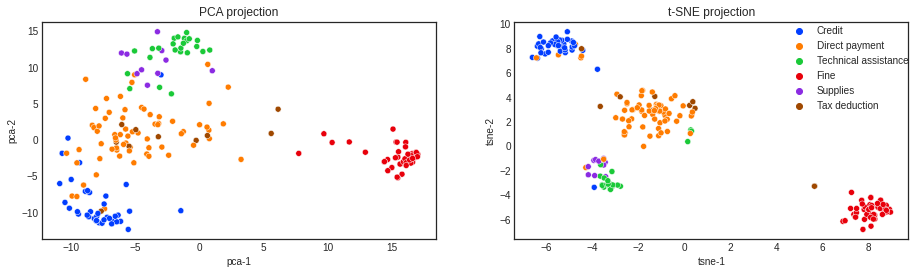

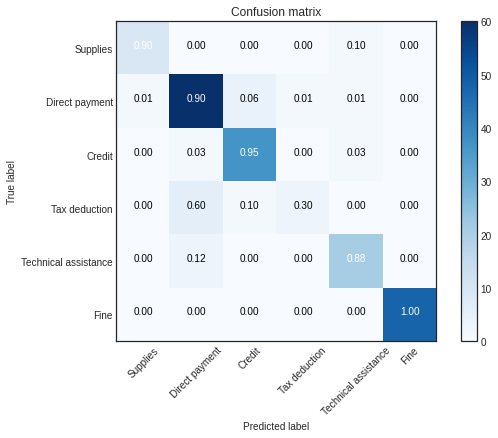

Macro/Weighted Avg F1-score: [0.8321773473740222, 0.8919266429404303]




Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating:  25%|██▌       | 2/8 [00:00<00:00, 16.17it/s]



Evaluating:  50%|█████     | 4/8 [00:00<00:00, 15.23it/s]

Evaluating:  75%|███████▌  | 6/8 [00:00<00:00, 14.78it/s]

Evaluating: 100%|██████████| 8/8 [00:00<00:00, 14.91it/s]




Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating:  25%|██▌       | 2/8 [00:00<00:00, 13.63it/s]



Evaluating:  50%|█████     | 4/8 [00:00<00:00, 14.01it/s]

Evaluating: 100%|██████████| 8/8 [00:00<00:00, 16.51it/s]

  1%|          | 5/788 [00:00<00:16, 47.29it/s]


Time taken for fine-tuning: 00:00:20.64
Classifying sentences...



100%|██████████| 788/788 [00:14<00:00, 53.85it/s]

100%|██████████| 198/198 [00:03<00:00, 53.05it/s]


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 198 samples in 0.000s...
[t-SNE] Computed neighbors for 198 samples in 0.008s...
[t-SNE] Computed conditional probabilities for sample 198 / 198
[t-SNE] Mean sigma: 7.500923
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.666992
[t-SNE] KL divergence after 850 iterations: 0.140255
Evaluating predictions...
                      precision    recall  f1-score   support

              Credit       0.91      1.00      0.95        39
      Direct payment       0.87      0.91      0.89        67
                Fine       1.00      0.98      0.99        48
            Supplies       0.88      0.70      0.78        10
       Tax deduction       0.86      0.60      0.71        10
Technical assistance       0.91      0.88      0.89        24

            accuracy                           0.91       198
           macro avg       0.90      0.84      0.87       198
        weighted avg       0.91      0.91      0.9

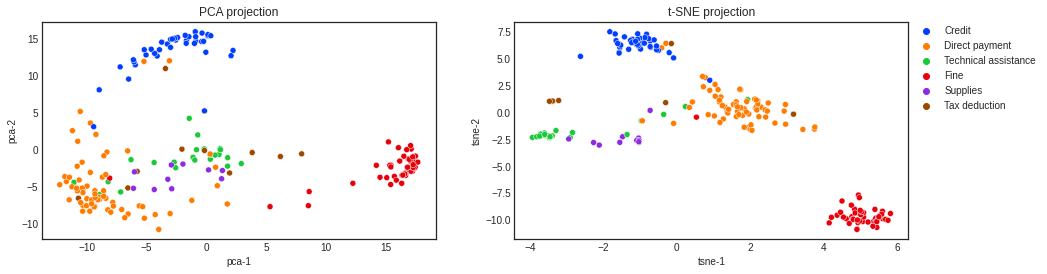

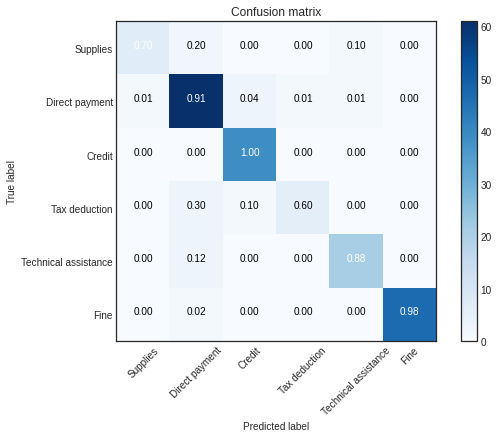

Macro/Weighted Avg F1-score: [0.8680802162177179, 0.9118178849100264]




Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating:  25%|██▌       | 2/8 [00:00<00:00, 13.64it/s]



Evaluating:  50%|█████     | 4/8 [00:00<00:00, 13.98it/s]

Evaluating: 100%|██████████| 8/8 [00:00<00:00, 15.25it/s]




Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating:  25%|██▌       | 2/8 [00:00<00:00, 15.44it/s]



Evaluating:  50%|█████     | 4/8 [00:00<00:00, 15.78it/s]

Evaluating:  75%|███████▌  | 6/8 [00:00<00:00, 15.01it/s]

Evaluating: 100%|██████████| 8/8 [00:00<00:00, 15.57it/s]

  1%|          | 5/788 [00:00<00:16, 47.91it/s]


Time taken for fine-tuning: 00:00:20.05
Classifying sentences...



100%|██████████| 788/788 [00:14<00:00, 53.51it/s]

100%|██████████| 198/198 [00:03<00:00, 53.28it/s]


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 198 samples in 0.001s...
[t-SNE] Computed neighbors for 198 samples in 0.010s...
[t-SNE] Computed conditional probabilities for sample 198 / 198
[t-SNE] Mean sigma: 9.873787
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.686699
[t-SNE] KL divergence after 1000 iterations: 0.126320
Evaluating predictions...
                      precision    recall  f1-score   support

              Credit       0.86      0.95      0.90        39
      Direct payment       0.85      0.85      0.85        67
                Fine       1.00      0.96      0.98        48
            Supplies       0.78      0.70      0.74        10
       Tax deduction       0.75      0.60      0.67        10
Technical assistance       0.84      0.88      0.86        24

            accuracy                           0.88       198
           macro avg       0.85      0.82      0.83       198
        weighted avg       0.88      0.88      0.

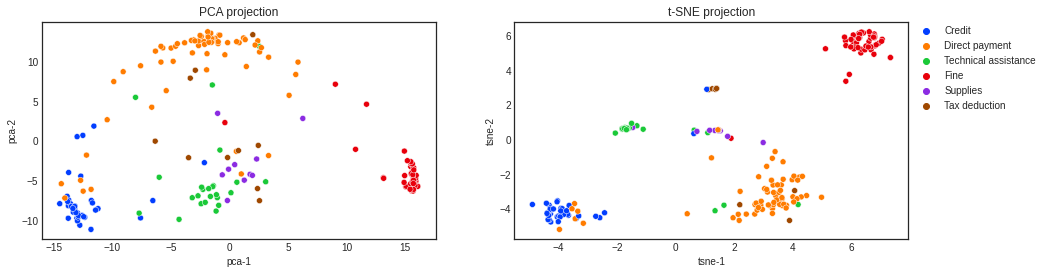

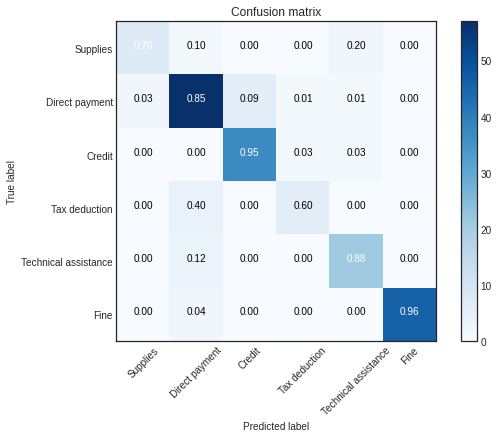

Macro/Weighted Avg F1-score: [0.8320933877291603, 0.8776785941727355]




Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating:  25%|██▌       | 2/8 [00:00<00:00, 14.32it/s]



Evaluating:  50%|█████     | 4/8 [00:00<00:00, 14.03it/s]

Evaluating: 100%|██████████| 8/8 [00:00<00:00, 15.65it/s]




Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating:  25%|██▌       | 2/8 [00:00<00:00, 15.30it/s]



Evaluating:  50%|█████     | 4/8 [00:00<00:00, 14.62it/s]

Evaluating:  75%|███████▌  | 6/8 [00:00<00:00, 14.84it/s]

Evaluating: 100%|██████████| 8/8 [00:00<00:00, 15.36it/s]

  1%|          | 5/788 [00:00<00:16, 47.74it/s]


Time taken for fine-tuning: 00:00:19.99
Classifying sentences...



100%|██████████| 788/788 [00:14<00:00, 53.11it/s]

100%|██████████| 198/198 [00:03<00:00, 53.61it/s]


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 198 samples in 0.001s...
[t-SNE] Computed neighbors for 198 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 198 / 198
[t-SNE] Mean sigma: 9.426066
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.644291
[t-SNE] KL divergence after 1000 iterations: 0.130122
Evaluating predictions...
                      precision    recall  f1-score   support

              Credit       0.86      0.92      0.89        39
      Direct payment       0.86      0.90      0.88        67
                Fine       1.00      0.96      0.98        48
            Supplies       0.70      0.70      0.70        10
       Tax deduction       0.86      0.60      0.71        10
Technical assistance       0.87      0.83      0.85        24

            accuracy                           0.88       198
           macro avg       0.86      0.82      0.83       198
        weighted avg       0.89      0.88      0.

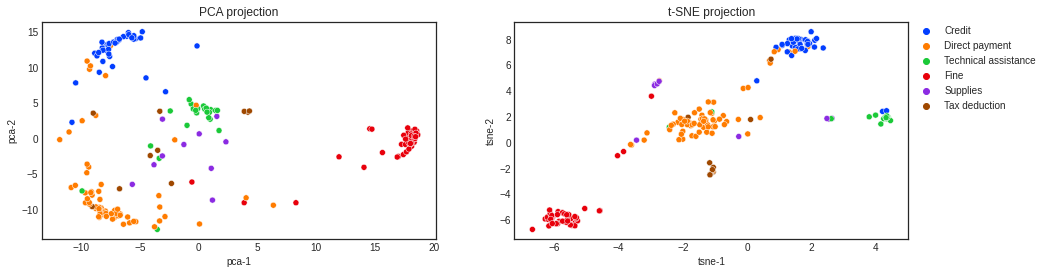

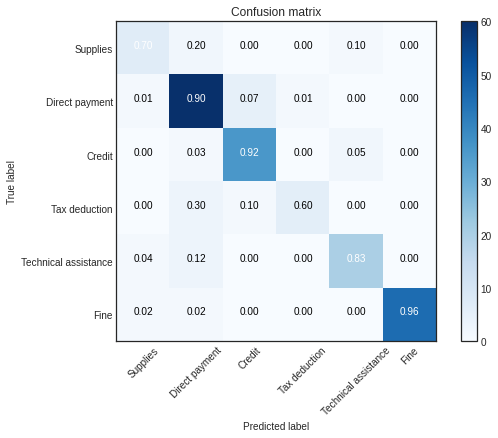

Macro/Weighted Avg F1-score: [0.8334118141052905, 0.8829084692024681]




Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating:  25%|██▌       | 2/8 [00:00<00:00, 14.68it/s]



Evaluating:  50%|█████     | 4/8 [00:00<00:00, 14.56it/s]

Evaluating: 100%|██████████| 8/8 [00:00<00:00, 15.27it/s]




Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating:  25%|██▌       | 2/8 [00:00<00:00, 13.62it/s]



Evaluating:  50%|█████     | 4/8 [00:00<00:00, 14.00it/s]

Evaluating: 100%|██████████| 8/8 [00:00<00:00, 15.71it/s]

  1%|          | 5/788 [00:00<00:15, 49.52it/s]


Time taken for fine-tuning: 00:00:20.15
Classifying sentences...



100%|██████████| 788/788 [00:14<00:00, 53.90it/s]

100%|██████████| 198/198 [00:03<00:00, 53.95it/s]


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 198 samples in 0.000s...
[t-SNE] Computed neighbors for 198 samples in 0.009s...
[t-SNE] Computed conditional probabilities for sample 198 / 198
[t-SNE] Mean sigma: 8.665196
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.073822
[t-SNE] KL divergence after 1000 iterations: 0.113893
Evaluating predictions...
                      precision    recall  f1-score   support

              Credit       0.88      0.97      0.93        39
      Direct payment       0.90      0.90      0.90        67
                Fine       0.98      0.98      0.98        48
            Supplies       0.70      0.70      0.70        10
       Tax deduction       0.83      0.50      0.62        10
Technical assistance       0.83      0.83      0.83        24

            accuracy                           0.89       198
           macro avg       0.85      0.81      0.83       198
        weighted avg       0.89      0.89      0.

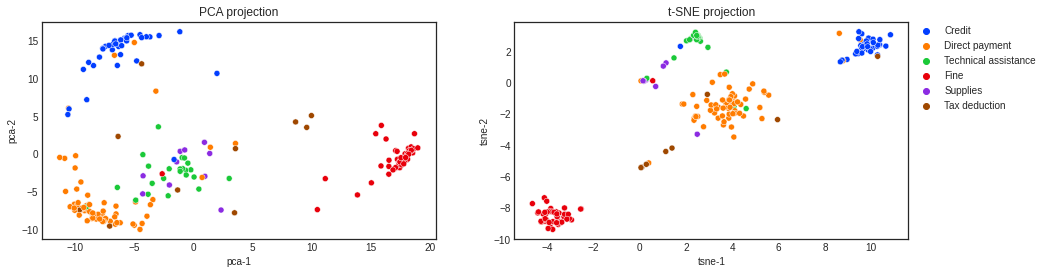

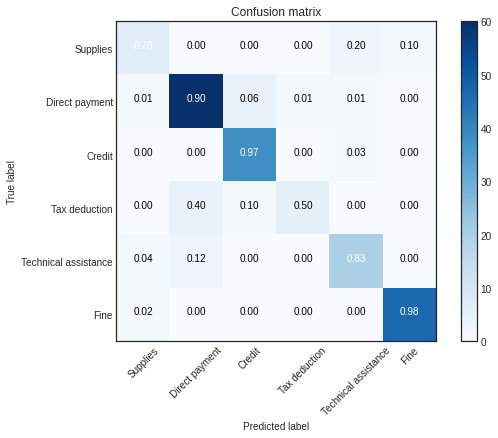

Macro/Weighted Avg F1-score: [0.8266419427253974, 0.8908906134515892]




Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating:  25%|██▌       | 2/8 [00:00<00:00, 17.83it/s]



Evaluating:  50%|█████     | 4/8 [00:00<00:00, 16.42it/s]

Evaluating: 100%|██████████| 8/8 [00:00<00:00, 15.83it/s]




Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating:  25%|██▌       | 2/8 [00:00<00:00, 19.37it/s]



Evaluating:  50%|█████     | 4/8 [00:00<00:00, 17.44it/s]

Evaluating:  75%|███████▌  | 6/8 [00:00<00:00, 17.40it/s]

Evaluating: 100%|██████████| 8/8 [00:00<00:00, 16.82it/s]

  1%|          | 5/788 [00:00<00:15, 49.32it/s]


Time taken for fine-tuning: 00:00:20.11
Classifying sentences...



100%|██████████| 788/788 [00:14<00:00, 53.85it/s]

100%|██████████| 198/198 [00:03<00:00, 54.08it/s]


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 198 samples in 0.000s...
[t-SNE] Computed neighbors for 198 samples in 0.010s...
[t-SNE] Computed conditional probabilities for sample 198 / 198
[t-SNE] Mean sigma: 9.229141
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.793724
[t-SNE] KL divergence after 1000 iterations: 0.097550
Evaluating predictions...
                      precision    recall  f1-score   support

              Credit       0.92      0.90      0.91        39
      Direct payment       0.89      0.93      0.91        67
                Fine       0.98      0.94      0.96        48
            Supplies       0.70      0.70      0.70        10
       Tax deduction       0.88      0.70      0.78        10
Technical assistance       0.81      0.88      0.84        24

            accuracy                           0.89       198
           macro avg       0.86      0.84      0.85       198
        weighted avg       0.90      0.89      0.

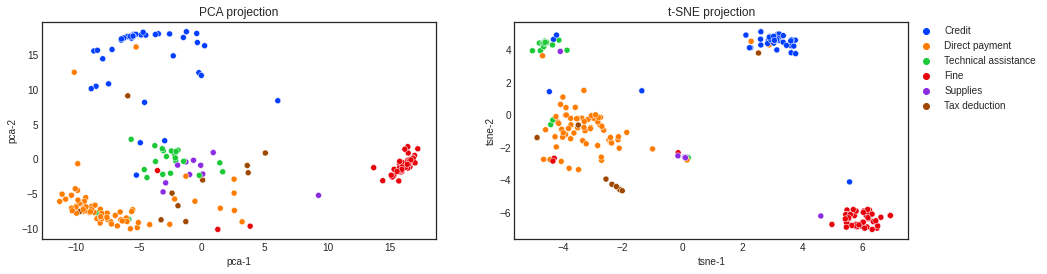

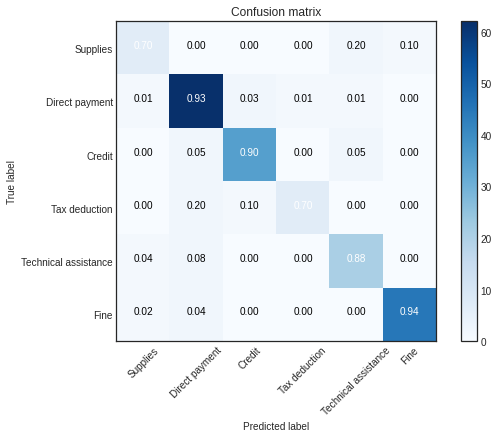

Macro/Weighted Avg F1-score: [0.84823749740507, 0.8938995242790768]




Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating:  25%|██▌       | 2/8 [00:00<00:00, 13.44it/s]



Evaluating:  50%|█████     | 4/8 [00:00<00:00, 13.82it/s]

Evaluating: 100%|██████████| 8/8 [00:00<00:00, 15.05it/s]




Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating:  25%|██▌       | 2/8 [00:00<00:00, 14.22it/s]



Evaluating:  50%|█████     | 4/8 [00:00<00:00, 13.96it/s]

Evaluating: 100%|██████████| 8/8 [00:00<00:00, 15.78it/s]

  1%|          | 6/788 [00:00<00:14, 53.57it/s]


Time taken for fine-tuning: 00:00:20.64
Classifying sentences...



100%|██████████| 788/788 [00:14<00:00, 53.06it/s]

100%|██████████| 198/198 [00:03<00:00, 53.32it/s]


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 198 samples in 0.000s...
[t-SNE] Computed neighbors for 198 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 198 / 198
[t-SNE] Mean sigma: 5.995101
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.539604
[t-SNE] KL divergence after 1000 iterations: 0.138716
Evaluating predictions...
                      precision    recall  f1-score   support

              Credit       0.90      0.97      0.94        39
      Direct payment       0.87      0.87      0.87        67
                Fine       0.96      0.98      0.97        48
            Supplies       0.86      0.60      0.71        10
       Tax deduction       0.86      0.60      0.71        10
Technical assistance       0.81      0.88      0.84        24

            accuracy                           0.89       198
           macro avg       0.88      0.82      0.84       198
        weighted avg       0.89      0.89      0.

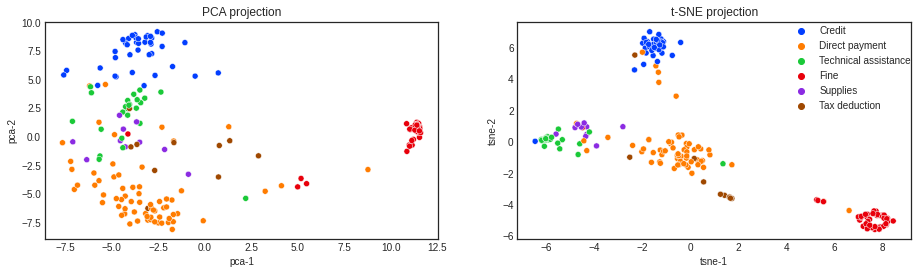

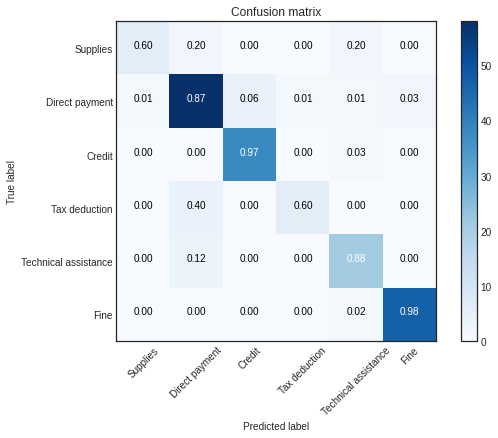

Macro/Weighted Avg F1-score: [0.8374633529266872, 0.8857863816613227]




Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating:  25%|██▌       | 2/8 [00:00<00:00, 16.53it/s]



Evaluating:  50%|█████     | 4/8 [00:00<00:00, 15.42it/s]

Evaluating:  75%|███████▌  | 6/8 [00:00<00:00, 14.97it/s]

Evaluating: 100%|██████████| 8/8 [00:00<00:00, 15.37it/s]




Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating:  25%|██▌       | 2/8 [00:00<00:00, 15.12it/s]



Evaluating:  50%|█████     | 4/8 [00:00<00:00, 14.62it/s]

Evaluating:  75%|███████▌  | 6/8 [00:00<00:00, 14.46it/s]

Evaluating: 100%|██████████| 8/8 [00:00<00:00, 15.16it/s]

  1%|          | 6/788 [00:00<00:15, 52.08it/s]


Time taken for fine-tuning: 00:00:20.40
Classifying sentences...



100%|██████████| 788/788 [00:14<00:00, 55.50it/s]

100%|██████████| 198/198 [00:03<00:00, 55.55it/s]


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 198 samples in 0.001s...
[t-SNE] Computed neighbors for 198 samples in 0.012s...
[t-SNE] Computed conditional probabilities for sample 198 / 198
[t-SNE] Mean sigma: 6.045373
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.770191
[t-SNE] KL divergence after 800 iterations: 0.112303
Evaluating predictions...
                      precision    recall  f1-score   support

              Credit       0.90      0.92      0.91        39
      Direct payment       0.89      0.88      0.89        67
                Fine       0.96      0.96      0.96        48
            Supplies       0.67      0.60      0.63        10
       Tax deduction       0.78      0.70      0.74        10
Technical assistance       0.77      0.83      0.80        24

            accuracy                           0.88       198
           macro avg       0.83      0.82      0.82       198
        weighted avg       0.88      0.88      0.8

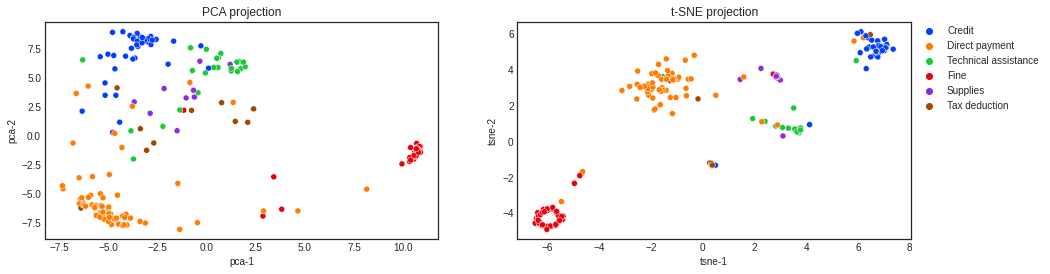

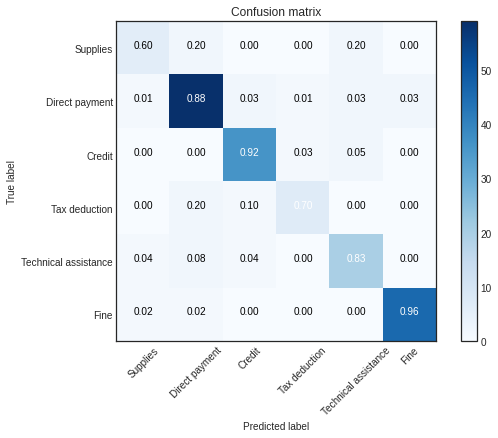

Macro/Weighted Avg F1-score: [0.8208941393568309, 0.87814203710273]




Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating:  25%|██▌       | 2/8 [00:00<00:00, 15.85it/s]



Evaluating:  50%|█████     | 4/8 [00:00<00:00, 15.43it/s]

Evaluating:  75%|███████▌  | 6/8 [00:00<00:00, 15.16it/s]

Evaluating: 100%|██████████| 8/8 [00:00<00:00, 15.53it/s]




Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating:  25%|██▌       | 2/8 [00:00<00:00, 14.10it/s]



Evaluating:  50%|█████     | 4/8 [00:00<00:00, 13.90it/s]

Evaluating: 100%|██████████| 8/8 [00:00<00:00, 15.60it/s]

  1%|          | 5/788 [00:00<00:15, 49.24it/s]


Time taken for fine-tuning: 00:00:20.26
Classifying sentences...



100%|██████████| 788/788 [00:14<00:00, 54.96it/s]

100%|██████████| 198/198 [00:03<00:00, 54.95it/s]


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 198 samples in 0.000s...
[t-SNE] Computed neighbors for 198 samples in 0.012s...
[t-SNE] Computed conditional probabilities for sample 198 / 198
[t-SNE] Mean sigma: 5.215545
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.990067
[t-SNE] KL divergence after 1000 iterations: 0.110078
Evaluating predictions...
                      precision    recall  f1-score   support

              Credit       0.86      0.97      0.92        39
      Direct payment       0.84      0.84      0.84        67
                Fine       0.94      1.00      0.97        48
            Supplies       0.67      0.60      0.63        10
       Tax deduction       0.88      0.70      0.78        10
Technical assistance       0.89      0.71      0.79        24

            accuracy                           0.87       198
           macro avg       0.85      0.80      0.82       198
        weighted avg       0.87      0.87      0.

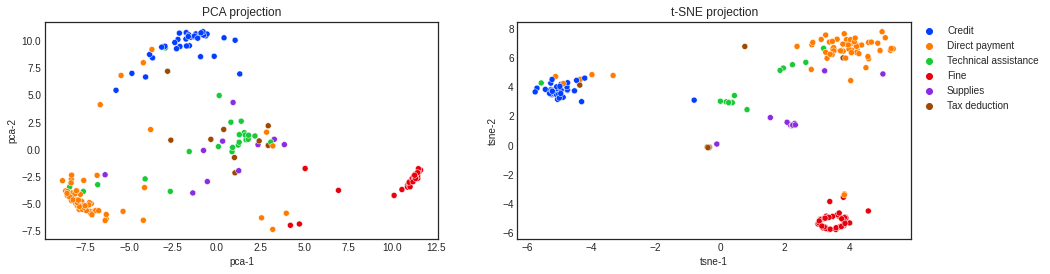

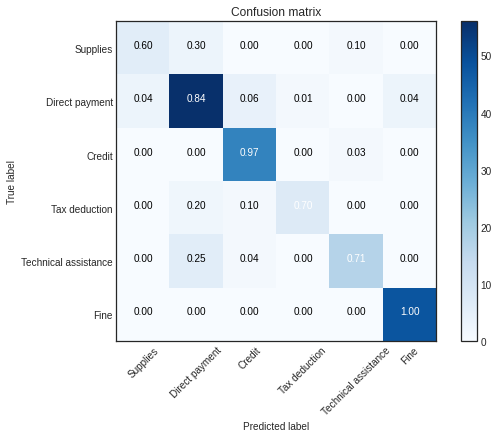

Macro/Weighted Avg F1-score: [0.820205819231095, 0.8652859058406921]




Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating:  25%|██▌       | 2/8 [00:00<00:00, 16.08it/s]



Evaluating:  50%|█████     | 4/8 [00:00<00:00, 15.71it/s]

Evaluating:  75%|███████▌  | 6/8 [00:00<00:00, 16.17it/s]

Evaluating: 100%|██████████| 8/8 [00:00<00:00, 16.39it/s]




Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating:  25%|██▌       | 2/8 [00:00<00:00, 15.29it/s]



Evaluating:  50%|█████     | 4/8 [00:00<00:00, 14.71it/s]

Evaluating:  75%|███████▌  | 6/8 [00:00<00:00, 15.26it/s]

Evaluating: 100%|██████████| 8/8 [00:00<00:00, 15.92it/s]

  1%|          | 5/788 [00:00<00:15, 48.94it/s]


Time taken for fine-tuning: 00:00:19.77
Classifying sentences...



100%|██████████| 788/788 [00:14<00:00, 54.67it/s]

100%|██████████| 198/198 [00:03<00:00, 54.00it/s]


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 198 samples in 0.000s...
[t-SNE] Computed neighbors for 198 samples in 0.010s...
[t-SNE] Computed conditional probabilities for sample 198 / 198
[t-SNE] Mean sigma: 6.256975
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.741470
[t-SNE] KL divergence after 850 iterations: 0.104006
Evaluating predictions...
                      precision    recall  f1-score   support

              Credit       0.84      0.97      0.90        39
      Direct payment       0.90      0.84      0.87        67
                Fine       0.94      0.96      0.95        48
            Supplies       0.70      0.70      0.70        10
       Tax deduction       0.78      0.70      0.74        10
Technical assistance       0.87      0.83      0.85        24

            accuracy                           0.88       198
           macro avg       0.84      0.83      0.83       198
        weighted avg       0.88      0.88      0.8

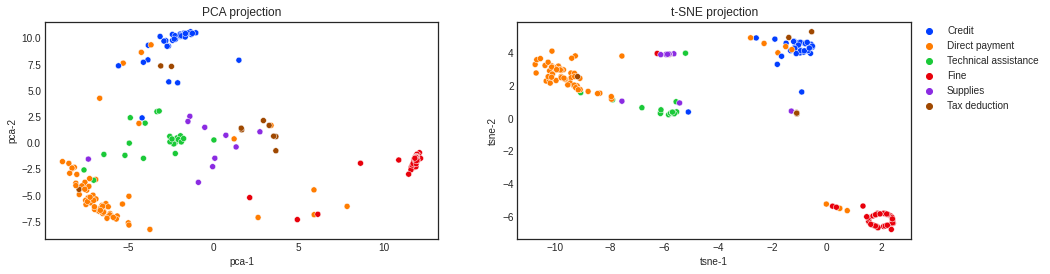

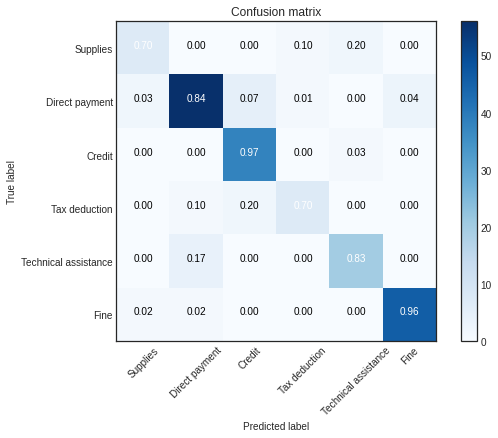

Macro/Weighted Avg F1-score: [0.8348897503872142, 0.8776564802261347]




Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating:  38%|███▊      | 3/8 [00:00<00:00, 18.12it/s]



Evaluating:  62%|██████▎   | 5/8 [00:00<00:00, 16.36it/s]

Evaluating: 100%|██████████| 8/8 [00:00<00:00, 16.96it/s]




Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating:  25%|██▌       | 2/8 [00:00<00:00, 13.74it/s]



Evaluating:  50%|█████     | 4/8 [00:00<00:00, 14.12it/s]

Evaluating: 100%|██████████| 8/8 [00:00<00:00, 15.79it/s]

  1%|          | 5/788 [00:00<00:16, 48.92it/s]


Time taken for fine-tuning: 00:00:19.76
Classifying sentences...



100%|██████████| 788/788 [00:14<00:00, 55.01it/s]

100%|██████████| 198/198 [00:03<00:00, 55.03it/s]


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 198 samples in 0.000s...
[t-SNE] Computed neighbors for 198 samples in 0.009s...
[t-SNE] Computed conditional probabilities for sample 198 / 198
[t-SNE] Mean sigma: 5.349754
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.591740
[t-SNE] KL divergence after 1000 iterations: 0.088920
Evaluating predictions...
                      precision    recall  f1-score   support

              Credit       0.90      0.97      0.94        39
      Direct payment       0.88      0.90      0.89        67
                Fine       0.96      1.00      0.98        48
            Supplies       0.89      0.80      0.84        10
       Tax deduction       0.88      0.70      0.78        10
Technical assistance       0.95      0.83      0.89        24

            accuracy                           0.91       198
           macro avg       0.91      0.87      0.89       198
        weighted avg       0.91      0.91      0.

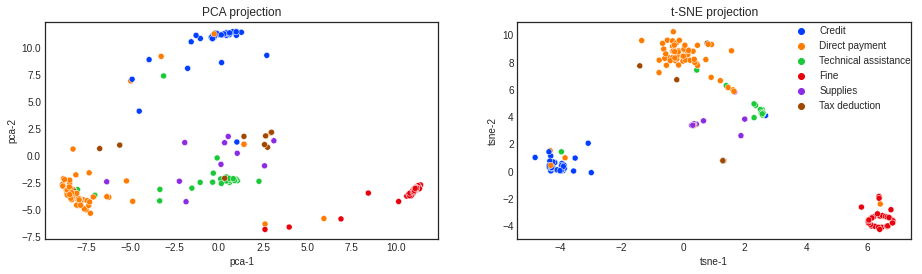

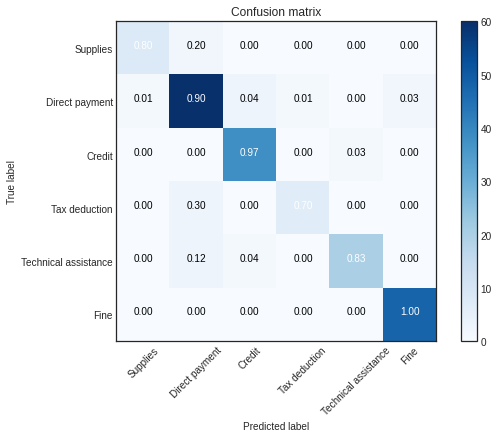

Macro/Weighted Avg F1-score: [0.8859207100644028, 0.912629899263149]




Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating:  25%|██▌       | 2/8 [00:00<00:00, 16.28it/s]



Evaluating:  50%|█████     | 4/8 [00:00<00:00, 15.35it/s]

Evaluating: 100%|██████████| 8/8 [00:00<00:00, 16.13it/s]




Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating:  25%|██▌       | 2/8 [00:00<00:00, 14.37it/s]



Evaluating:  50%|█████     | 4/8 [00:00<00:00, 14.48it/s]

Evaluating:  75%|███████▌  | 6/8 [00:00<00:00, 14.63it/s]

Evaluating: 100%|██████████| 8/8 [00:00<00:00, 15.31it/s]

  1%|          | 5/788 [00:00<00:15, 49.98it/s]


Time taken for fine-tuning: 00:00:20.10
Classifying sentences...



100%|██████████| 788/788 [00:14<00:00, 55.07it/s]

100%|██████████| 198/198 [00:03<00:00, 55.34it/s]


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 198 samples in 0.004s...
[t-SNE] Computed neighbors for 198 samples in 0.010s...
[t-SNE] Computed conditional probabilities for sample 198 / 198
[t-SNE] Mean sigma: 4.339426
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.144218
[t-SNE] KL divergence after 750 iterations: 0.101231
Evaluating predictions...
                      precision    recall  f1-score   support

              Credit       0.90      0.97      0.94        39
      Direct payment       0.87      0.91      0.89        67
                Fine       0.98      0.96      0.97        48
            Supplies       0.89      0.80      0.84        10
       Tax deduction       0.88      0.70      0.78        10
Technical assistance       0.86      0.79      0.83        24

            accuracy                           0.90       198
           macro avg       0.90      0.86      0.87       198
        weighted avg       0.90      0.90      0.9

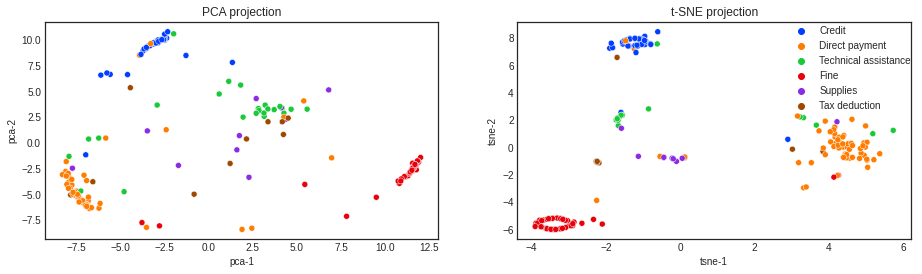

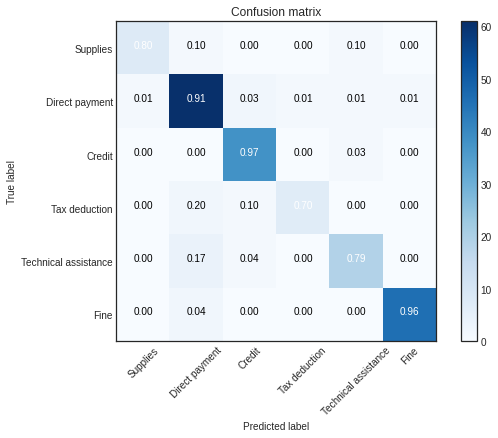

Macro/Weighted Avg F1-score: [0.8738622673220621, 0.902858353845602]




Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:  20%|██        | 2/10 [00:00<00:00, 16.70it/s]



Evaluating:  40%|████      | 4/10 [00:00<00:00, 15.18it/s]

Evaluating:  60%|██████    | 6/10 [00:00<00:00, 15.49it/s]

Evaluating:  80%|████████  | 8/10 [00:00<00:00, 15.49it/s]

Evaluating: 100%|██████████| 10/10 [00:00<00:00, 14.62it/s]




Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:  20%|██        | 2/10 [00:00<00:00, 14.45it/s]



Evaluating:  40%|████      | 4/10 [00:00<00:00, 14.18it/s]

Evaluating:  60%|██████    | 6/10 [00:00<00:00, 13.99it/s]

Evaluating:  80%|████████  | 8/10 [00:00<00:00, 14.45it/s]

Evaluating: 100%|██████████| 10/10 [00:00<00:00, 14.90it/s]

  1%|          | 5/788 [00:00<00:15, 49.87it/s]


Time taken for fine-tuning: 00:00:20.03
Classifying sentences...



100%|██████████| 788/788 [00:14<00:00, 54.99it/s]

100%|██████████| 198/198 [00:03<00:00, 53.68it/s]


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 198 samples in 0.000s...
[t-SNE] Computed neighbors for 198 samples in 0.017s...
[t-SNE] Computed conditional probabilities for sample 198 / 198
[t-SNE] Mean sigma: 7.336674
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.434601
[t-SNE] KL divergence after 800 iterations: 0.149604
Evaluating predictions...
                      precision    recall  f1-score   support

              Credit       0.88      0.97      0.93        39
      Direct payment       0.89      0.88      0.89        67
                Fine       0.98      0.98      0.98        48
            Supplies       0.70      0.70      0.70        10
       Tax deduction       0.83      0.50      0.62        10
Technical assistance       0.80      0.83      0.82        24

            accuracy                           0.89       198
           macro avg       0.85      0.81      0.82       198
        weighted avg       0.89      0.89      0.8

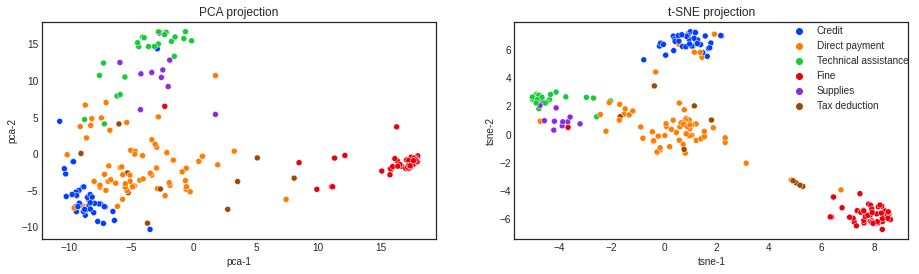

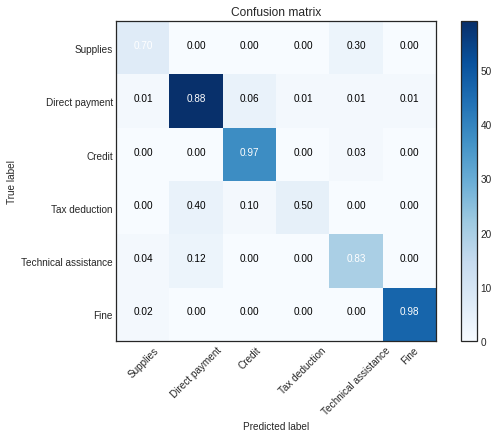

Macro/Weighted Avg F1-score: [0.8224234184473961, 0.8860191273770955]




Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:  20%|██        | 2/10 [00:00<00:00, 17.62it/s]



Evaluating:  40%|████      | 4/10 [00:00<00:00, 16.30it/s]

Evaluating:  60%|██████    | 6/10 [00:00<00:00, 16.40it/s]

Evaluating:  80%|████████  | 8/10 [00:00<00:00, 15.43it/s]

Evaluating: 100%|██████████| 10/10 [00:00<00:00, 15.02it/s]




Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:  30%|███       | 3/10 [00:00<00:00, 19.34it/s]



Evaluating:  50%|█████     | 5/10 [00:00<00:00, 17.16it/s]

Evaluating:  70%|███████   | 7/10 [00:00<00:00, 16.33it/s]

Evaluating: 100%|██████████| 10/10 [00:00<00:00, 16.08it/s]

  1%|          | 5/788 [00:00<00:15, 49.03it/s]


Time taken for fine-tuning: 00:00:19.72
Classifying sentences...



100%|██████████| 788/788 [00:14<00:00, 55.26it/s]

100%|██████████| 198/198 [00:03<00:00, 55.42it/s]


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 198 samples in 0.000s...
[t-SNE] Computed neighbors for 198 samples in 0.011s...
[t-SNE] Computed conditional probabilities for sample 198 / 198
[t-SNE] Mean sigma: 8.296149
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.785522
[t-SNE] KL divergence after 1000 iterations: 0.167233
Evaluating predictions...
                      precision    recall  f1-score   support

              Credit       0.91      0.82      0.86        39
      Direct payment       0.82      0.90      0.86        67
                Fine       0.94      0.98      0.96        48
            Supplies       0.89      0.80      0.84        10
       Tax deduction       0.71      0.50      0.59        10
Technical assistance       0.83      0.83      0.83        24

            accuracy                           0.87       198
           macro avg       0.85      0.80      0.82       198
        weighted avg       0.87      0.87      0.

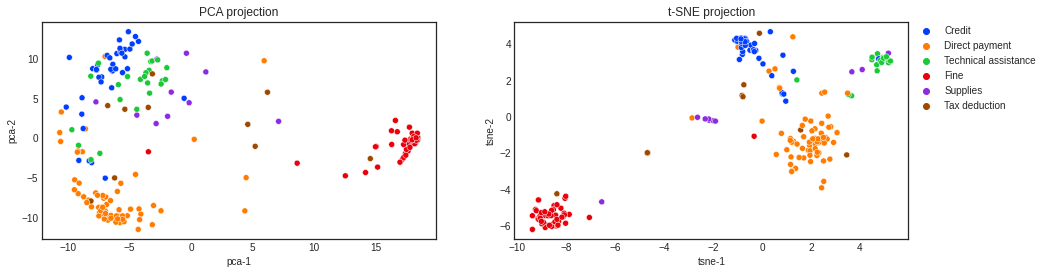

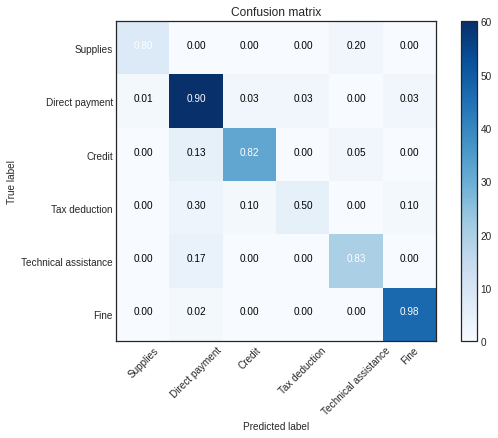

Macro/Weighted Avg F1-score: [0.8241442143476642, 0.8661743588767029]




Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:  20%|██        | 2/10 [00:00<00:00, 17.57it/s]



Evaluating:  40%|████      | 4/10 [00:00<00:00, 17.13it/s]

Evaluating:  60%|██████    | 6/10 [00:00<00:00, 16.17it/s]

Evaluating:  80%|████████  | 8/10 [00:00<00:00, 15.64it/s]

Evaluating: 100%|██████████| 10/10 [00:00<00:00, 15.85it/s]




Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:  20%|██        | 2/10 [00:00<00:00, 14.76it/s]



Evaluating:  40%|████      | 4/10 [00:00<00:00, 14.38it/s]

Evaluating:  60%|██████    | 6/10 [00:00<00:00, 14.93it/s]

Evaluating:  80%|████████  | 8/10 [00:00<00:00, 14.85it/s]

Evaluating: 100%|██████████| 10/10 [00:00<00:00, 15.06it/s]

  1%|          | 5/788 [00:00<00:16, 47.92it/s]


Time taken for fine-tuning: 00:00:19.48
Classifying sentences...



100%|██████████| 788/788 [00:14<00:00, 54.86it/s]

100%|██████████| 198/198 [00:03<00:00, 54.96it/s]


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 198 samples in 0.000s...
[t-SNE] Computed neighbors for 198 samples in 0.010s...
[t-SNE] Computed conditional probabilities for sample 198 / 198
[t-SNE] Mean sigma: 7.709195
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.581478
[t-SNE] KL divergence after 1000 iterations: 0.136607
Evaluating predictions...
                      precision    recall  f1-score   support

              Credit       0.90      0.92      0.91        39
      Direct payment       0.87      0.88      0.87        67
                Fine       0.96      0.98      0.97        48
            Supplies       0.78      0.70      0.74        10
       Tax deduction       0.86      0.60      0.71        10
Technical assistance       0.80      0.83      0.82        24

            accuracy                           0.88       198
           macro avg       0.86      0.82      0.84       198
        weighted avg       0.88      0.88      0.

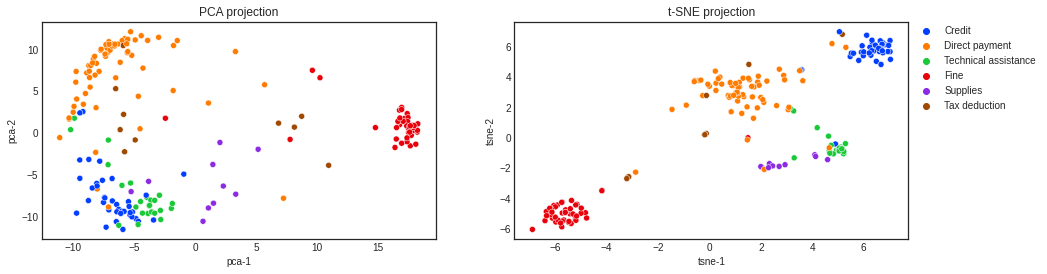

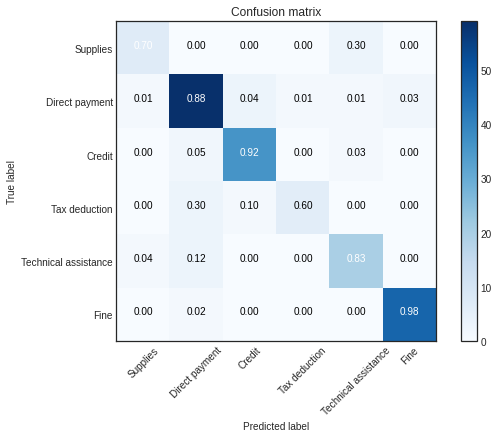

Macro/Weighted Avg F1-score: [0.8355982721503996, 0.8820293535085572]




Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:  20%|██        | 2/10 [00:00<00:00, 19.01it/s]



Evaluating:  40%|████      | 4/10 [00:00<00:00, 17.30it/s]

Evaluating:  60%|██████    | 6/10 [00:00<00:00, 17.29it/s]

Evaluating:  80%|████████  | 8/10 [00:00<00:00, 15.96it/s]

Evaluating: 100%|██████████| 10/10 [00:00<00:00, 15.39it/s]




Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:  20%|██        | 2/10 [00:00<00:00, 14.54it/s]



Evaluating:  40%|████      | 4/10 [00:00<00:00, 15.05it/s]

Evaluating:  60%|██████    | 6/10 [00:00<00:00, 14.58it/s]

Evaluating:  80%|████████  | 8/10 [00:00<00:00, 14.71it/s]

Evaluating: 100%|██████████| 10/10 [00:00<00:00, 15.38it/s]

  1%|          | 5/788 [00:00<00:16, 47.52it/s]


Time taken for fine-tuning: 00:00:19.31
Classifying sentences...



100%|██████████| 788/788 [00:14<00:00, 54.65it/s]

100%|██████████| 198/198 [00:03<00:00, 54.62it/s]


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 198 samples in 0.000s...
[t-SNE] Computed neighbors for 198 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 198 / 198
[t-SNE] Mean sigma: 8.495613
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.376678
[t-SNE] KL divergence after 1000 iterations: 0.113412
Evaluating predictions...
                      precision    recall  f1-score   support

              Credit       0.88      0.95      0.91        39
      Direct payment       0.87      0.87      0.87        67
                Fine       0.96      1.00      0.98        48
            Supplies       0.78      0.70      0.74        10
       Tax deduction       0.80      0.40      0.53        10
Technical assistance       0.84      0.88      0.86        24

            accuracy                           0.88       198
           macro avg       0.85      0.80      0.81       198
        weighted avg       0.88      0.88      0.

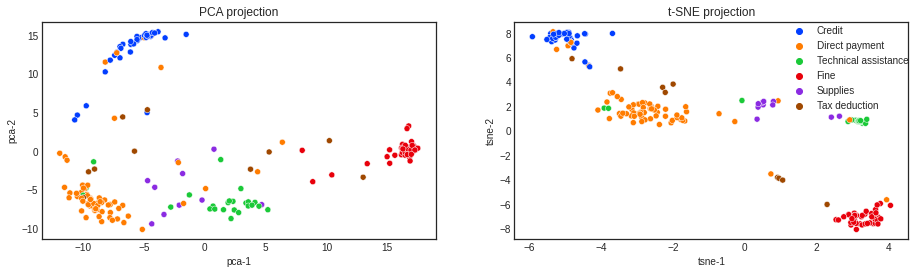

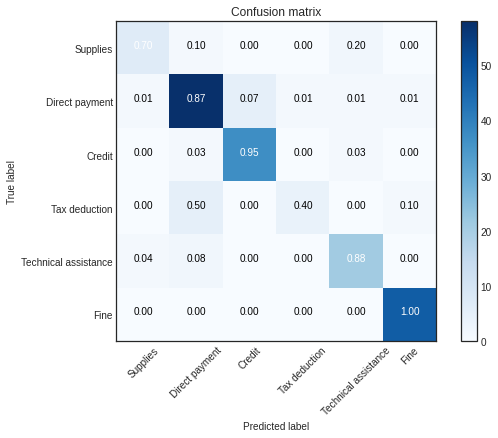

Macro/Weighted Avg F1-score: [0.8143603368631113, 0.8784001047994364]




Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:  20%|██        | 2/10 [00:00<00:00, 15.43it/s]



Evaluating:  40%|████      | 4/10 [00:00<00:00, 15.10it/s]

Evaluating:  60%|██████    | 6/10 [00:00<00:00, 14.89it/s]

Evaluating:  80%|████████  | 8/10 [00:00<00:00, 15.60it/s]

Evaluating: 100%|██████████| 10/10 [00:00<00:00, 15.24it/s]




Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:  20%|██        | 2/10 [00:00<00:00, 15.70it/s]



Evaluating:  40%|████      | 4/10 [00:00<00:00, 16.20it/s]

Evaluating:  60%|██████    | 6/10 [00:00<00:00, 17.16it/s]

Evaluating:  80%|████████  | 8/10 [00:00<00:00, 15.86it/s]

Evaluating: 100%|██████████| 10/10 [00:00<00:00, 15.86it/s]

  1%|          | 5/788 [00:00<00:15, 49.74it/s]


Time taken for fine-tuning: 00:00:19.21
Classifying sentences...



100%|██████████| 788/788 [00:14<00:00, 54.97it/s]

100%|██████████| 198/198 [00:03<00:00, 54.68it/s]


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 198 samples in 0.003s...
[t-SNE] Computed neighbors for 198 samples in 0.015s...
[t-SNE] Computed conditional probabilities for sample 198 / 198
[t-SNE] Mean sigma: 9.848378
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.470680
[t-SNE] KL divergence after 950 iterations: 0.107983
Evaluating predictions...
                      precision    recall  f1-score   support

              Credit       0.86      0.97      0.92        39
      Direct payment       0.88      0.85      0.86        67
                Fine       0.98      0.98      0.98        48
            Supplies       0.80      0.80      0.80        10
       Tax deduction       0.83      0.50      0.62        10
Technical assistance       0.84      0.88      0.86        24

            accuracy                           0.89       198
           macro avg       0.87      0.83      0.84       198
        weighted avg       0.89      0.89      0.8

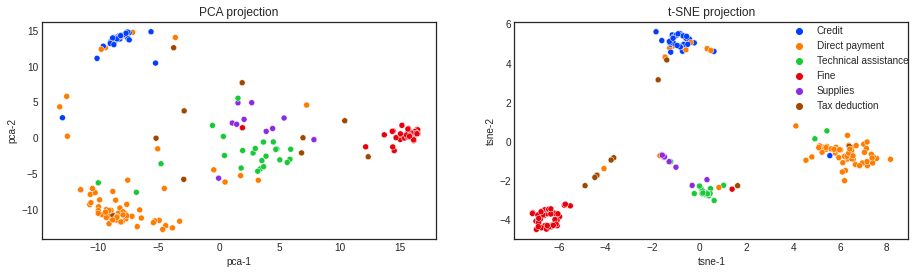

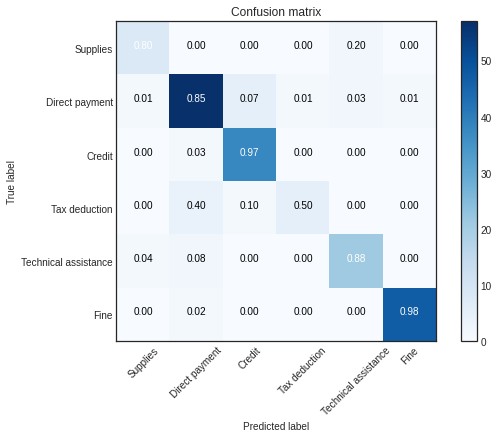

Macro/Weighted Avg F1-score: [0.8401014230080496, 0.8858379207502977]




Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:  20%|██        | 2/10 [00:00<00:00, 15.67it/s]



Evaluating:  40%|████      | 4/10 [00:00<00:00, 15.29it/s]

Evaluating:  60%|██████    | 6/10 [00:00<00:00, 14.96it/s]

Evaluating:  80%|████████  | 8/10 [00:00<00:00, 15.21it/s]

Evaluating: 100%|██████████| 10/10 [00:00<00:00, 15.03it/s]




Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:  20%|██        | 2/10 [00:00<00:00, 13.45it/s]



Evaluating:  40%|████      | 4/10 [00:00<00:00, 14.01it/s]

Evaluating:  60%|██████    | 6/10 [00:00<00:00, 14.03it/s]

Evaluating:  80%|████████  | 8/10 [00:00<00:00, 14.23it/s]

Evaluating: 100%|██████████| 10/10 [00:00<00:00, 15.13it/s]

  1%|          | 5/788 [00:00<00:15, 49.95it/s]


Time taken for fine-tuning: 00:00:19.59
Classifying sentences...



100%|██████████| 788/788 [00:14<00:00, 54.85it/s]

100%|██████████| 198/198 [00:03<00:00, 55.51it/s]


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 198 samples in 0.005s...
[t-SNE] Computed neighbors for 198 samples in 0.012s...
[t-SNE] Computed conditional probabilities for sample 198 / 198
[t-SNE] Mean sigma: 7.262575
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.219650
[t-SNE] KL divergence after 900 iterations: 0.112618
Evaluating predictions...
                      precision    recall  f1-score   support

              Credit       0.93      0.97      0.95        39
      Direct payment       0.88      0.90      0.89        67
                Fine       0.98      0.98      0.98        48
            Supplies       0.80      0.80      0.80        10
       Tax deduction       0.83      0.50      0.62        10
Technical assistance       0.84      0.88      0.86        24

            accuracy                           0.90       198
           macro avg       0.88      0.84      0.85       198
        weighted avg       0.90      0.90      0.9

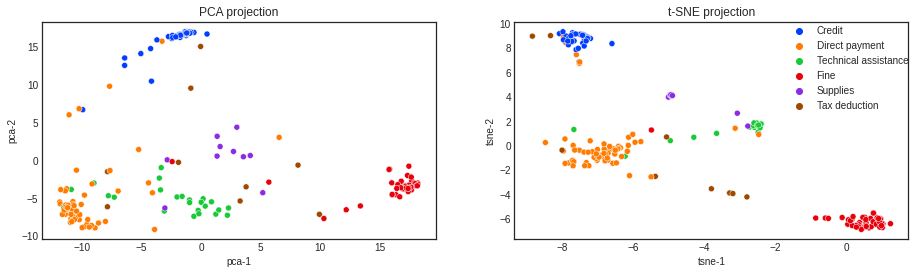

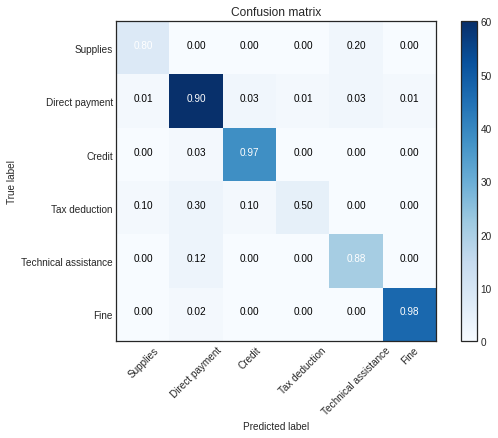

Macro/Weighted Avg F1-score: [0.850033068783069, 0.9011463844797178]




Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:  20%|██        | 2/10 [00:00<00:00, 17.19it/s]



Evaluating:  40%|████      | 4/10 [00:00<00:00, 17.62it/s]

Evaluating:  60%|██████    | 6/10 [00:00<00:00, 16.09it/s]

Evaluating:  80%|████████  | 8/10 [00:00<00:00, 15.48it/s]

Evaluating: 100%|██████████| 10/10 [00:00<00:00, 15.54it/s]




Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:  20%|██        | 2/10 [00:00<00:00, 13.47it/s]



Evaluating:  40%|████      | 4/10 [00:00<00:00, 14.67it/s]

Evaluating:  60%|██████    | 6/10 [00:00<00:00, 15.59it/s]

Evaluating:  80%|████████  | 8/10 [00:00<00:00, 15.28it/s]

Evaluating: 100%|██████████| 10/10 [00:00<00:00, 15.96it/s]

  1%|          | 5/788 [00:00<00:16, 47.52it/s]


Time taken for fine-tuning: 00:00:19.54
Classifying sentences...



100%|██████████| 788/788 [00:14<00:00, 54.74it/s]

100%|██████████| 198/198 [00:03<00:00, 54.70it/s]


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 198 samples in 0.000s...
[t-SNE] Computed neighbors for 198 samples in 0.019s...
[t-SNE] Computed conditional probabilities for sample 198 / 198
[t-SNE] Mean sigma: 6.178797
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.998589
[t-SNE] KL divergence after 1000 iterations: 0.120656
Evaluating predictions...
                      precision    recall  f1-score   support

              Credit       0.93      0.97      0.95        39
      Direct payment       0.92      0.90      0.91        67
                Fine       0.96      0.98      0.97        48
            Supplies       0.70      0.70      0.70        10
       Tax deduction       0.88      0.70      0.78        10
Technical assistance       0.84      0.88      0.86        24

            accuracy                           0.91       198
           macro avg       0.87      0.85      0.86       198
        weighted avg       0.91      0.91      0.

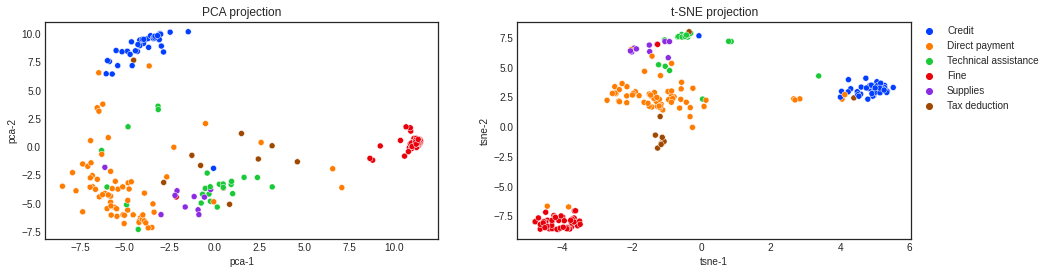

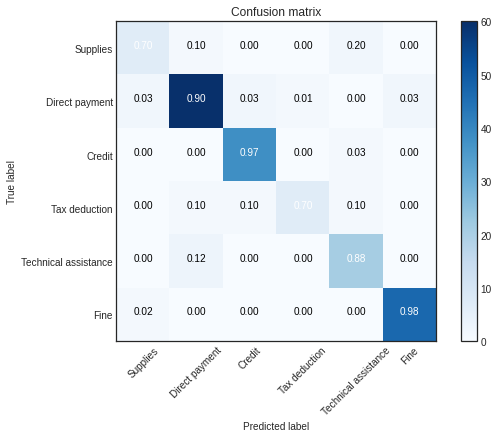

Macro/Weighted Avg F1-score: [0.860513951493333, 0.9082008140193083]




Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:  20%|██        | 2/10 [00:00<00:00, 14.17it/s]



Evaluating:  40%|████      | 4/10 [00:00<00:00, 14.41it/s]

Evaluating:  60%|██████    | 6/10 [00:00<00:00, 14.58it/s]

Evaluating:  80%|████████  | 8/10 [00:00<00:00, 14.54it/s]

Evaluating: 100%|██████████| 10/10 [00:00<00:00, 15.15it/s]




Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:  30%|███       | 3/10 [00:00<00:00, 20.01it/s]



Evaluating:  50%|█████     | 5/10 [00:00<00:00, 17.52it/s]

Evaluating:  70%|███████   | 7/10 [00:00<00:00, 16.10it/s]

Evaluating: 100%|██████████| 10/10 [00:00<00:00, 15.41it/s]

  1%|          | 5/788 [00:00<00:16, 46.26it/s]


Time taken for fine-tuning: 00:00:19.49
Classifying sentences...



100%|██████████| 788/788 [00:14<00:00, 54.64it/s]

100%|██████████| 198/198 [00:03<00:00, 55.14it/s]


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 198 samples in 0.000s...
[t-SNE] Computed neighbors for 198 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 198 / 198
[t-SNE] Mean sigma: 5.608812
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.931473
[t-SNE] KL divergence after 800 iterations: 0.112388
Evaluating predictions...
                      precision    recall  f1-score   support

              Credit       0.95      0.97      0.96        39
      Direct payment       0.90      0.91      0.90        67
                Fine       0.98      0.98      0.98        48
            Supplies       0.78      0.70      0.74        10
       Tax deduction       0.83      0.50      0.62        10
Technical assistance       0.74      0.83      0.78        24

            accuracy                           0.90       198
           macro avg       0.86      0.82      0.83       198
        weighted avg       0.90      0.90      0.9

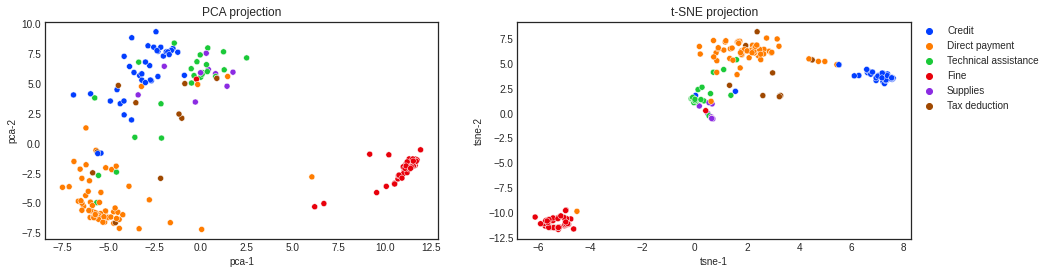

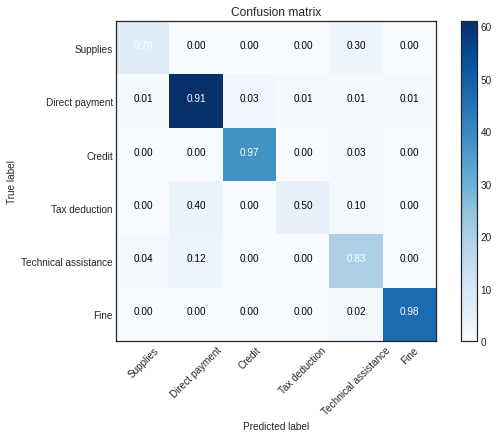

Macro/Weighted Avg F1-score: [0.8318419195965702, 0.8965105351228109]




Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:  20%|██        | 2/10 [00:00<00:00, 15.94it/s]



Evaluating:  40%|████      | 4/10 [00:00<00:00, 15.99it/s]

Evaluating:  60%|██████    | 6/10 [00:00<00:00, 15.16it/s]

Evaluating:  80%|████████  | 8/10 [00:00<00:00, 15.50it/s]

Evaluating: 100%|██████████| 10/10 [00:00<00:00, 15.61it/s]




Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:  20%|██        | 2/10 [00:00<00:00, 14.71it/s]



Evaluating:  40%|████      | 4/10 [00:00<00:00, 14.29it/s]

Evaluating:  60%|██████    | 6/10 [00:00<00:00, 14.46it/s]

Evaluating:  80%|████████  | 8/10 [00:00<00:00, 14.92it/s]

Evaluating: 100%|██████████| 10/10 [00:00<00:00, 15.14it/s]

  1%|          | 5/788 [00:00<00:16, 47.33it/s]


Time taken for fine-tuning: 00:00:19.70
Classifying sentences...



100%|██████████| 788/788 [00:14<00:00, 54.49it/s]

100%|██████████| 198/198 [00:03<00:00, 54.77it/s]


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 198 samples in 0.004s...
[t-SNE] Computed neighbors for 198 samples in 0.010s...
[t-SNE] Computed conditional probabilities for sample 198 / 198
[t-SNE] Mean sigma: 5.516439
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.719795
[t-SNE] KL divergence after 1000 iterations: 0.108596
Evaluating predictions...
                      precision    recall  f1-score   support

              Credit       0.90      0.95      0.92        39
      Direct payment       0.91      0.90      0.90        67
                Fine       0.98      0.98      0.98        48
            Supplies       0.75      0.90      0.82        10
       Tax deduction       0.78      0.70      0.74        10
Technical assistance       0.86      0.79      0.83        24

            accuracy                           0.90       198
           macro avg       0.86      0.87      0.86       198
        weighted avg       0.90      0.90      0.

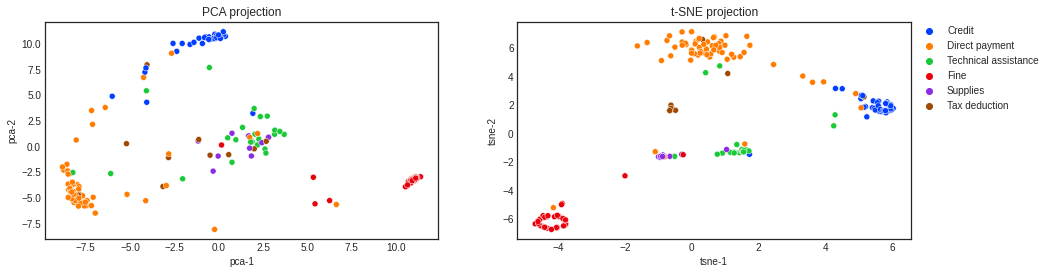

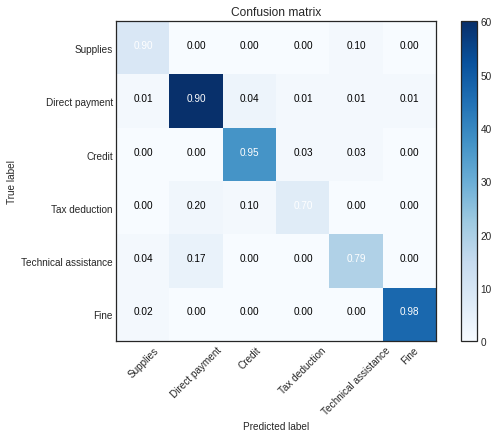

Macro/Weighted Avg F1-score: [0.8645888642885211, 0.9035477475278806]




Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:  20%|██        | 2/10 [00:00<00:00, 17.47it/s]



Evaluating:  40%|████      | 4/10 [00:00<00:00, 16.34it/s]

Evaluating:  60%|██████    | 6/10 [00:00<00:00, 15.64it/s]

Evaluating:  80%|████████  | 8/10 [00:00<00:00, 14.90it/s]

Evaluating: 100%|██████████| 10/10 [00:00<00:00, 15.40it/s]




Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:  20%|██        | 2/10 [00:00<00:00, 15.41it/s]



Evaluating:  40%|████      | 4/10 [00:00<00:00, 15.74it/s]

Evaluating:  60%|██████    | 6/10 [00:00<00:00, 15.69it/s]

Evaluating:  80%|████████  | 8/10 [00:00<00:00, 15.79it/s]

Evaluating: 100%|██████████| 10/10 [00:00<00:00, 15.49it/s]

  1%|          | 5/788 [00:00<00:16, 48.65it/s]


Time taken for fine-tuning: 00:00:19.50
Classifying sentences...



100%|██████████| 788/788 [00:14<00:00, 54.75it/s]

100%|██████████| 198/198 [00:03<00:00, 55.31it/s]


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 198 samples in 0.000s...
[t-SNE] Computed neighbors for 198 samples in 0.009s...
[t-SNE] Computed conditional probabilities for sample 198 / 198
[t-SNE] Mean sigma: 6.147036
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.526829
[t-SNE] KL divergence after 900 iterations: 0.094716
Evaluating predictions...
                      precision    recall  f1-score   support

              Credit       0.88      0.97      0.93        39
      Direct payment       0.90      0.84      0.87        67
                Fine       0.94      0.98      0.96        48
            Supplies       0.80      0.80      0.80        10
       Tax deduction       0.88      0.70      0.78        10
Technical assistance       0.80      0.83      0.82        24

            accuracy                           0.89       198
           macro avg       0.87      0.85      0.86       198
        weighted avg       0.89      0.89      0.8

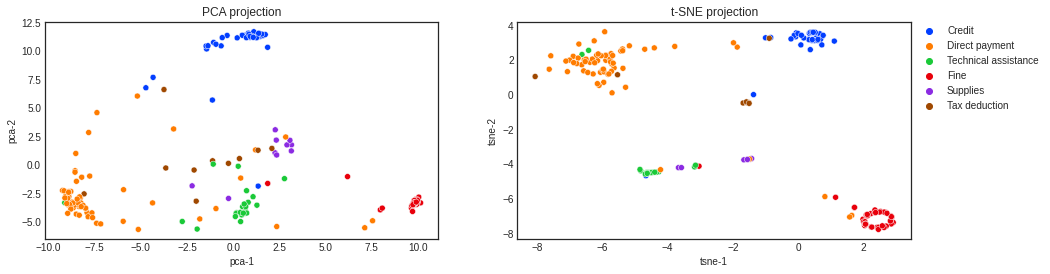

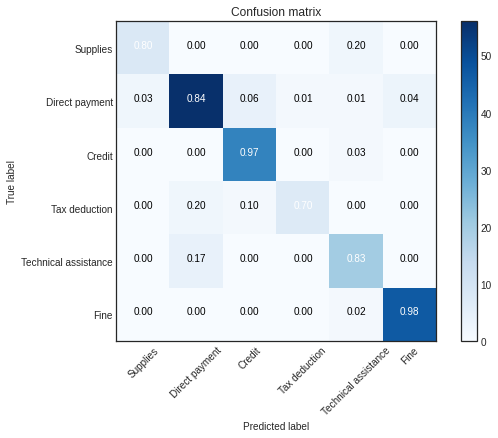

Macro/Weighted Avg F1-score: [0.8580557174026099, 0.8875116916064435]




Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:  20%|██        | 2/10 [00:00<00:00, 15.49it/s]



Evaluating:  40%|████      | 4/10 [00:00<00:00, 15.17it/s]

Evaluating:  60%|██████    | 6/10 [00:00<00:00, 14.62it/s]

Evaluating:  80%|████████  | 8/10 [00:00<00:00, 14.89it/s]

Evaluating: 100%|██████████| 10/10 [00:00<00:00, 15.18it/s]




Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:  20%|██        | 2/10 [00:00<00:00, 17.88it/s]



Evaluating:  40%|████      | 4/10 [00:00<00:00, 16.64it/s]

Evaluating:  60%|██████    | 6/10 [00:00<00:00, 15.86it/s]

Evaluating:  80%|████████  | 8/10 [00:00<00:00, 16.68it/s]

Evaluating: 100%|██████████| 10/10 [00:00<00:00, 16.46it/s]

  1%|          | 5/788 [00:00<00:15, 48.97it/s]


Time taken for fine-tuning: 00:00:19.26
Classifying sentences...



100%|██████████| 788/788 [00:14<00:00, 54.48it/s]

100%|██████████| 198/198 [00:03<00:00, 55.11it/s]


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 198 samples in 0.000s...
[t-SNE] Computed neighbors for 198 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 198 / 198
[t-SNE] Mean sigma: 3.931881
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.809212
[t-SNE] KL divergence after 1000 iterations: 0.094401
Evaluating predictions...
                      precision    recall  f1-score   support

              Credit       0.93      0.97      0.95        39
      Direct payment       0.87      0.90      0.88        67
                Fine       0.98      0.98      0.98        48
            Supplies       0.80      0.80      0.80        10
       Tax deduction       0.86      0.60      0.71        10
Technical assistance       0.83      0.79      0.81        24

            accuracy                           0.90       198
           macro avg       0.88      0.84      0.85       198
        weighted avg       0.90      0.90      0.

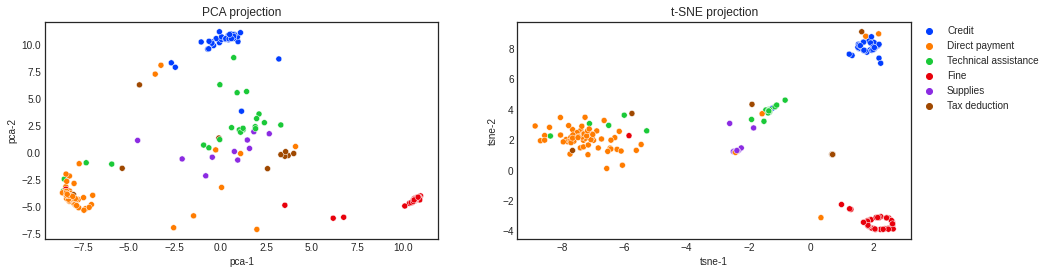

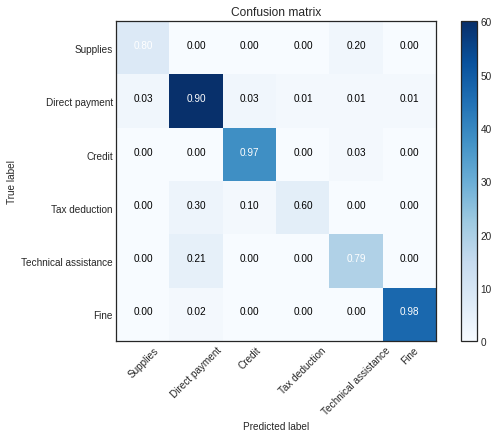

Macro/Weighted Avg F1-score: [0.8543187665136979, 0.8971248783201226]




Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:  20%|██        | 2/10 [00:00<00:00, 16.75it/s]



Evaluating:  40%|████      | 4/10 [00:00<00:00, 15.86it/s]

Evaluating:  60%|██████    | 6/10 [00:00<00:00, 15.90it/s]

Evaluating:  80%|████████  | 8/10 [00:00<00:00, 15.10it/s]

Evaluating: 100%|██████████| 10/10 [00:00<00:00, 15.41it/s]




Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:  20%|██        | 2/10 [00:00<00:00, 13.55it/s]



Evaluating:  40%|████      | 4/10 [00:00<00:00, 13.74it/s]

Evaluating:  60%|██████    | 6/10 [00:00<00:00, 15.09it/s]

Evaluating:  80%|████████  | 8/10 [00:00<00:00, 15.28it/s]

Evaluating: 100%|██████████| 10/10 [00:00<00:00, 15.57it/s]

  1%|          | 5/788 [00:00<00:16, 48.16it/s]


Time taken for fine-tuning: 00:00:19.27
Classifying sentences...



100%|██████████| 788/788 [00:14<00:00, 54.41it/s]

100%|██████████| 198/198 [00:03<00:00, 55.14it/s]


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 198 samples in 0.000s...
[t-SNE] Computed neighbors for 198 samples in 0.013s...
[t-SNE] Computed conditional probabilities for sample 198 / 198
[t-SNE] Mean sigma: 3.011600
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.050110
[t-SNE] KL divergence after 900 iterations: 0.097064
Evaluating predictions...
                      precision    recall  f1-score   support

              Credit       0.90      0.95      0.92        39
      Direct payment       0.88      0.90      0.89        67
                Fine       0.96      0.98      0.97        48
            Supplies       0.89      0.80      0.84        10
       Tax deduction       0.83      0.50      0.62        10
Technical assistance       0.80      0.83      0.82        24

            accuracy                           0.89       198
           macro avg       0.88      0.83      0.84       198
        weighted avg       0.89      0.89      0.8

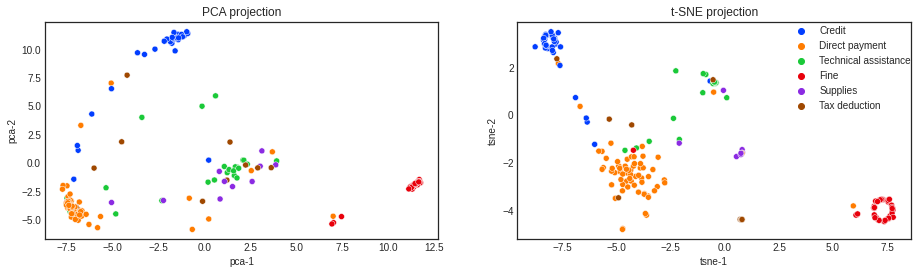

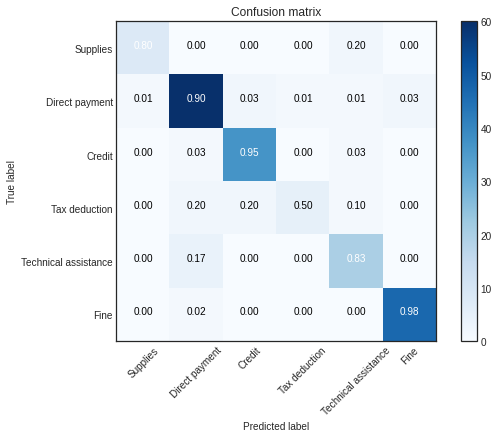

Macro/Weighted Avg F1-score: [0.8443988079345804, 0.8909540850472432]




Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:  15%|█▌        | 2/13 [00:00<00:00, 16.23it/s]



Evaluating:  31%|███       | 4/13 [00:00<00:00, 15.37it/s]

Evaluating:  46%|████▌     | 6/13 [00:00<00:00, 14.34it/s]

Evaluating:  62%|██████▏   | 8/13 [00:00<00:00, 14.22it/s]

Evaluating:  77%|███████▋  | 10/13 [00:00<00:00, 13.52it/s]

Evaluating: 100%|██████████| 13/13 [00:00<00:00, 14.14it/s]




Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:  15%|█▌        | 2/13 [00:00<00:00, 14.90it/s]



Evaluating:  31%|███       | 4/13 [00:00<00:00, 14.73it/s]

Evaluating:  46%|████▌     | 6/13 [00:00<00:00, 15.35it/s]

Evaluating:  62%|██████▏   | 8/13 [00:00<00:00, 14.66it/s]

Evaluating:  77%|███████▋  | 10/13 [00:00<00:00, 14.24it/s]

Evaluating: 100%|██████████| 13/13 [00:00<00:00, 15.19it/s]

  1%|          | 5/788 [00:00<00:15, 49.04it/s]


Time taken for fine-tuning: 00:00:19.09
Classifying sentences...



100%|██████████| 788/788 [00:14<00:00, 54.83it/s]

100%|██████████| 198/198 [00:03<00:00, 54.45it/s]


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 198 samples in 0.003s...
[t-SNE] Computed neighbors for 198 samples in 0.010s...
[t-SNE] Computed conditional probabilities for sample 198 / 198
[t-SNE] Mean sigma: 6.156813
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.209244
[t-SNE] KL divergence after 800 iterations: 0.173554
Evaluating predictions...
                      precision    recall  f1-score   support

              Credit       0.92      0.92      0.92        39
      Direct payment       0.90      0.91      0.90        67
                Fine       0.98      0.98      0.98        48
            Supplies       0.73      0.80      0.76        10
       Tax deduction       0.83      0.50      0.62        10
Technical assistance       0.81      0.88      0.84        24

            accuracy                           0.90       198
           macro avg       0.86      0.83      0.84       198
        weighted avg       0.90      0.90      0.9

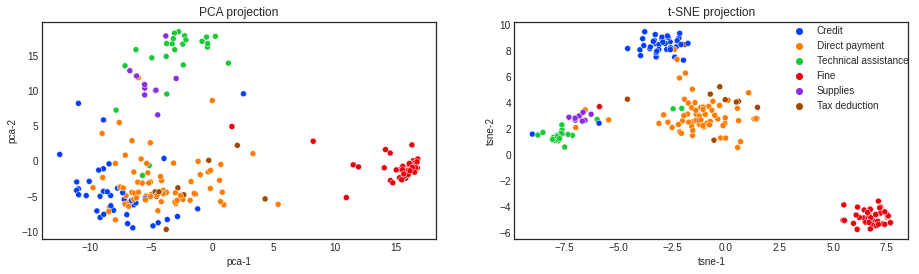

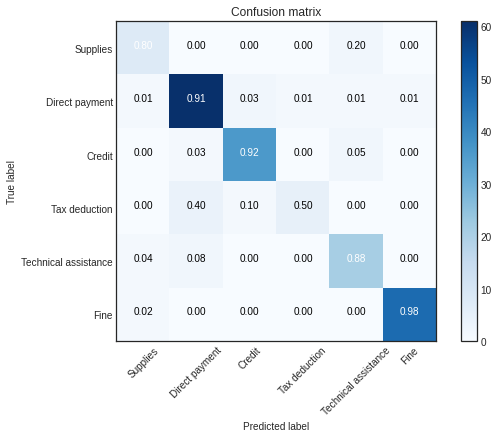

Macro/Weighted Avg F1-score: [0.8388086758920092, 0.8968545240767464]




Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:  15%|█▌        | 2/13 [00:00<00:00, 14.26it/s]



Evaluating:  31%|███       | 4/13 [00:00<00:00, 14.02it/s]

Evaluating:  54%|█████▍    | 7/13 [00:00<00:00, 15.16it/s]

Evaluating:  69%|██████▉   | 9/13 [00:00<00:00, 16.34it/s]

Evaluating:  85%|████████▍ | 11/13 [00:00<00:00, 15.41it/s]

Evaluating: 100%|██████████| 13/13 [00:00<00:00, 16.21it/s]




Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:  15%|█▌        | 2/13 [00:00<00:00, 13.51it/s]



Evaluating:  31%|███       | 4/13 [00:00<00:00, 14.79it/s]

Evaluating:  46%|████▌     | 6/13 [00:00<00:00, 15.55it/s]

Evaluating:  62%|██████▏   | 8/13 [00:00<00:00, 14.86it/s]

Evaluating:  77%|███████▋  | 10/13 [00:00<00:00, 15.20it/s]

Evaluating: 100%|██████████| 13/13 [00:00<00:00, 15.99it/s]

  1%|          | 6/788 [00:00<00:15, 51.90it/s]


Time taken for fine-tuning: 00:00:18.81
Classifying sentences...



100%|██████████| 788/788 [00:14<00:00, 54.86it/s]

100%|██████████| 198/198 [00:03<00:00, 55.37it/s]


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 198 samples in 0.000s...
[t-SNE] Computed neighbors for 198 samples in 0.013s...
[t-SNE] Computed conditional probabilities for sample 198 / 198
[t-SNE] Mean sigma: 7.850143
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.486008
[t-SNE] KL divergence after 1000 iterations: 0.161860
Evaluating predictions...
                      precision    recall  f1-score   support

              Credit       0.90      0.97      0.94        39
      Direct payment       0.89      0.87      0.88        67
                Fine       0.96      0.98      0.97        48
            Supplies       0.78      0.70      0.74        10
       Tax deduction       0.89      0.80      0.84        10
Technical assistance       0.88      0.88      0.88        24

            accuracy                           0.90       198
           macro avg       0.88      0.87      0.87       198
        weighted avg       0.90      0.90      0.

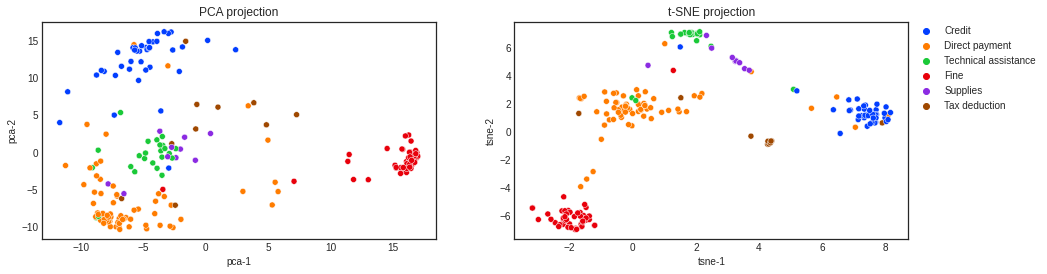

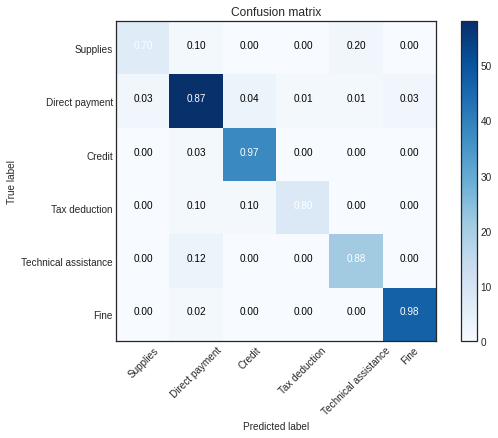

Macro/Weighted Avg F1-score: [0.8733465028492761, 0.9029106973389737]




Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:  23%|██▎       | 3/13 [00:00<00:00, 19.21it/s]



Evaluating:  38%|███▊      | 5/13 [00:00<00:00, 18.26it/s]

Evaluating:  54%|█████▍    | 7/13 [00:00<00:00, 16.50it/s]

Evaluating:  69%|██████▉   | 9/13 [00:00<00:00, 16.76it/s]

Evaluating: 100%|██████████| 13/13 [00:00<00:00, 17.09it/s]




Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:  15%|█▌        | 2/13 [00:00<00:00, 16.32it/s]



Evaluating:  31%|███       | 4/13 [00:00<00:00, 15.92it/s]

Evaluating:  46%|████▌     | 6/13 [00:00<00:00, 15.13it/s]

Evaluating:  62%|██████▏   | 8/13 [00:00<00:00, 15.34it/s]

Evaluating:  77%|███████▋  | 10/13 [00:00<00:00, 15.26it/s]

Evaluating: 100%|██████████| 13/13 [00:00<00:00, 16.02it/s]

  1%|          | 6/788 [00:00<00:15, 49.71it/s]


Time taken for fine-tuning: 00:00:18.46
Classifying sentences...



100%|██████████| 788/788 [00:14<00:00, 54.28it/s]

100%|██████████| 198/198 [00:03<00:00, 54.81it/s]


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 198 samples in 0.003s...
[t-SNE] Computed neighbors for 198 samples in 0.016s...
[t-SNE] Computed conditional probabilities for sample 198 / 198
[t-SNE] Mean sigma: 9.045292
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.476158
[t-SNE] KL divergence after 1000 iterations: 0.131472
Evaluating predictions...
                      precision    recall  f1-score   support

              Credit       0.95      0.92      0.94        39
      Direct payment       0.88      0.91      0.90        67
                Fine       0.96      1.00      0.98        48
            Supplies       0.70      0.70      0.70        10
       Tax deduction       0.75      0.60      0.67        10
Technical assistance       0.91      0.88      0.89        24

            accuracy                           0.90       198
           macro avg       0.86      0.83      0.85       198
        weighted avg       0.90      0.90      0.

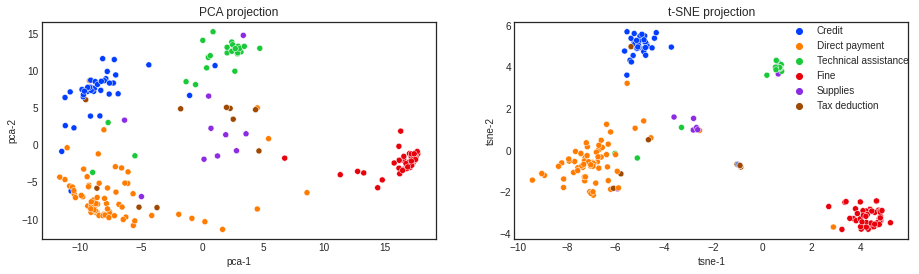

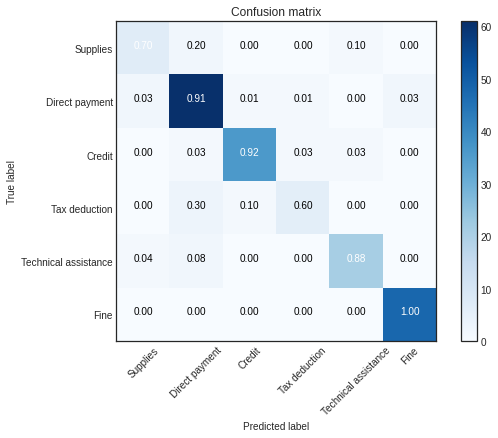

Macro/Weighted Avg F1-score: [0.8453332138787172, 0.902547257497845]




Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:  15%|█▌        | 2/13 [00:00<00:00, 13.73it/s]



Evaluating:  31%|███       | 4/13 [00:00<00:00, 13.63it/s]

Evaluating:  46%|████▌     | 6/13 [00:00<00:00, 13.90it/s]

Evaluating:  62%|██████▏   | 8/13 [00:00<00:00, 14.37it/s]

Evaluating:  77%|███████▋  | 10/13 [00:00<00:00, 15.07it/s]

Evaluating: 100%|██████████| 13/13 [00:00<00:00, 15.57it/s]




Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:  15%|█▌        | 2/13 [00:00<00:00, 13.65it/s]



Evaluating:  31%|███       | 4/13 [00:00<00:00, 13.94it/s]

Evaluating:  46%|████▌     | 6/13 [00:00<00:00, 14.48it/s]

Evaluating:  62%|██████▏   | 8/13 [00:00<00:00, 14.45it/s]

Evaluating:  77%|███████▋  | 10/13 [00:00<00:00, 14.90it/s]

Evaluating: 100%|██████████| 13/13 [00:00<00:00, 15.89it/s]

  1%|          | 6/788 [00:00<00:14, 52.21it/s]


Time taken for fine-tuning: 00:00:18.55
Classifying sentences...



100%|██████████| 788/788 [00:14<00:00, 54.99it/s]

100%|██████████| 198/198 [00:03<00:00, 54.24it/s]


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 198 samples in 0.000s...
[t-SNE] Computed neighbors for 198 samples in 0.010s...
[t-SNE] Computed conditional probabilities for sample 198 / 198
[t-SNE] Mean sigma: 8.700354
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.214066
[t-SNE] KL divergence after 900 iterations: 0.132991
Evaluating predictions...
                      precision    recall  f1-score   support

              Credit       0.92      0.92      0.92        39
      Direct payment       0.88      0.91      0.90        67
                Fine       0.98      0.96      0.97        48
            Supplies       0.78      0.70      0.74        10
       Tax deduction       0.86      0.60      0.71        10
Technical assistance       0.78      0.88      0.82        24

            accuracy                           0.89       198
           macro avg       0.87      0.83      0.84       198
        weighted avg       0.90      0.89      0.8

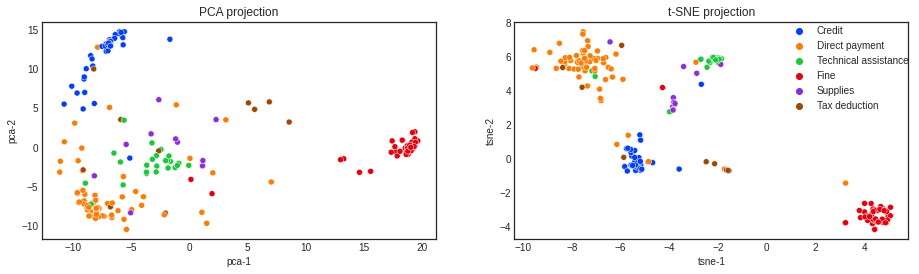

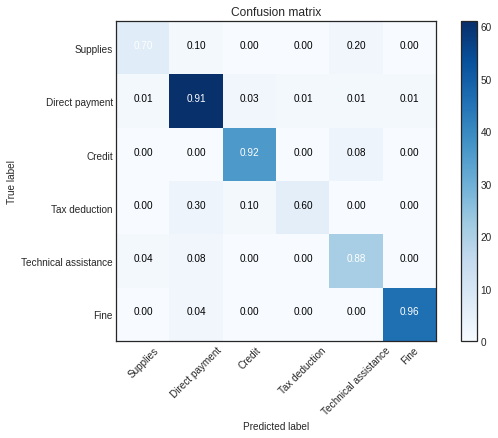

Macro/Weighted Avg F1-score: [0.8424684448678258, 0.8928237483191044]




Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:  15%|█▌        | 2/13 [00:00<00:00, 13.68it/s]



Evaluating:  31%|███       | 4/13 [00:00<00:00, 14.24it/s]

Evaluating:  46%|████▌     | 6/13 [00:00<00:00, 14.96it/s]

Evaluating:  62%|██████▏   | 8/13 [00:00<00:00, 15.28it/s]

Evaluating:  77%|███████▋  | 10/13 [00:00<00:00, 14.70it/s]

Evaluating: 100%|██████████| 13/13 [00:00<00:00, 16.23it/s]




Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:  15%|█▌        | 2/13 [00:00<00:00, 13.67it/s]



Evaluating:  31%|███       | 4/13 [00:00<00:00, 14.05it/s]

Evaluating:  46%|████▌     | 6/13 [00:00<00:00, 13.90it/s]

Evaluating:  62%|██████▏   | 8/13 [00:00<00:00, 13.79it/s]

Evaluating:  77%|███████▋  | 10/13 [00:00<00:00, 14.89it/s]

Evaluating: 100%|██████████| 13/13 [00:00<00:00, 15.26it/s]

  1%|          | 5/788 [00:00<00:15, 49.69it/s]


Time taken for fine-tuning: 00:00:18.68
Classifying sentences...



100%|██████████| 788/788 [00:14<00:00, 54.53it/s]

100%|██████████| 198/198 [00:03<00:00, 54.97it/s]


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 198 samples in 0.000s...
[t-SNE] Computed neighbors for 198 samples in 0.008s...
[t-SNE] Computed conditional probabilities for sample 198 / 198
[t-SNE] Mean sigma: 8.300898
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.325722
[t-SNE] KL divergence after 800 iterations: 0.136548
Evaluating predictions...
                      precision    recall  f1-score   support

              Credit       0.94      0.85      0.89        39
      Direct payment       0.86      0.93      0.89        67
                Fine       0.98      1.00      0.99        48
            Supplies       0.88      0.70      0.78        10
       Tax deduction       0.71      0.50      0.59        10
Technical assistance       0.78      0.88      0.82        24

            accuracy                           0.89       198
           macro avg       0.86      0.81      0.83       198
        weighted avg       0.89      0.89      0.8

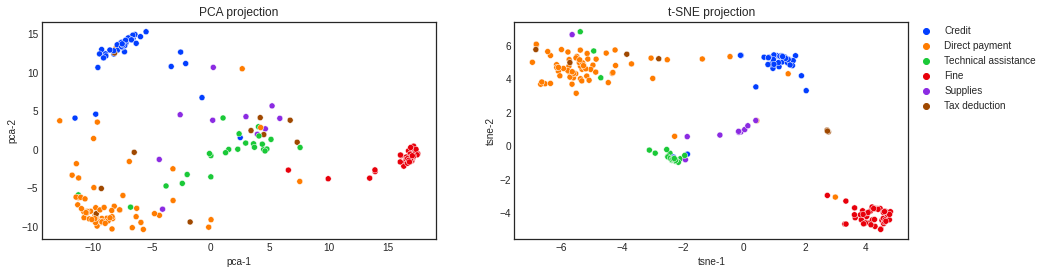

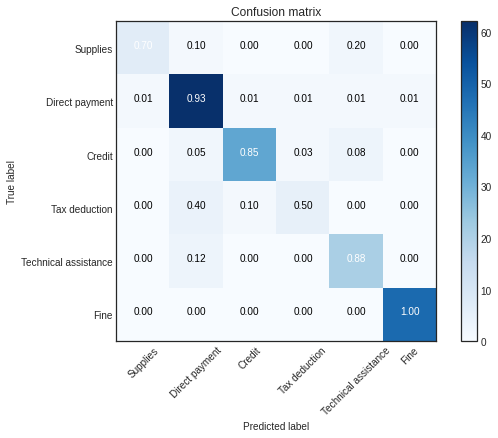

Macro/Weighted Avg F1-score: [0.8272019046894599, 0.8862806020046875]




Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:  15%|█▌        | 2/13 [00:00<00:00, 14.06it/s]



Evaluating:  31%|███       | 4/13 [00:00<00:00, 14.94it/s]

Evaluating:  46%|████▌     | 6/13 [00:00<00:00, 14.51it/s]

Evaluating:  62%|██████▏   | 8/13 [00:00<00:00, 14.22it/s]

Evaluating:  77%|███████▋  | 10/13 [00:00<00:00, 14.01it/s]

Evaluating: 100%|██████████| 13/13 [00:00<00:00, 15.34it/s]




Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:  15%|█▌        | 2/13 [00:00<00:00, 19.50it/s]



Evaluating:  31%|███       | 4/13 [00:00<00:00, 18.35it/s]

Evaluating:  46%|████▌     | 6/13 [00:00<00:00, 16.53it/s]

Evaluating:  62%|██████▏   | 8/13 [00:00<00:00, 15.52it/s]

Evaluating:  77%|███████▋  | 10/13 [00:00<00:00, 15.77it/s]

Evaluating: 100%|██████████| 13/13 [00:00<00:00, 15.93it/s]

  1%|          | 6/788 [00:00<00:15, 51.93it/s]


Time taken for fine-tuning: 00:00:18.42
Classifying sentences...



100%|██████████| 788/788 [00:14<00:00, 54.85it/s]

100%|██████████| 198/198 [00:03<00:00, 54.78it/s]


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 198 samples in 0.000s...
[t-SNE] Computed neighbors for 198 samples in 0.010s...
[t-SNE] Computed conditional probabilities for sample 198 / 198
[t-SNE] Mean sigma: 7.854070
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.243942
[t-SNE] KL divergence after 1000 iterations: 0.114952
Evaluating predictions...
                      precision    recall  f1-score   support

              Credit       0.95      0.92      0.94        39
      Direct payment       0.88      0.94      0.91        67
                Fine       0.98      0.98      0.98        48
            Supplies       0.78      0.70      0.74        10
       Tax deduction       0.83      0.50      0.62        10
Technical assistance       0.84      0.88      0.86        24

            accuracy                           0.90       198
           macro avg       0.88      0.82      0.84       198
        weighted avg       0.90      0.90      0.

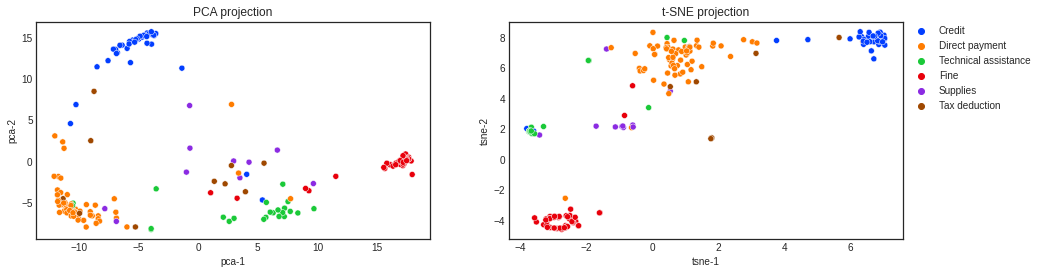

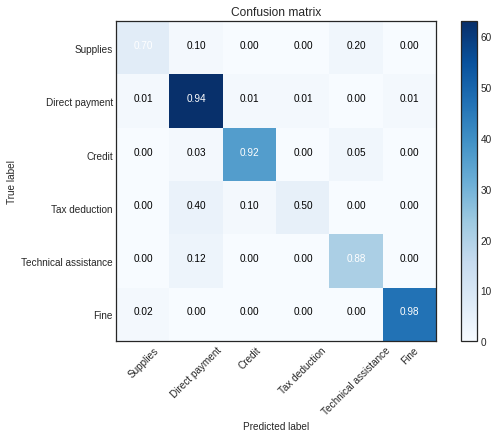

Macro/Weighted Avg F1-score: [0.8399485640469169, 0.9009656315213784]




Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:  15%|█▌        | 2/13 [00:00<00:00, 13.46it/s]



Evaluating:  31%|███       | 4/13 [00:00<00:00, 14.47it/s]

Evaluating:  46%|████▌     | 6/13 [00:00<00:00, 14.57it/s]

Evaluating:  62%|██████▏   | 8/13 [00:00<00:00, 14.48it/s]

Evaluating:  77%|███████▋  | 10/13 [00:00<00:00, 14.17it/s]

Evaluating: 100%|██████████| 13/13 [00:00<00:00, 15.39it/s]




Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:  15%|█▌        | 2/13 [00:00<00:00, 14.77it/s]



Evaluating:  31%|███       | 4/13 [00:00<00:00, 15.91it/s]

Evaluating:  46%|████▌     | 6/13 [00:00<00:00, 15.62it/s]

Evaluating:  62%|██████▏   | 8/13 [00:00<00:00, 15.23it/s]

Evaluating:  77%|███████▋  | 10/13 [00:00<00:00, 14.70it/s]

Evaluating: 100%|██████████| 13/13 [00:00<00:00, 16.09it/s]

  1%|          | 5/788 [00:00<00:15, 49.36it/s]


Time taken for fine-tuning: 00:00:18.80
Classifying sentences...



100%|██████████| 788/788 [00:14<00:00, 55.13it/s]

100%|██████████| 198/198 [00:03<00:00, 54.35it/s]


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 198 samples in 0.000s...
[t-SNE] Computed neighbors for 198 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 198 / 198
[t-SNE] Mean sigma: 5.450580
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.306202
[t-SNE] KL divergence after 850 iterations: 0.093083
Evaluating predictions...
                      precision    recall  f1-score   support

              Credit       1.00      0.92      0.96        39
      Direct payment       0.91      0.93      0.92        67
                Fine       0.96      0.98      0.97        48
            Supplies       0.89      0.80      0.84        10
       Tax deduction       0.75      0.60      0.67        10
Technical assistance       0.79      0.92      0.85        24

            accuracy                           0.91       198
           macro avg       0.88      0.86      0.87       198
        weighted avg       0.92      0.91      0.9

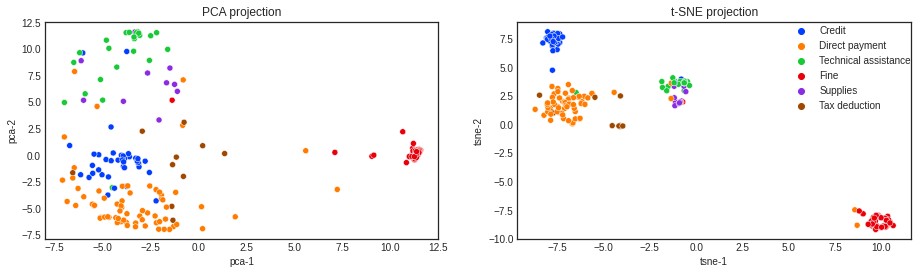

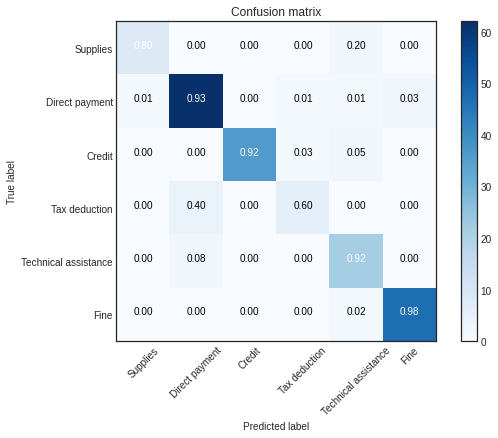

Macro/Weighted Avg F1-score: [0.86708607657423, 0.9135940215363861]




Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:  15%|█▌        | 2/13 [00:00<00:00, 15.04it/s]



Evaluating:  31%|███       | 4/13 [00:00<00:00, 15.01it/s]

Evaluating:  46%|████▌     | 6/13 [00:00<00:00, 14.54it/s]

Evaluating:  62%|██████▏   | 8/13 [00:00<00:00, 14.58it/s]

Evaluating:  77%|███████▋  | 10/13 [00:00<00:00, 14.19it/s]

Evaluating: 100%|██████████| 13/13 [00:00<00:00, 14.96it/s]




Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:  15%|█▌        | 2/13 [00:00<00:00, 18.13it/s]



Evaluating:  31%|███       | 4/13 [00:00<00:00, 17.63it/s]

Evaluating:  46%|████▌     | 6/13 [00:00<00:00, 16.11it/s]

Evaluating:  62%|██████▏   | 8/13 [00:00<00:00, 15.96it/s]

Evaluating:  77%|███████▋  | 10/13 [00:00<00:00, 15.67it/s]

Evaluating: 100%|██████████| 13/13 [00:00<00:00, 15.83it/s]

  1%|          | 5/788 [00:00<00:16, 46.54it/s]


Time taken for fine-tuning: 00:00:18.69
Classifying sentences...



100%|██████████| 788/788 [00:14<00:00, 55.03it/s]

100%|██████████| 198/198 [00:03<00:00, 54.76it/s]


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 198 samples in 0.003s...
[t-SNE] Computed neighbors for 198 samples in 0.011s...
[t-SNE] Computed conditional probabilities for sample 198 / 198
[t-SNE] Mean sigma: 6.089330
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.105515
[t-SNE] KL divergence after 1000 iterations: 0.127612
Evaluating predictions...
                      precision    recall  f1-score   support

              Credit       0.97      0.92      0.95        39
      Direct payment       0.91      0.90      0.90        67
                Fine       0.94      0.98      0.96        48
            Supplies       0.89      0.80      0.84        10
       Tax deduction       0.88      0.70      0.78        10
Technical assistance       0.79      0.92      0.85        24

            accuracy                           0.91       198
           macro avg       0.90      0.87      0.88       198
        weighted avg       0.91      0.91      0.

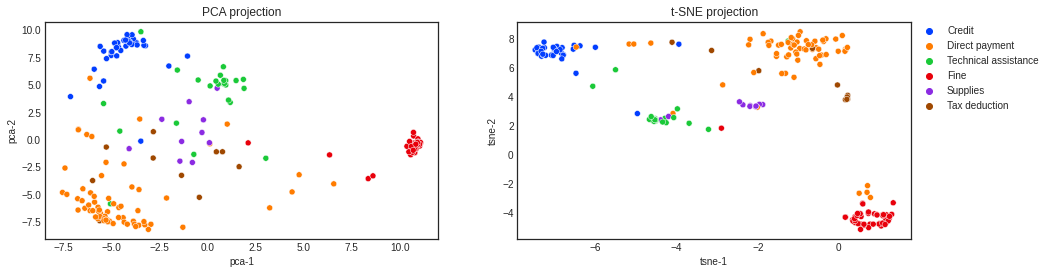

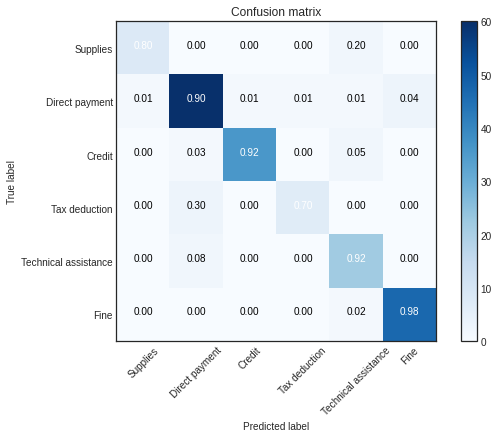

Macro/Weighted Avg F1-score: [0.8791407701182136, 0.9088173499201068]




Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:  15%|█▌        | 2/13 [00:00<00:00, 18.43it/s]



Evaluating:  31%|███       | 4/13 [00:00<00:00, 17.58it/s]

Evaluating:  46%|████▌     | 6/13 [00:00<00:00, 16.06it/s]

Evaluating:  62%|██████▏   | 8/13 [00:00<00:00, 15.64it/s]

Evaluating:  77%|███████▋  | 10/13 [00:00<00:00, 15.36it/s]

Evaluating: 100%|██████████| 13/13 [00:00<00:00, 15.63it/s]




Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:  15%|█▌        | 2/13 [00:00<00:00, 17.91it/s]



Evaluating:  31%|███       | 4/13 [00:00<00:00, 16.22it/s]

Evaluating:  46%|████▌     | 6/13 [00:00<00:00, 16.24it/s]

Evaluating:  62%|██████▏   | 8/13 [00:00<00:00, 15.82it/s]

Evaluating:  77%|███████▋  | 10/13 [00:00<00:00, 14.96it/s]

Evaluating: 100%|██████████| 13/13 [00:00<00:00, 15.44it/s]

  1%|          | 5/788 [00:00<00:16, 48.48it/s]


Time taken for fine-tuning: 00:00:18.71
Classifying sentences...



100%|██████████| 788/788 [00:14<00:00, 53.15it/s]

100%|██████████| 198/198 [00:03<00:00, 53.33it/s]


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 198 samples in 0.000s...
[t-SNE] Computed neighbors for 198 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 198 / 198
[t-SNE] Mean sigma: 5.895890
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.145065
[t-SNE] KL divergence after 900 iterations: 0.111124
Evaluating predictions...
                      precision    recall  f1-score   support

              Credit       0.97      0.92      0.95        39
      Direct payment       0.88      0.90      0.89        67
                Fine       0.94      0.98      0.96        48
            Supplies       0.88      0.70      0.78        10
       Tax deduction       0.75      0.60      0.67        10
Technical assistance       0.78      0.88      0.82        24

            accuracy                           0.89       198
           macro avg       0.87      0.83      0.84       198
        weighted avg       0.89      0.89      0.8

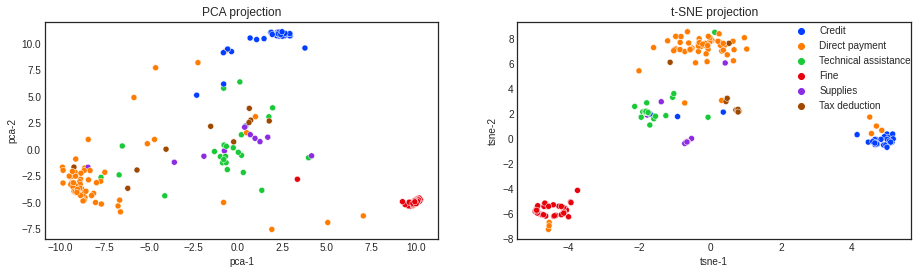

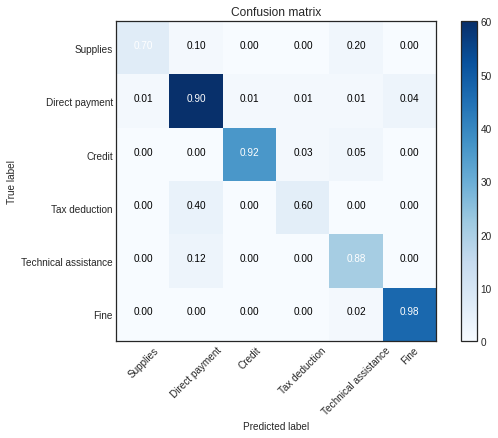

Macro/Weighted Avg F1-score: [0.8439024732700098, 0.8926913668178595]




Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:  15%|█▌        | 2/13 [00:00<00:00, 13.44it/s]



Evaluating:  31%|███       | 4/13 [00:00<00:00, 14.39it/s]

Evaluating:  46%|████▌     | 6/13 [00:00<00:00, 14.01it/s]

Evaluating:  62%|██████▏   | 8/13 [00:00<00:00, 14.97it/s]

Evaluating:  77%|███████▋  | 10/13 [00:00<00:00, 14.69it/s]

Evaluating: 100%|██████████| 13/13 [00:00<00:00, 15.31it/s]




Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:  15%|█▌        | 2/13 [00:00<00:00, 16.32it/s]



Evaluating:  31%|███       | 4/13 [00:00<00:00, 16.55it/s]

Evaluating:  46%|████▌     | 6/13 [00:00<00:00, 15.80it/s]

Evaluating:  62%|██████▏   | 8/13 [00:00<00:00, 15.33it/s]

Evaluating:  77%|███████▋  | 10/13 [00:00<00:00, 14.64it/s]

Evaluating: 100%|██████████| 13/13 [00:00<00:00, 16.54it/s]

  1%|          | 5/788 [00:00<00:16, 46.79it/s]


Time taken for fine-tuning: 00:00:18.74
Classifying sentences...



100%|██████████| 788/788 [00:14<00:00, 53.74it/s]

100%|██████████| 198/198 [00:03<00:00, 54.02it/s]


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 198 samples in 0.000s...
[t-SNE] Computed neighbors for 198 samples in 0.010s...
[t-SNE] Computed conditional probabilities for sample 198 / 198
[t-SNE] Mean sigma: 5.852275
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.610680
[t-SNE] KL divergence after 1000 iterations: 0.118991
Evaluating predictions...
                      precision    recall  f1-score   support

              Credit       0.93      0.95      0.94        39
      Direct payment       0.86      0.88      0.87        67
                Fine       0.96      0.94      0.95        48
            Supplies       0.89      0.80      0.84        10
       Tax deduction       0.50      0.60      0.55        10
Technical assistance       0.90      0.79      0.84        24

            accuracy                           0.88       198
           macro avg       0.84      0.83      0.83       198
        weighted avg       0.88      0.88      0.

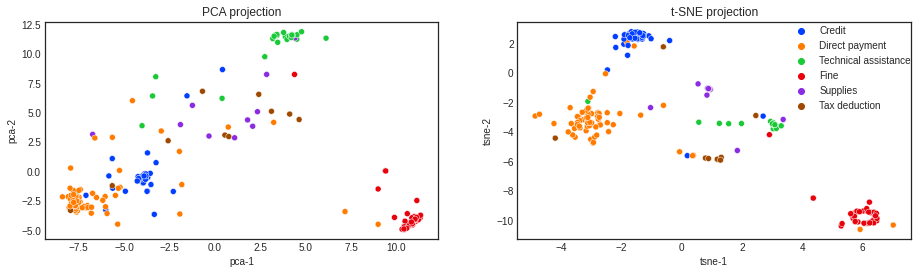

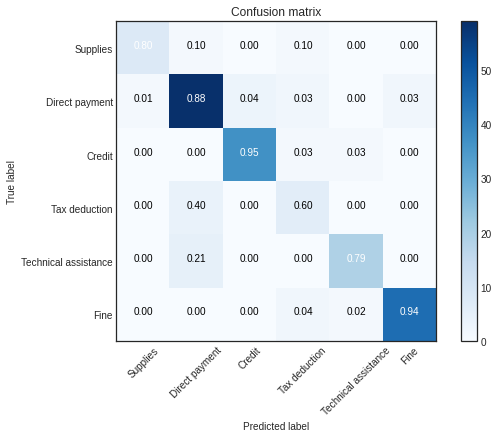

Macro/Weighted Avg F1-score: [0.83062143228209, 0.8802017549197683]




Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:  15%|█▌        | 2/13 [00:00<00:00, 15.25it/s]



Evaluating:  31%|███       | 4/13 [00:00<00:00, 15.26it/s]

Evaluating:  46%|████▌     | 6/13 [00:00<00:00, 15.55it/s]

Evaluating:  62%|██████▏   | 8/13 [00:00<00:00, 15.33it/s]

Evaluating: 100%|██████████| 13/13 [00:00<00:00, 17.06it/s]




Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:  15%|█▌        | 2/13 [00:00<00:00, 14.95it/s]



Evaluating:  31%|███       | 4/13 [00:00<00:00, 15.07it/s]

Evaluating:  46%|████▌     | 6/13 [00:00<00:00, 15.70it/s]

Evaluating:  62%|██████▏   | 8/13 [00:00<00:00, 14.90it/s]

Evaluating:  77%|███████▋  | 10/13 [00:00<00:00, 14.44it/s]

Evaluating: 100%|██████████| 13/13 [00:00<00:00, 15.67it/s]

  1%|          | 6/788 [00:00<00:15, 51.79it/s]


Time taken for fine-tuning: 00:00:18.25
Classifying sentences...



100%|██████████| 788/788 [00:14<00:00, 54.78it/s]

100%|██████████| 198/198 [00:03<00:00, 55.11it/s]


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 198 samples in 0.003s...
[t-SNE] Computed neighbors for 198 samples in 0.009s...
[t-SNE] Computed conditional probabilities for sample 198 / 198
[t-SNE] Mean sigma: 5.075575
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.020363
[t-SNE] KL divergence after 1000 iterations: 0.094013
Evaluating predictions...
                      precision    recall  f1-score   support

              Credit       0.93      0.95      0.94        39
      Direct payment       0.88      0.90      0.89        67
                Fine       0.98      0.94      0.96        48
            Supplies       0.78      0.70      0.74        10
       Tax deduction       0.67      0.60      0.63        10
Technical assistance       0.81      0.88      0.84        24

            accuracy                           0.89       198
           macro avg       0.84      0.83      0.83       198
        weighted avg       0.89      0.89      0.

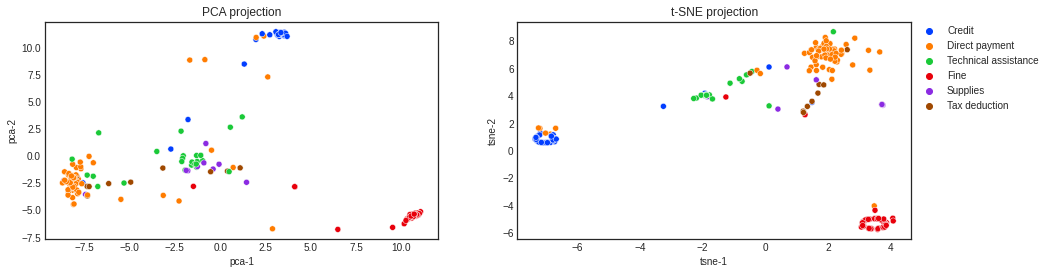

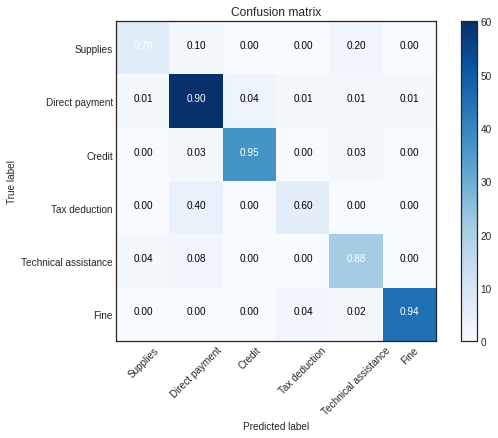

Macro/Weighted Avg F1-score: [0.8319109351317665, 0.8883275679798093]




Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:  15%|█▌        | 2/13 [00:00<00:00, 17.29it/s]



Evaluating:  31%|███       | 4/13 [00:00<00:00, 15.97it/s]

Evaluating:  46%|████▌     | 6/13 [00:00<00:00, 15.32it/s]

Evaluating:  62%|██████▏   | 8/13 [00:00<00:00, 15.59it/s]

Evaluating:  77%|███████▋  | 10/13 [00:00<00:00, 15.49it/s]

Evaluating: 100%|██████████| 13/13 [00:00<00:00, 15.90it/s]




Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:  15%|█▌        | 2/13 [00:00<00:00, 15.33it/s]



Evaluating:  31%|███       | 4/13 [00:00<00:00, 14.75it/s]

Evaluating:  46%|████▌     | 6/13 [00:00<00:00, 14.36it/s]

Evaluating:  62%|██████▏   | 8/13 [00:00<00:00, 14.66it/s]

Evaluating:  77%|███████▋  | 10/13 [00:00<00:00, 15.56it/s]

Evaluating: 100%|██████████| 13/13 [00:00<00:00, 15.37it/s]

  1%|          | 5/788 [00:00<00:16, 47.68it/s]


Time taken for fine-tuning: 00:00:18.41
Classifying sentences...



100%|██████████| 788/788 [00:14<00:00, 55.14it/s]

100%|██████████| 198/198 [00:03<00:00, 54.66it/s]


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 198 samples in 0.001s...
[t-SNE] Computed neighbors for 198 samples in 0.010s...
[t-SNE] Computed conditional probabilities for sample 198 / 198
[t-SNE] Mean sigma: 5.497106
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.416943
[t-SNE] KL divergence after 900 iterations: 0.081201
Evaluating predictions...
                      precision    recall  f1-score   support

              Credit       0.88      0.97      0.93        39
      Direct payment       0.85      0.85      0.85        67
                Fine       0.98      0.98      0.98        48
            Supplies       0.75      0.90      0.82        10
       Tax deduction       0.86      0.60      0.71        10
Technical assistance       0.90      0.79      0.84        24

            accuracy                           0.89       198
           macro avg       0.87      0.85      0.85       198
        weighted avg       0.89      0.89      0.8

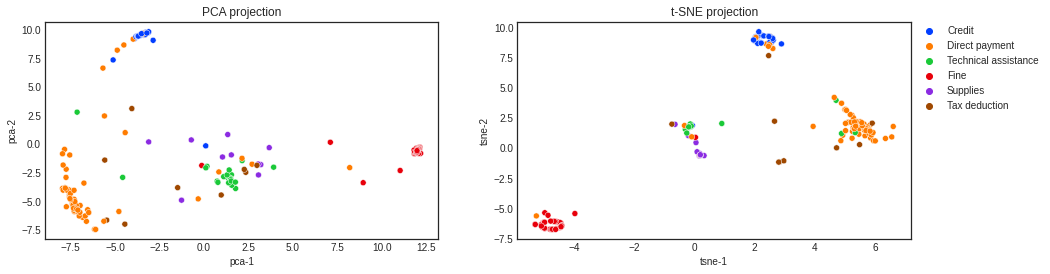

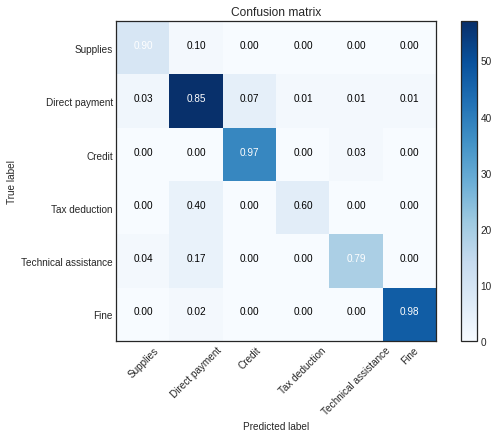

Macro/Weighted Avg F1-score: [0.8542084698639175, 0.8871396456631883]




Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Evaluating:  13%|█▎        | 2/15 [00:00<00:00, 13.45it/s]



Evaluating:  27%|██▋       | 4/15 [00:00<00:00, 14.13it/s]

Evaluating:  40%|████      | 6/15 [00:00<00:00, 14.25it/s]

Evaluating:  53%|█████▎    | 8/15 [00:00<00:00, 13.80it/s]

Evaluating:  67%|██████▋   | 10/15 [00:00<00:00, 14.50it/s]

Evaluating:  80%|████████  | 12/15 [00:00<00:00, 14.40it/s]

Evaluating: 100%|██████████| 15/15 [00:01<00:00, 14.29it/s]




Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Evaluating:  13%|█▎        | 2/15 [00:00<00:00, 14.37it/s]



Evaluating:  27%|██▋       | 4/15 [00:00<00:00, 14.85it/s]

Evaluating:  40%|████      | 6/15 [00:00<00:00, 15.04it/s]

Evaluating:  53%|█████▎    | 8/15 [00:00<00:00, 14.79it/s]

Evaluating:  67%|██████▋   | 10/15 [00:00<00:00, 14.59it/s]

Evaluating:  80%|████████  | 12/15 [00:00<00:00, 15.02it/s]

Evaluating: 100%|██████████| 15/15 [00:00<00:00, 15.16it/s]

  1%|          | 5/788 [00:00<00:15, 49.62it/s]


Time taken for fine-tuning: 00:00:18.34
Classifying sentences...



100%|██████████| 788/788 [00:14<00:00, 54.91it/s]

100%|██████████| 198/198 [00:03<00:00, 55.11it/s]


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 198 samples in 0.000s...
[t-SNE] Computed neighbors for 198 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 198 / 198
[t-SNE] Mean sigma: 8.487700
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.727150
[t-SNE] KL divergence after 1000 iterations: 0.129454
Evaluating predictions...
                      precision    recall  f1-score   support

              Credit       0.92      0.90      0.91        39
      Direct payment       0.86      0.93      0.89        67
                Fine       0.98      0.98      0.98        48
            Supplies       0.70      0.70      0.70        10
       Tax deduction       0.83      0.50      0.62        10
Technical assistance       0.88      0.88      0.88        24

            accuracy                           0.89       198
           macro avg       0.86      0.81      0.83       198
        weighted avg       0.89      0.89      0.

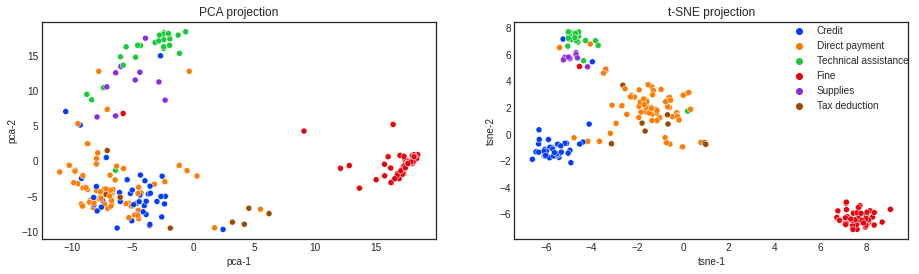

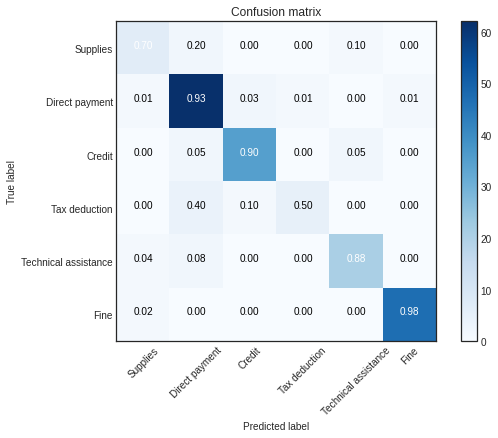

Macro/Weighted Avg F1-score: [0.830057317782138, 0.8912844930667038]




Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Evaluating:  13%|█▎        | 2/15 [00:00<00:00, 15.24it/s]



Evaluating:  27%|██▋       | 4/15 [00:00<00:00, 15.13it/s]

Evaluating:  40%|████      | 6/15 [00:00<00:00, 15.31it/s]

Evaluating:  53%|█████▎    | 8/15 [00:00<00:00, 15.18it/s]

Evaluating:  67%|██████▋   | 10/15 [00:00<00:00, 15.58it/s]

Evaluating:  80%|████████  | 12/15 [00:00<00:00, 14.91it/s]

Evaluating: 100%|██████████| 15/15 [00:00<00:00, 15.41it/s]




Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Evaluating:  13%|█▎        | 2/15 [00:00<00:00, 15.06it/s]



Evaluating:  27%|██▋       | 4/15 [00:00<00:00, 16.02it/s]

Evaluating:  40%|████      | 6/15 [00:00<00:00, 15.90it/s]

Evaluating:  53%|█████▎    | 8/15 [00:00<00:00, 15.42it/s]

Evaluating:  67%|██████▋   | 10/15 [00:00<00:00, 15.30it/s]

Evaluating:  80%|████████  | 12/15 [00:00<00:00, 15.90it/s]

Evaluating: 100%|██████████| 15/15 [00:00<00:00, 15.88it/s]

  1%|          | 6/788 [00:00<00:15, 51.78it/s]


Time taken for fine-tuning: 00:00:17.98
Classifying sentences...



100%|██████████| 788/788 [00:14<00:00, 54.81it/s]

100%|██████████| 198/198 [00:03<00:00, 53.54it/s]


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 198 samples in 0.000s...
[t-SNE] Computed neighbors for 198 samples in 0.008s...
[t-SNE] Computed conditional probabilities for sample 198 / 198
[t-SNE] Mean sigma: 9.076960
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.297718
[t-SNE] KL divergence after 800 iterations: 0.123010
Evaluating predictions...
                      precision    recall  f1-score   support

              Credit       0.88      0.92      0.90        39
      Direct payment       0.90      0.90      0.90        67
                Fine       1.00      0.98      0.99        48
            Supplies       0.73      0.80      0.76        10
       Tax deduction       0.86      0.60      0.71        10
Technical assistance       0.84      0.88      0.86        24

            accuracy                           0.90       198
           macro avg       0.87      0.85      0.85       198
        weighted avg       0.90      0.90      0.9

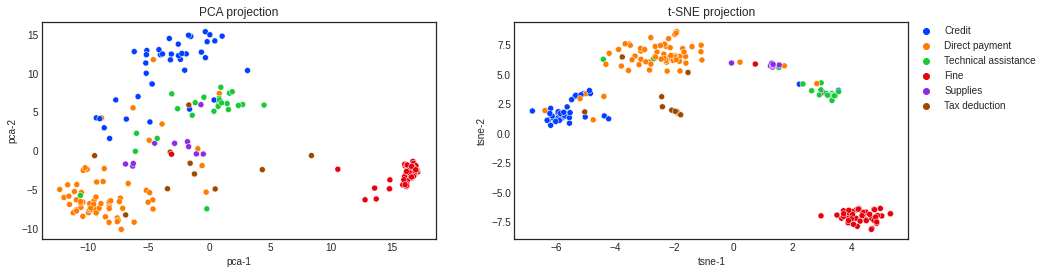

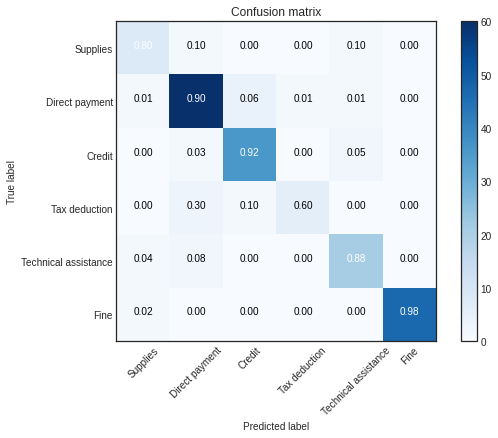

Macro/Weighted Avg F1-score: [0.8516543407098375, 0.8982022048585516]




Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Evaluating:  13%|█▎        | 2/15 [00:00<00:00, 14.61it/s]



Evaluating:  27%|██▋       | 4/15 [00:00<00:00, 14.91it/s]

Evaluating:  40%|████      | 6/15 [00:00<00:00, 15.28it/s]

Evaluating:  53%|█████▎    | 8/15 [00:00<00:00, 15.60it/s]

Evaluating:  67%|██████▋   | 10/15 [00:00<00:00, 16.16it/s]

Evaluating:  80%|████████  | 12/15 [00:00<00:00, 15.27it/s]

Evaluating: 100%|██████████| 15/15 [00:00<00:00, 15.72it/s]




Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Evaluating:  13%|█▎        | 2/15 [00:00<00:00, 14.46it/s]



Evaluating:  27%|██▋       | 4/15 [00:00<00:00, 14.78it/s]

Evaluating:  40%|████      | 6/15 [00:00<00:00, 15.14it/s]

Evaluating:  53%|█████▎    | 8/15 [00:00<00:00, 15.80it/s]

Evaluating:  67%|██████▋   | 10/15 [00:00<00:00, 16.65it/s]

Evaluating:  87%|████████▋ | 13/15 [00:00<00:00, 17.14it/s]

Evaluating: 100%|██████████| 15/15 [00:00<00:00, 16.71it/s]

  1%|          | 5/788 [00:00<00:15, 49.83it/s]


Time taken for fine-tuning: 00:00:17.85
Classifying sentences...



100%|██████████| 788/788 [00:14<00:00, 55.42it/s]

100%|██████████| 198/198 [00:03<00:00, 56.53it/s]


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 198 samples in 0.003s...
[t-SNE] Computed neighbors for 198 samples in 0.010s...
[t-SNE] Computed conditional probabilities for sample 198 / 198
[t-SNE] Mean sigma: 6.782987
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.153076
[t-SNE] KL divergence after 1000 iterations: 0.141602
Evaluating predictions...
                      precision    recall  f1-score   support

              Credit       0.95      0.90      0.92        39
      Direct payment       0.86      0.94      0.90        67
                Fine       1.00      0.96      0.98        48
            Supplies       0.73      0.80      0.76        10
       Tax deduction       0.75      0.60      0.67        10
Technical assistance       0.87      0.83      0.85        24

            accuracy                           0.90       198
           macro avg       0.86      0.84      0.85       198
        weighted avg       0.90      0.90      0.

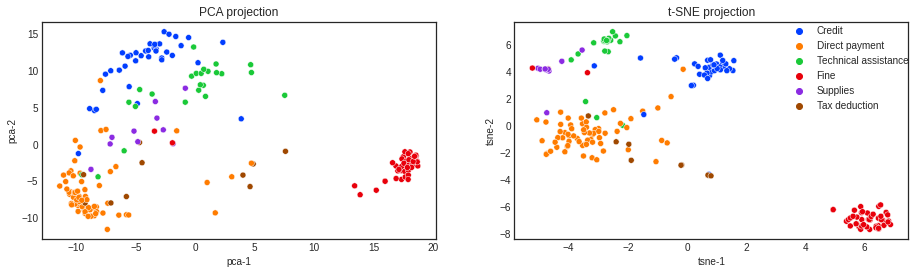

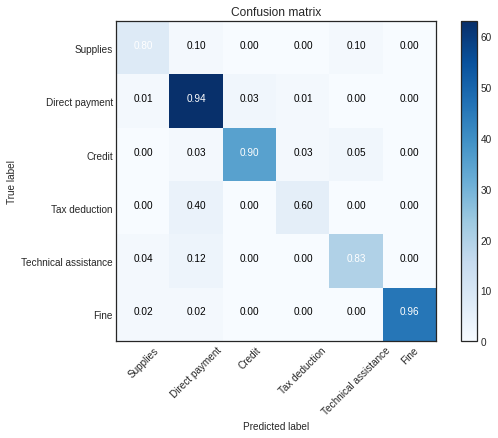

Macro/Weighted Avg F1-score: [0.846568549032155, 0.8985405163456677]




Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Evaluating:  13%|█▎        | 2/15 [00:00<00:00, 15.31it/s]



Evaluating:  27%|██▋       | 4/15 [00:00<00:00, 15.02it/s]

Evaluating:  40%|████      | 6/15 [00:00<00:00, 15.13it/s]

Evaluating:  53%|█████▎    | 8/15 [00:00<00:00, 15.77it/s]

Evaluating:  67%|██████▋   | 10/15 [00:00<00:00, 15.25it/s]

Evaluating:  80%|████████  | 12/15 [00:00<00:00, 14.66it/s]

Evaluating: 100%|██████████| 15/15 [00:00<00:00, 15.38it/s]




Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Evaluating:  13%|█▎        | 2/15 [00:00<00:00, 14.28it/s]



Evaluating:  27%|██▋       | 4/15 [00:00<00:00, 15.06it/s]

Evaluating:  40%|████      | 6/15 [00:00<00:00, 15.76it/s]

Evaluating:  53%|█████▎    | 8/15 [00:00<00:00, 15.22it/s]

Evaluating:  67%|██████▋   | 10/15 [00:00<00:00, 15.14it/s]

Evaluating:  80%|████████  | 12/15 [00:00<00:00, 15.07it/s]

Evaluating: 100%|██████████| 15/15 [00:00<00:00, 15.39it/s]

  1%|          | 6/788 [00:00<00:14, 52.45it/s]


Time taken for fine-tuning: 00:00:17.83
Classifying sentences...



100%|██████████| 788/788 [00:14<00:00, 55.74it/s]

100%|██████████| 198/198 [00:03<00:00, 56.03it/s]


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 198 samples in 0.000s...
[t-SNE] Computed neighbors for 198 samples in 0.012s...
[t-SNE] Computed conditional probabilities for sample 198 / 198
[t-SNE] Mean sigma: 9.058364
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.891972
[t-SNE] KL divergence after 950 iterations: 0.141572
Evaluating predictions...
                      precision    recall  f1-score   support

              Credit       0.95      0.95      0.95        39
      Direct payment       0.86      0.93      0.89        67
                Fine       0.98      0.98      0.98        48
            Supplies       0.62      0.50      0.56        10
       Tax deduction       0.71      0.50      0.59        10
Technical assistance       0.88      0.88      0.88        24

            accuracy                           0.89       198
           macro avg       0.83      0.79      0.81       198
        weighted avg       0.89      0.89      0.8

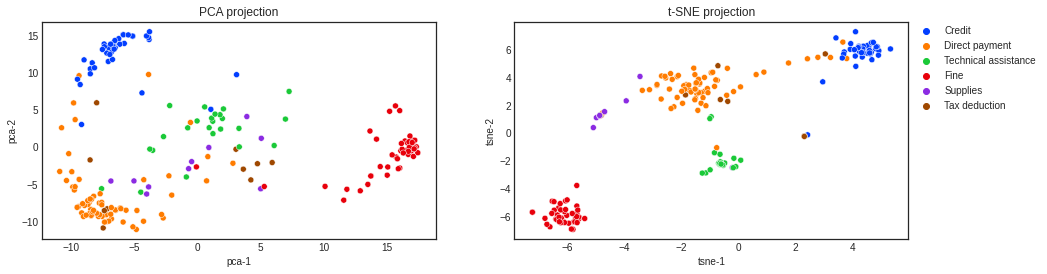

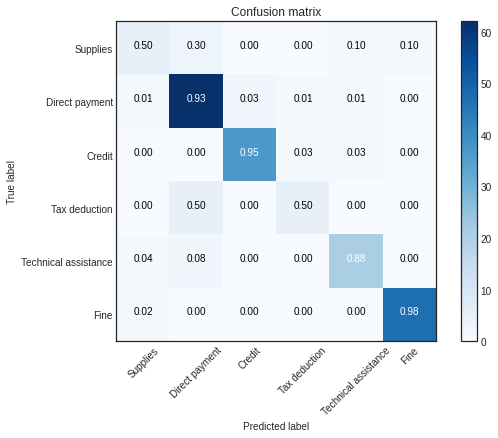

Macro/Weighted Avg F1-score: [0.8064602993321782, 0.8899378417646157]




Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Evaluating:  13%|█▎        | 2/15 [00:00<00:00, 13.59it/s]



Evaluating:  27%|██▋       | 4/15 [00:00<00:00, 14.01it/s]

Evaluating:  40%|████      | 6/15 [00:00<00:00, 14.97it/s]

Evaluating:  53%|█████▎    | 8/15 [00:00<00:00, 16.00it/s]

Evaluating:  67%|██████▋   | 10/15 [00:00<00:00, 15.15it/s]

Evaluating:  80%|████████  | 12/15 [00:00<00:00, 15.10it/s]

Evaluating: 100%|██████████| 15/15 [00:00<00:00, 15.61it/s]




Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Evaluating:  13%|█▎        | 2/15 [00:00<00:00, 14.89it/s]



Evaluating:  27%|██▋       | 4/15 [00:00<00:00, 15.30it/s]

Evaluating:  40%|████      | 6/15 [00:00<00:00, 15.01it/s]

Evaluating:  53%|█████▎    | 8/15 [00:00<00:00, 15.34it/s]

Evaluating:  73%|███████▎  | 11/15 [00:00<00:00, 16.06it/s]

Evaluating: 100%|██████████| 15/15 [00:00<00:00, 16.22it/s]

  1%|          | 6/788 [00:00<00:14, 53.23it/s]


Time taken for fine-tuning: 00:00:17.51
Classifying sentences...



100%|██████████| 788/788 [00:14<00:00, 56.22it/s]

100%|██████████| 198/198 [00:03<00:00, 55.87it/s]


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 198 samples in 0.000s...
[t-SNE] Computed neighbors for 198 samples in 0.013s...
[t-SNE] Computed conditional probabilities for sample 198 / 198
[t-SNE] Mean sigma: 7.754277
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.942894
[t-SNE] KL divergence after 950 iterations: 0.092982
Evaluating predictions...
                      precision    recall  f1-score   support

              Credit       0.80      0.90      0.84        39
      Direct payment       0.89      0.84      0.86        67
                Fine       1.00      0.98      0.99        48
            Supplies       0.86      0.60      0.71        10
       Tax deduction       0.71      0.50      0.59        10
Technical assistance       0.73      0.92      0.81        24

            accuracy                           0.86       198
           macro avg       0.83      0.79      0.80       198
        weighted avg       0.87      0.86      0.8

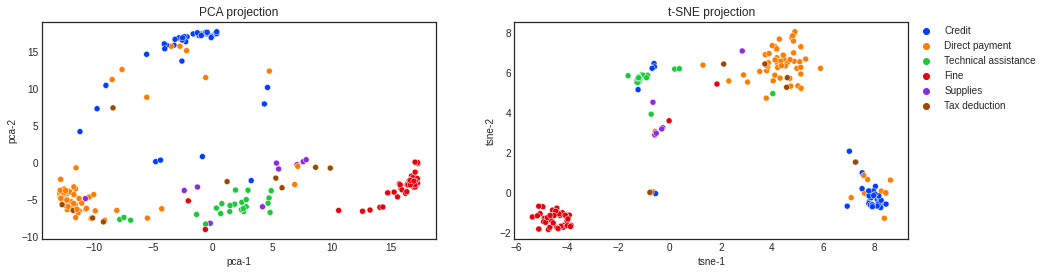

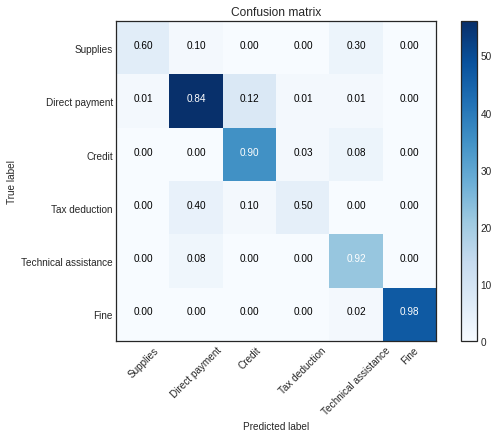

Macro/Weighted Avg F1-score: [0.8005530169330882, 0.8616470305878092]




Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Evaluating:  13%|█▎        | 2/15 [00:00<00:00, 17.88it/s]



Evaluating:  27%|██▋       | 4/15 [00:00<00:00, 17.23it/s]

Evaluating:  40%|████      | 6/15 [00:00<00:00, 16.77it/s]

Evaluating:  53%|█████▎    | 8/15 [00:00<00:00, 15.63it/s]

Evaluating:  67%|██████▋   | 10/15 [00:00<00:00, 15.33it/s]

Evaluating:  80%|████████  | 12/15 [00:00<00:00, 16.00it/s]

Evaluating: 100%|██████████| 15/15 [00:00<00:00, 15.79it/s]




Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Evaluating:  13%|█▎        | 2/15 [00:00<00:00, 15.91it/s]



Evaluating:  27%|██▋       | 4/15 [00:00<00:00, 16.31it/s]

Evaluating:  47%|████▋     | 7/15 [00:00<00:00, 16.75it/s]

Evaluating:  67%|██████▋   | 10/15 [00:00<00:00, 17.19it/s]

Evaluating:  80%|████████  | 12/15 [00:00<00:00, 16.83it/s]

Evaluating: 100%|██████████| 15/15 [00:00<00:00, 16.81it/s]

  1%|          | 5/788 [00:00<00:17, 44.27it/s]


Time taken for fine-tuning: 00:00:17.87
Classifying sentences...



100%|██████████| 788/788 [00:14<00:00, 56.23it/s]

100%|██████████| 198/198 [00:03<00:00, 56.74it/s]


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 198 samples in 0.000s...
[t-SNE] Computed neighbors for 198 samples in 0.009s...
[t-SNE] Computed conditional probabilities for sample 198 / 198
[t-SNE] Mean sigma: 7.312275
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.176895
[t-SNE] KL divergence after 800 iterations: 0.135244
Evaluating predictions...
                      precision    recall  f1-score   support

              Credit       0.90      0.95      0.92        39
      Direct payment       0.85      0.91      0.88        67
                Fine       1.00      0.98      0.99        48
            Supplies       0.78      0.70      0.74        10
       Tax deduction       0.71      0.50      0.59        10
Technical assistance       0.91      0.83      0.87        24

            accuracy                           0.89       198
           macro avg       0.86      0.81      0.83       198
        weighted avg       0.89      0.89      0.8

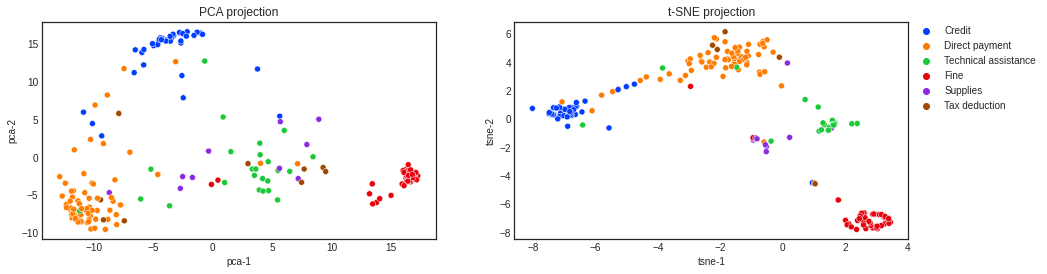

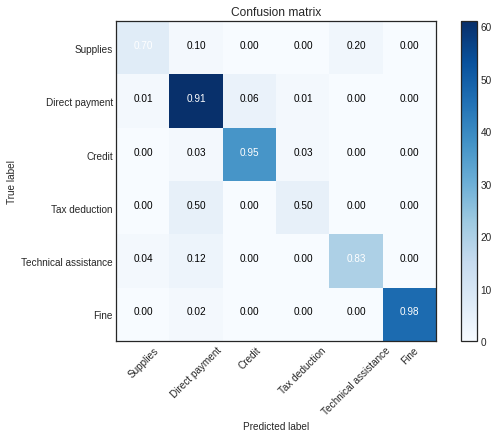

Macro/Weighted Avg F1-score: [0.8311356904515423, 0.8913930881262025]




Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Evaluating:  13%|█▎        | 2/15 [00:00<00:00, 13.82it/s]



Evaluating:  27%|██▋       | 4/15 [00:00<00:00, 14.08it/s]

Evaluating:  40%|████      | 6/15 [00:00<00:00, 14.60it/s]

Evaluating:  53%|█████▎    | 8/15 [00:00<00:00, 15.11it/s]

Evaluating:  67%|██████▋   | 10/15 [00:00<00:00, 15.69it/s]

Evaluating:  80%|████████  | 12/15 [00:00<00:00, 15.00it/s]

Evaluating: 100%|██████████| 15/15 [00:00<00:00, 16.34it/s]




Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Evaluating:  13%|█▎        | 2/15 [00:00<00:00, 19.56it/s]



Evaluating:  27%|██▋       | 4/15 [00:00<00:00, 17.65it/s]

Evaluating:  40%|████      | 6/15 [00:00<00:00, 16.89it/s]

Evaluating:  53%|█████▎    | 8/15 [00:00<00:00, 16.29it/s]

Evaluating:  67%|██████▋   | 10/15 [00:00<00:00, 15.34it/s]

Evaluating:  80%|████████  | 12/15 [00:00<00:00, 15.30it/s]

Evaluating: 100%|██████████| 15/15 [00:00<00:00, 15.58it/s]

  1%|          | 6/788 [00:00<00:15, 51.44it/s]


Time taken for fine-tuning: 00:00:17.75
Classifying sentences...



100%|██████████| 788/788 [00:14<00:00, 55.96it/s]

100%|██████████| 198/198 [00:03<00:00, 55.51it/s]


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 198 samples in 0.003s...
[t-SNE] Computed neighbors for 198 samples in 0.011s...
[t-SNE] Computed conditional probabilities for sample 198 / 198
[t-SNE] Mean sigma: 5.739687
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.023407
[t-SNE] KL divergence after 950 iterations: 0.113889
Evaluating predictions...
                      precision    recall  f1-score   support

              Credit       1.00      0.97      0.99        39
      Direct payment       0.90      0.94      0.92        67
                Fine       0.96      0.98      0.97        48
            Supplies       0.88      0.70      0.78        10
       Tax deduction       0.88      0.70      0.78        10
Technical assistance       0.80      0.83      0.82        24

            accuracy                           0.92       198
           macro avg       0.90      0.85      0.87       198
        weighted avg       0.92      0.92      0.9

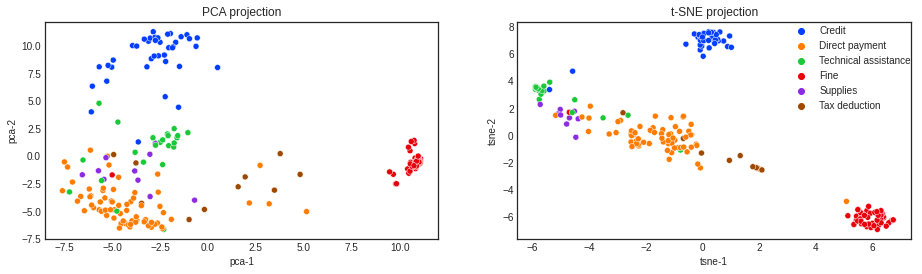

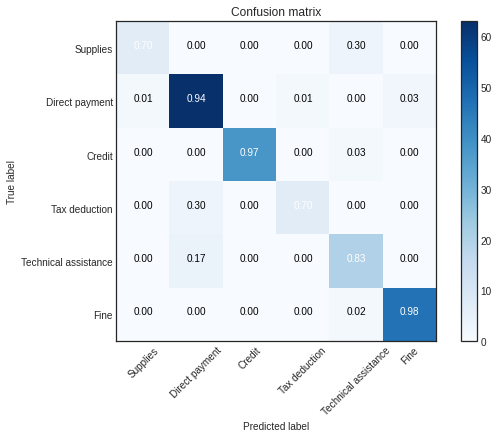

Macro/Weighted Avg F1-score: [0.8746125445543869, 0.9180646497852831]




Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Evaluating:  13%|█▎        | 2/15 [00:00<00:00, 13.81it/s]



Evaluating:  27%|██▋       | 4/15 [00:00<00:00, 14.16it/s]

Evaluating:  40%|████      | 6/15 [00:00<00:00, 14.80it/s]

Evaluating:  53%|█████▎    | 8/15 [00:00<00:00, 14.74it/s]

Evaluating:  67%|██████▋   | 10/15 [00:00<00:00, 14.35it/s]

Evaluating:  80%|████████  | 12/15 [00:00<00:00, 15.33it/s]

Evaluating: 100%|██████████| 15/15 [00:00<00:00, 15.28it/s]




Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Evaluating:  13%|█▎        | 2/15 [00:00<00:00, 16.07it/s]



Evaluating:  27%|██▋       | 4/15 [00:00<00:00, 15.19it/s]

Evaluating:  40%|████      | 6/15 [00:00<00:00, 15.74it/s]

Evaluating:  53%|█████▎    | 8/15 [00:00<00:00, 16.19it/s]

Evaluating:  67%|██████▋   | 10/15 [00:00<00:00, 15.77it/s]

Evaluating:  80%|████████  | 12/15 [00:00<00:00, 15.64it/s]

Evaluating: 100%|██████████| 15/15 [00:00<00:00, 15.41it/s]

  1%|          | 6/788 [00:00<00:14, 53.67it/s]


Time taken for fine-tuning: 00:00:17.96
Classifying sentences...



100%|██████████| 788/788 [00:14<00:00, 56.24it/s]

100%|██████████| 198/198 [00:03<00:00, 57.02it/s]


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 198 samples in 0.000s...
[t-SNE] Computed neighbors for 198 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 198 / 198
[t-SNE] Mean sigma: 6.146374
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.568699
[t-SNE] KL divergence after 850 iterations: 0.118707
Evaluating predictions...
                      precision    recall  f1-score   support

              Credit       0.90      0.95      0.92        39
      Direct payment       0.91      0.87      0.89        67
                Fine       0.96      0.98      0.97        48
            Supplies       0.78      0.70      0.74        10
       Tax deduction       0.86      0.60      0.71        10
Technical assistance       0.79      0.92      0.85        24

            accuracy                           0.89       198
           macro avg       0.86      0.84      0.84       198
        weighted avg       0.89      0.89      0.8

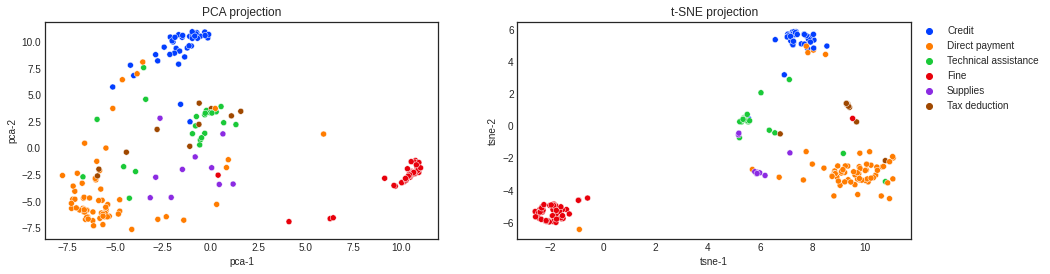

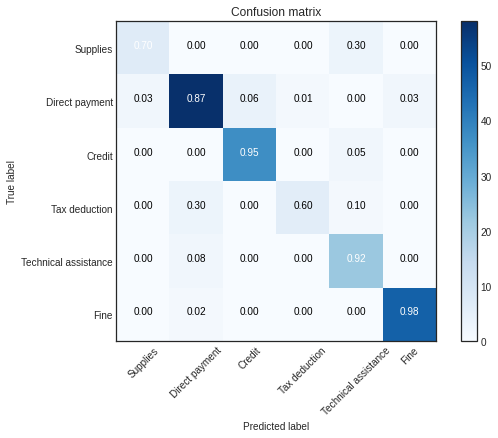

Macro/Weighted Avg F1-score: [0.8447411087521234, 0.892190126677124]




Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Evaluating:  13%|█▎        | 2/15 [00:00<00:00, 16.07it/s]



Evaluating:  27%|██▋       | 4/15 [00:00<00:00, 15.92it/s]

Evaluating:  40%|████      | 6/15 [00:00<00:00, 16.46it/s]

Evaluating:  53%|█████▎    | 8/15 [00:00<00:00, 16.64it/s]

Evaluating:  67%|██████▋   | 10/15 [00:00<00:00, 15.57it/s]

Evaluating:  80%|████████  | 12/15 [00:00<00:00, 15.38it/s]

Evaluating: 100%|██████████| 15/15 [00:00<00:00, 15.57it/s]




Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Evaluating:  13%|█▎        | 2/15 [00:00<00:00, 16.69it/s]



Evaluating:  27%|██▋       | 4/15 [00:00<00:00, 16.23it/s]

Evaluating:  40%|████      | 6/15 [00:00<00:00, 15.84it/s]

Evaluating:  53%|█████▎    | 8/15 [00:00<00:00, 16.07it/s]

Evaluating:  67%|██████▋   | 10/15 [00:00<00:00, 15.43it/s]

Evaluating:  80%|████████  | 12/15 [00:00<00:00, 16.04it/s]

Evaluating: 100%|██████████| 15/15 [00:00<00:00, 15.56it/s]

  1%|          | 6/788 [00:00<00:14, 53.97it/s]


Time taken for fine-tuning: 00:00:17.81
Classifying sentences...



100%|██████████| 788/788 [00:14<00:00, 56.28it/s]

100%|██████████| 198/198 [00:03<00:00, 56.85it/s]


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 198 samples in 0.000s...
[t-SNE] Computed neighbors for 198 samples in 0.011s...
[t-SNE] Computed conditional probabilities for sample 198 / 198
[t-SNE] Mean sigma: 5.893422
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.278320
[t-SNE] KL divergence after 1000 iterations: 0.102856
Evaluating predictions...
                      precision    recall  f1-score   support

              Credit       0.97      0.97      0.97        39
      Direct payment       0.87      0.91      0.89        67
                Fine       0.98      1.00      0.99        48
            Supplies       0.80      0.80      0.80        10
       Tax deduction       0.80      0.40      0.53        10
Technical assistance       0.84      0.88      0.86        24

            accuracy                           0.91       198
           macro avg       0.88      0.83      0.84       198
        weighted avg       0.91      0.91      0.

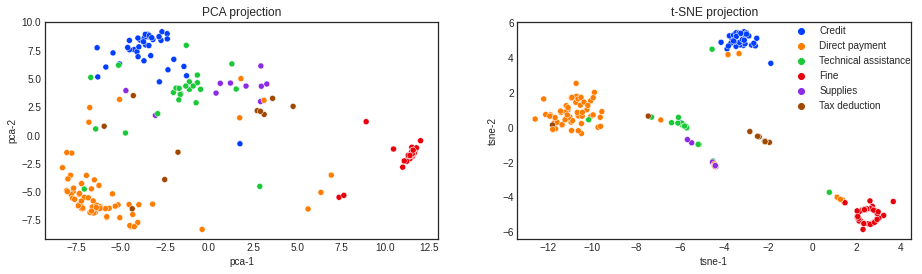

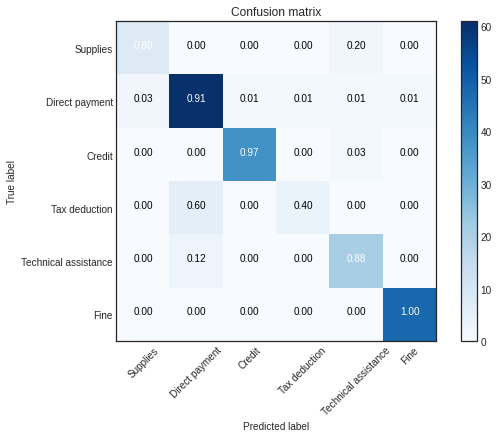

Macro/Weighted Avg F1-score: [0.8408394725649598, 0.9044148995988864]




Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Evaluating:  13%|█▎        | 2/15 [00:00<00:00, 18.98it/s]



Evaluating:  33%|███▎      | 5/15 [00:00<00:00, 19.15it/s]

Evaluating:  47%|████▋     | 7/15 [00:00<00:00, 18.53it/s]

Evaluating:  60%|██████    | 9/15 [00:00<00:00, 17.31it/s]

Evaluating:  73%|███████▎  | 11/15 [00:00<00:00, 15.99it/s]

Evaluating:  87%|████████▋ | 13/15 [00:00<00:00, 15.35it/s]

Evaluating: 100%|██████████| 15/15 [00:00<00:00, 16.37it/s]




Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Evaluating:  13%|█▎        | 2/15 [00:00<00:00, 14.60it/s]



Evaluating:  27%|██▋       | 4/15 [00:00<00:00, 14.43it/s]

Evaluating:  40%|████      | 6/15 [00:00<00:00, 15.42it/s]

Evaluating:  53%|█████▎    | 8/15 [00:00<00:00, 15.64it/s]

Evaluating:  67%|██████▋   | 10/15 [00:00<00:00, 15.72it/s]

Evaluating:  80%|████████  | 12/15 [00:00<00:00, 15.21it/s]

Evaluating: 100%|██████████| 15/15 [00:00<00:00, 15.78it/s]

  1%|          | 6/788 [00:00<00:14, 52.58it/s]


Time taken for fine-tuning: 00:00:17.65
Classifying sentences...



100%|██████████| 788/788 [00:14<00:00, 55.07it/s]

100%|██████████| 198/198 [00:03<00:00, 56.30it/s]


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 198 samples in 0.000s...
[t-SNE] Computed neighbors for 198 samples in 0.008s...
[t-SNE] Computed conditional probabilities for sample 198 / 198
[t-SNE] Mean sigma: 5.641514
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.655663
[t-SNE] KL divergence after 800 iterations: 0.096219
Evaluating predictions...
                      precision    recall  f1-score   support

              Credit       0.95      0.92      0.94        39
      Direct payment       0.88      0.90      0.89        67
                Fine       0.96      0.98      0.97        48
            Supplies       0.78      0.70      0.74        10
       Tax deduction       0.83      0.50      0.62        10
Technical assistance       0.75      0.88      0.81        24

            accuracy                           0.89       198
           macro avg       0.86      0.81      0.83       198
        weighted avg       0.89      0.89      0.8

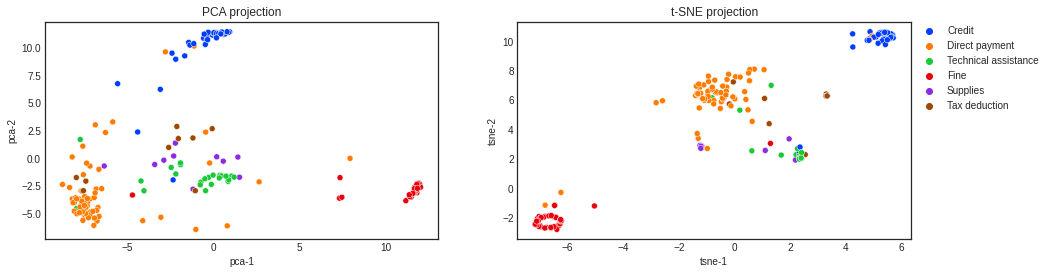

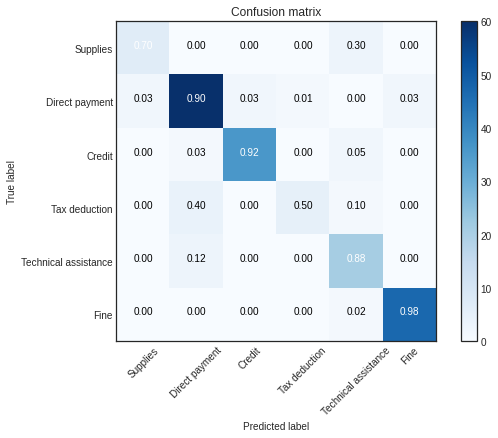

Macro/Weighted Avg F1-score: [0.8270934003096239, 0.8865736786760644]




Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Evaluating:  13%|█▎        | 2/15 [00:00<00:00, 19.30it/s]



Evaluating:  27%|██▋       | 4/15 [00:00<00:00, 17.11it/s]

Evaluating:  40%|████      | 6/15 [00:00<00:00, 17.69it/s]

Evaluating:  53%|█████▎    | 8/15 [00:00<00:00, 16.54it/s]

Evaluating:  67%|██████▋   | 10/15 [00:00<00:00, 16.14it/s]

Evaluating:  80%|████████  | 12/15 [00:00<00:00, 15.25it/s]

Evaluating: 100%|██████████| 15/15 [00:00<00:00, 15.84it/s]




Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Evaluating:  13%|█▎        | 2/15 [00:00<00:00, 16.88it/s]



Evaluating:  27%|██▋       | 4/15 [00:00<00:00, 16.08it/s]

Evaluating:  40%|████      | 6/15 [00:00<00:00, 16.49it/s]

Evaluating:  53%|█████▎    | 8/15 [00:00<00:00, 16.02it/s]

Evaluating:  67%|██████▋   | 10/15 [00:00<00:00, 16.32it/s]

Evaluating:  80%|████████  | 12/15 [00:00<00:00, 17.19it/s]

Evaluating: 100%|██████████| 15/15 [00:00<00:00, 16.35it/s]

  1%|          | 6/788 [00:00<00:15, 50.75it/s]


Time taken for fine-tuning: 00:00:17.74
Classifying sentences...



100%|██████████| 788/788 [00:13<00:00, 56.60it/s]

100%|██████████| 198/198 [00:03<00:00, 56.73it/s]


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 198 samples in 0.000s...
[t-SNE] Computed neighbors for 198 samples in 0.008s...
[t-SNE] Computed conditional probabilities for sample 198 / 198
[t-SNE] Mean sigma: 4.869494
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.719246
[t-SNE] KL divergence after 1000 iterations: 0.093226
Evaluating predictions...
                      precision    recall  f1-score   support

              Credit       0.95      0.97      0.96        39
      Direct payment       0.85      0.91      0.88        67
                Fine       0.96      0.96      0.96        48
            Supplies       0.67      0.60      0.63        10
       Tax deduction       0.80      0.40      0.53        10
Technical assistance       0.83      0.83      0.83        24

            accuracy                           0.88       198
           macro avg       0.84      0.78      0.80       198
        weighted avg       0.88      0.88      0.

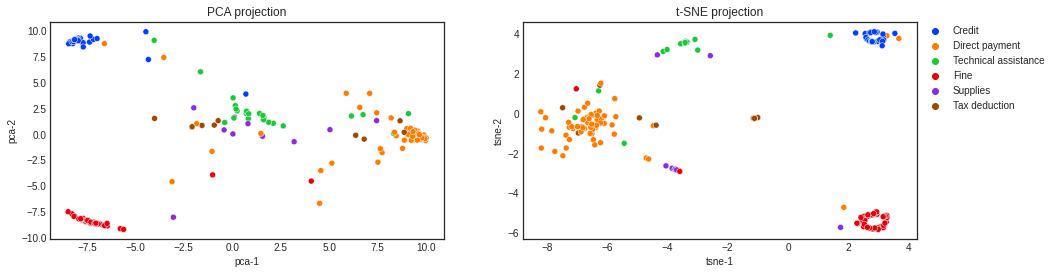

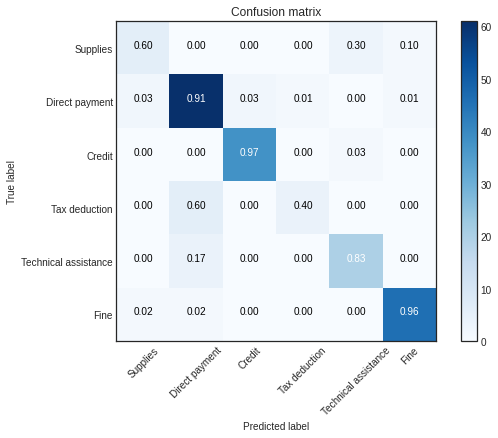

Macro/Weighted Avg F1-score: [0.799383684258456, 0.8786558865882482]




Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Evaluating:  13%|█▎        | 2/15 [00:00<00:00, 19.18it/s]



Evaluating:  27%|██▋       | 4/15 [00:00<00:00, 18.54it/s]

Evaluating:  40%|████      | 6/15 [00:00<00:00, 18.18it/s]

Evaluating:  53%|█████▎    | 8/15 [00:00<00:00, 17.47it/s]

Evaluating:  67%|██████▋   | 10/15 [00:00<00:00, 17.46it/s]

Evaluating:  80%|████████  | 12/15 [00:00<00:00, 16.63it/s]

Evaluating: 100%|██████████| 15/15 [00:00<00:00, 16.29it/s]




Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Evaluating:  13%|█▎        | 2/15 [00:00<00:00, 16.80it/s]



Evaluating:  27%|██▋       | 4/15 [00:00<00:00, 16.62it/s]

Evaluating:  40%|████      | 6/15 [00:00<00:00, 16.36it/s]

Evaluating:  53%|█████▎    | 8/15 [00:00<00:00, 16.34it/s]

Evaluating:  67%|██████▋   | 10/15 [00:00<00:00, 15.91it/s]

Evaluating:  80%|████████  | 12/15 [00:00<00:00, 15.40it/s]

Evaluating: 100%|██████████| 15/15 [00:00<00:00, 15.50it/s]

  1%|          | 6/788 [00:00<00:14, 53.83it/s]


Time taken for fine-tuning: 00:00:17.54
Classifying sentences...



100%|██████████| 788/788 [00:14<00:00, 56.19it/s]

100%|██████████| 198/198 [00:03<00:00, 55.84it/s]


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 198 samples in 0.000s...
[t-SNE] Computed neighbors for 198 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 198 / 198
[t-SNE] Mean sigma: 5.988399
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.572613
[t-SNE] KL divergence after 750 iterations: 0.097079
Evaluating predictions...
                      precision    recall  f1-score   support

              Credit       0.93      0.95      0.94        39
      Direct payment       0.90      0.91      0.90        67
                Fine       1.00      0.98      0.99        48
            Supplies       0.75      0.60      0.67        10
       Tax deduction       0.88      0.70      0.78        10
Technical assistance       0.78      0.88      0.82        24

            accuracy                           0.90       198
           macro avg       0.87      0.84      0.85       198
        weighted avg       0.90      0.90      0.9

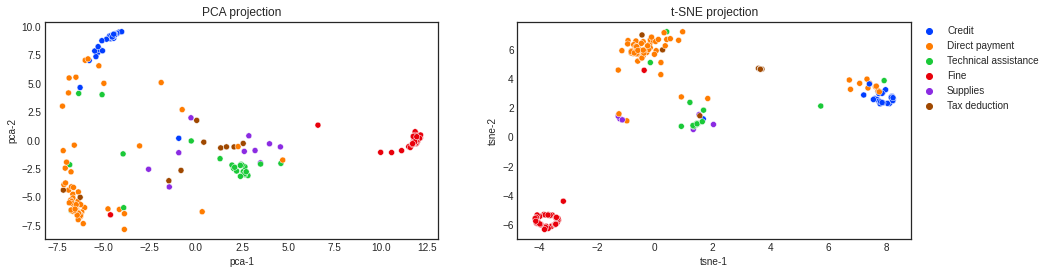

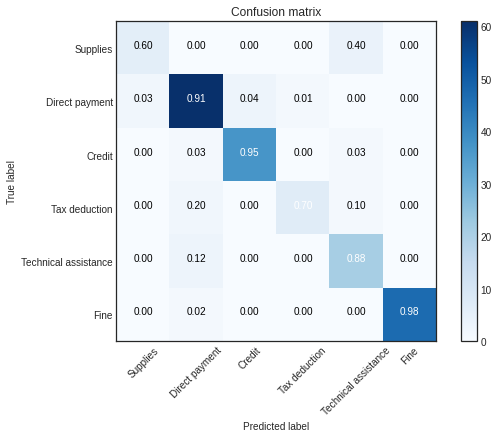

Macro/Weighted Avg F1-score: [0.8496433508138123, 0.9029478832660154]


In [18]:
# To run a grid search over hyperparameters for fine tuning SBERT without storing the model, run:
grid_search_fine_tune_sbert(grid_search_params, train_sents, train_labels, test_sents, test_labels, label_names, eval_classifier=clf)

### Fine tuning with set parameters

In [ ]:
# Configure the fine tuning for one set of parameters
fine_tuning_params = {
    "test_perc": 0.25,
    "model_names": 'paraphrase-xlm-r-multilingual-v1',
    "output_path": results_save_path,
    "experiment": experiment,
    "num_epochs": 10
}

Fine tuning parameters:
 {
    "experiment": "EXP-TEST-NEW-DATA2",
    "model_names": "paraphrase-xlm-r-multilingual-v1",
    "num_epochs": 10,
    "output_path": "/content/drive/MyDrive/WRI-LatinAmerica-Talent/Modeling/FineTuningExperiments/EXP-TEST-NEW-DATA2",
    "test_perc": 0.25
}




Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:  20%|██        | 2/10 [00:00<00:00, 16.49it/s]



Evaluating:  40%|████      | 4/10 [00:00<00:00, 15.65it/s]

Evaluating:  60%|██████    | 6/10 [00:00<00:00, 14.08it/s]

Evaluating: 100%|██████████| 10/10 [00:00<00:00, 14.74it/s]




Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:  20%|██        | 2/10 [00:00<00:00, 16.35it/s]



Evaluating:  40%|████      | 4/10 [00:00<00:00, 15.63it/s]

Evaluating:  60%|██████    | 6/10 [00:00<00:00, 16.17it/s]

Evaluating:  80%|████████  | 8/10 [00:00<00:00, 15.79it/s]

Evaluating: 100%|██████████| 10/10 [00:00<00:00, 15.76it/s]




Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:  20%|██        | 2/10 [00:00<00:00, 19.28it/s]



Evaluating:  40%|████      | 4/10 [00:00<00:00, 17.21it/s]

Evaluating:  60%|██████    | 6/10 [00:00<00:00, 16.28it/s]

Evaluating: 100%|██████████| 10/10 [00:00<00:00, 17.12it/s]




Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:  20%|██        | 2/10 [00:00<00:00, 15.24it/s]



Evaluating:  40%|████      | 4/10 [00:00<00:00, 15.11it/s]

Evaluating:  70%|███████   | 7/10 [00:00<00:00, 16.31it/s]

Evaluating: 100%|██████████| 10/10 [00:00<00:00, 17.10it/s]




Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:  20%|██        | 2/10 [00:00<00:00, 16.76it/s]



Evaluating:  40%|████      | 4/10 [00:00<00:00, 16.66it/s]

Evaluating:  60%|██████    | 6/10 [00:00<00:00, 15.59it/s]

Evaluating:  80%|████████  | 8/10 [00:00<00:00, 15.11it/s]

Evaluating: 100%|██████████| 10/10 [00:00<00:00, 14.73it/s]




Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:  20%|██        | 2/10 [00:00<00:00, 16.47it/s]



Evaluating:  40%|████      | 4/10 [00:00<00:00, 16.36it/s]

Evaluating:  60%|██████    | 6/10 [00:00<00:00, 14.67it/s]

Evaluating: 100%|██████████| 10/10 [00:00<00:00, 16.24it/s]




Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:  20%|██        | 2/10 [00:00<00:00, 18.25it/s]



Evaluating:  40%|████      | 4/10 [00:00<00:00, 18.06it/s]

Evaluating:  60%|██████    | 6/10 [00:00<00:00, 16.85it/s]

Evaluating:  80%|████████  | 8/10 [00:00<00:00, 15.23it/s]

Evaluating: 100%|██████████| 10/10 [00:00<00:00, 15.80it/s]




Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:  10%|█         | 1/10 [00:00<00:00,  9.68it/s]



Evaluating:  30%|███       | 3/10 [00:00<00:00, 11.07it/s]

Evaluating:  50%|█████     | 5/10 [00:00<00:00, 11.96it/s]

Evaluating:  70%|███████   | 7/10 [00:00<00:00, 12.84it/s]

Evaluating: 100%|██████████| 10/10 [00:00<00:00, 15.20it/s]




Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:  20%|██        | 2/10 [00:00<00:00, 13.59it/s]



Evaluating:  40%|████      | 4/10 [00:00<00:00, 13.74it/s]

Evaluating:  60%|██████    | 6/10 [00:00<00:00, 14.59it/s]

Evaluating: 100%|██████████| 10/10 [00:00<00:00, 15.79it/s]




Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:  20%|██        | 2/10 [00:00<00:00, 12.57it/s]



Evaluating:  40%|████      | 4/10 [00:00<00:00, 13.16it/s]

Evaluating:  60%|██████    | 6/10 [00:00<00:00, 14.15it/s]

Evaluating:  80%|████████  | 8/10 [00:00<00:00, 14.64it/s]

Evaluating: 100%|██████████| 10/10 [00:00<00:00, 15.39it/s]



Time taken for fine-tuning: 00:01:40.95
Classifying sentences...



100%|██████████| 150/150 [00:07<00:00, 20.39it/s]


[t-SNE] Computing 149 nearest neighbors...
[t-SNE] Indexed 150 samples in 0.000s...
[t-SNE] Computed neighbors for 150 samples in 0.016s...
[t-SNE] Computed conditional probabilities for sample 150 / 150
[t-SNE] Mean sigma: 20.614611
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.593678
[t-SNE] KL divergence after 950 iterations: 0.092751



100%|██████████| 150/150 [00:00<00:00, 9216.63it/s]


Stored confusion matrix: /content/drive/MyDrive/WRI-LatinAmerica-Talent/Modeling/FineTuningExperiments/EXP-TEST-NEW-DATA2/model=paraphrase-xlm-r-multilingual-v1_test-perc=0.25_n-epoch=10_cm.png


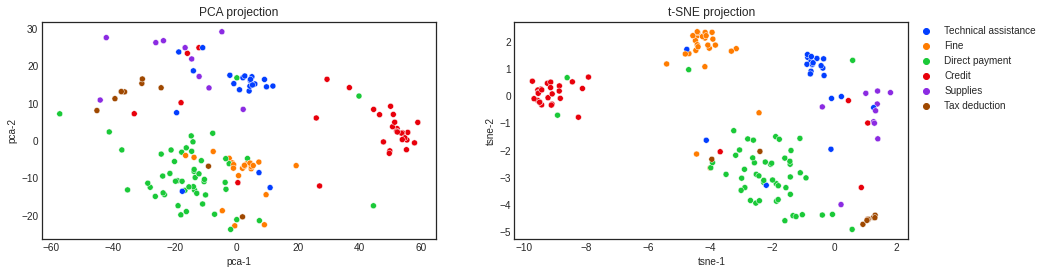

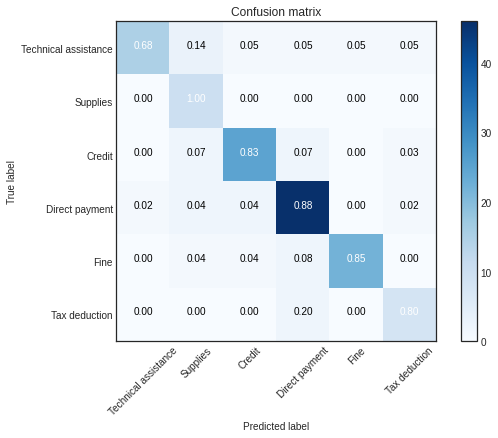

Macro/Weighted Avg F1-score: [0.8145452412305988, 0.8430859877700709]


In [ ]:
# If you already know which configuration you want to fine tune SBERT on, and want to store the model, run:
fine_tune_sbert(fine_tuning_params, train_sents, train_labels, test_sents, test_labels, label_names)

### Load best model from training

In [ ]:
model_name = "paraphrase-xlm-r-multilingual-v1"
test_perc = 0.25
num_epochs = 10
model_deets = f"model={model_name}_test-perc={test_perc}_n-epoch={num_epochs}"
experiment = "EXP-TEST-NEW-DATA2"

saved_model_path = f"{base_path}/Modeling/FineTuningExperiments/{experiment}"
# saved_model_path = f"/content/drive/MyDrive/Official Folder of WRI Latin America Project/WRI-LatinAmerica-Talent/Modeling/FineTuningExperiments/{Experiment}/FineTuning_{model_deets}"

In [ ]:
saved_model = SentenceTransformer(saved_model_path)

In [ ]:
# Simple embeddings, no projection matrix added
train_sent_embs = encode_all_sents(train_sents, saved_model)
test_sent_embs = encode_all_sents(test_sents, saved_model)

### Test multiple classifiers
- Random Forests

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
clf = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=69420)
clf.fit(np.vstack(train_sent_embs), train_labels)
clf_preds = [clf.predict(sent_emb)[0] for sent_emb in test_sent_embs]
print(classification_report(test_labels, clf_preds))

                      precision    recall  f1-score   support

              Credit       1.00      0.77      0.87        30
      Direct payment       0.81      0.90      0.85        52
                Fine       0.80      0.92      0.86        26
            Supplies       0.00      0.00      0.00        10
       Tax deduction       0.00      0.00      0.00        10
Technical assistance       0.49      0.86      0.62        22

            accuracy                           0.75       150
           macro avg       0.52      0.58      0.53       150
        weighted avg       0.69      0.75      0.71       150



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Stored confusion matrix: /content/drive/MyDrive/WRI-LatinAmerica-Talent/Modeling/FineTuningExperiments/EXP-TEST-NEW-DATA2/RandomForest_cm.png


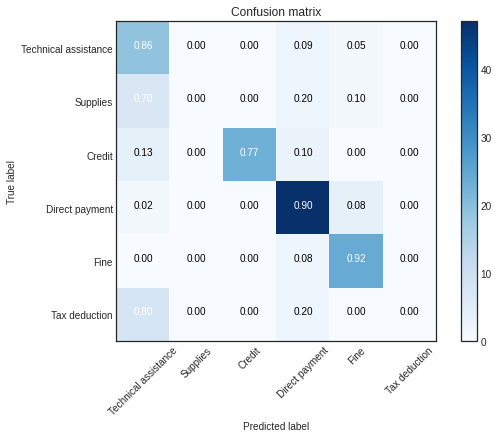

In [ ]:
numeric_preds = labels2numeric(clf_preds, label_names)
numeric_test_labels = labels2numeric(test_labels, label_names)
evaluator = ModelEvaluator(label_names, y_true=numeric_test_labels, y_pred=numeric_preds)
evaluator.plot_confusion_matrix(color_map='Blues', exp_name=f"{saved_model_path}/RandomForest")

- Support Vector Machines

In [ ]:
from sklearn import svm

In [ ]:
clf = svm.SVC(gamma=0.001, C=100.)
clf.fit(np.vstack(train_sent_embs), train_labels)
clf_preds = [clf.predict(sent_emb)[0] for sent_emb in test_sent_embs]
print(classification_report(test_labels, clf_preds))

                      precision    recall  f1-score   support

              Credit       1.00      0.70      0.82        30
      Direct payment       0.78      0.90      0.84        52
                Fine       0.80      0.92      0.86        26
            Supplies       0.67      0.80      0.73        10
       Tax deduction       0.89      0.80      0.84        10
Technical assistance       0.94      0.77      0.85        22

            accuracy                           0.83       150
           macro avg       0.85      0.82      0.82       150
        weighted avg       0.85      0.83      0.83       150



Stored confusion matrix: /content/drive/MyDrive/WRI-LatinAmerica-Talent/Modeling/FineTuningExperiments/EXP-TEST-NEW-DATA2/SVM_cm.png


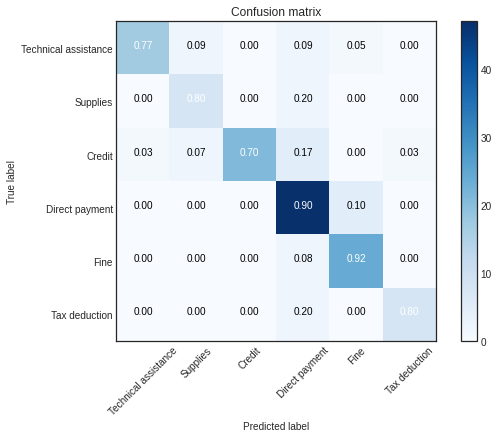

In [ ]:
numeric_preds = labels2numeric(clf_preds, label_names)
numeric_test_labels = labels2numeric(test_labels, label_names)
evaluator = ModelEvaluator(label_names, y_true=numeric_test_labels, y_pred=numeric_preds)
evaluator.plot_confusion_matrix(color_map='Blues', exp_name=f"{saved_model_path}/SVM")

- Gradient Boosting trees

In [ ]:
!pip install xgboost \
  lightgbm \
  catboost

In [ ]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (AdaBoostClassifier,
                              GradientBoostingClassifier)

In [ ]:
cb = CatBoostClassifier(n_estimators=2000,
                        colsample_bylevel=0.06,
                        max_leaves=31,
                        subsample=0.67,
                        verbose=0,
                        thread_count=6,
                        random_state=69420,
                        bootstrap_type='Poisson')

gbm = GradientBoostingClassifier(n_estimators=2000,
                                 subsample=0.67,
                                 max_features=0.06,
                                 validation_fraction=0.1,
                                 n_iter_no_change=15,
                                 verbose=0,
                                 random_state=69420)

lgbm = LGBMClassifier(n_estimators=2000,
                      feature_fraction=0.06,
                      bagging_fraction=0.67,
                      bagging_freq=1,
                      verbose=0,
                      n_jobs=6,
                      random_state=69420)

xgb = XGBClassifier(n_estimators=2000,
                    tree_method='hist',
                    subsample=0.67,
                    colsample_level=0.06,
                    verbose=0,
                    n_jobs=6,
                    random_state=69420)

base_estim = DecisionTreeClassifier(max_depth=1, max_features=0.06)                          
ab = AdaBoostClassifier(base_estimator=base_estim,
                        n_estimators=500,
                        learning_rate=0.5,
                        random_state=69420)


Evaluating: LGBMClassifier
Training...
Predicting...
                      precision    recall  f1-score   support

              Credit       1.00      0.77      0.87        30
      Direct payment       0.82      0.94      0.87        52
                Fine       0.83      0.92      0.87        26
            Supplies       0.70      0.70      0.70        10
       Tax deduction       0.89      0.80      0.84        10
Technical assistance       0.89      0.77      0.83        22

            accuracy                           0.85       150
           macro avg       0.85      0.82      0.83       150
        weighted avg       0.86      0.85      0.85       150

Stored confusion matrix: /content/drive/MyDrive/WRI-LatinAmerica-Talent/Modeling/FineTuningExperiments/EXP-TEST-NEW-DATA2/LGBMClassifier_cm.png


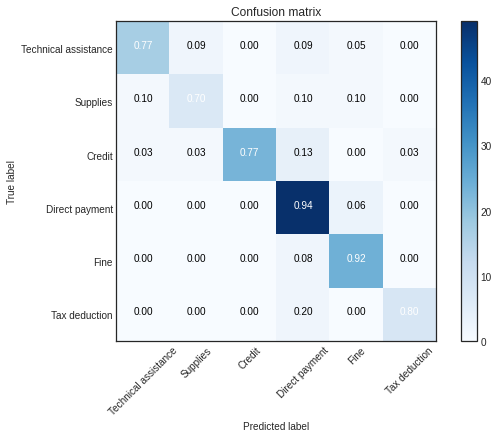

Evaluating: GradientBoostingClassifier
Training...
Predicting...
                      precision    recall  f1-score   support

              Credit       1.00      0.73      0.85        30
      Direct payment       0.78      0.88      0.83        52
                Fine       0.77      0.92      0.84        26
            Supplies       0.70      0.70      0.70        10
       Tax deduction       0.80      0.80      0.80        10
Technical assistance       0.94      0.77      0.85        22

            accuracy                           0.83       150
           macro avg       0.83      0.80      0.81       150
        weighted avg       0.84      0.83      0.83       150

Stored confusion matrix: /content/drive/MyDrive/WRI-LatinAmerica-Talent/Modeling/FineTuningExperiments/EXP-TEST-NEW-DATA2/GradientBoostingClassifier_cm.png


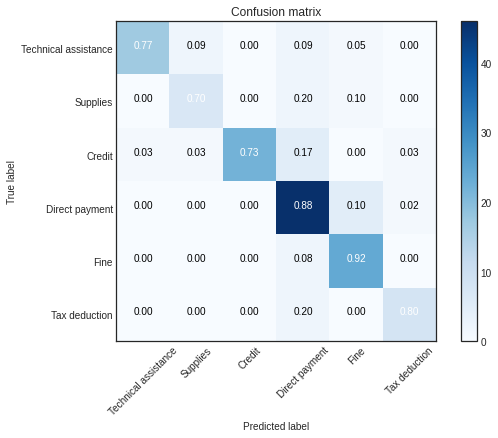

Evaluating: XGBClassifier
Training...
Predicting...
                      precision    recall  f1-score   support

              Credit       1.00      0.73      0.85        30
      Direct payment       0.78      0.90      0.84        52
                Fine       0.80      0.92      0.86        26
            Supplies       0.67      0.60      0.63        10
       Tax deduction       0.73      0.80      0.76        10
Technical assistance       0.94      0.77      0.85        22

            accuracy                           0.83       150
           macro avg       0.82      0.79      0.80       150
        weighted avg       0.84      0.83      0.83       150

Stored confusion matrix: /content/drive/MyDrive/WRI-LatinAmerica-Talent/Modeling/FineTuningExperiments/EXP-TEST-NEW-DATA2/XGBClassifier_cm.png


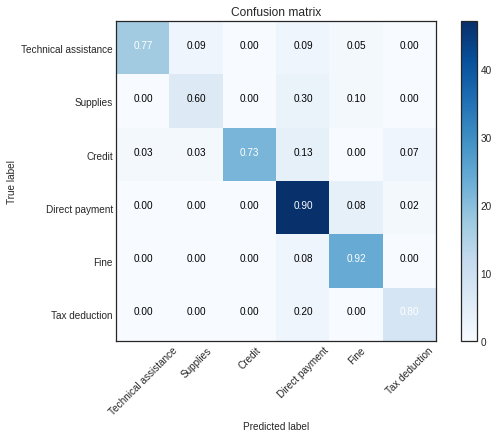

Evaluating: AdaBoostClassifier
Training...
Predicting...
                      precision    recall  f1-score   support

              Credit       1.00      0.73      0.85        30
      Direct payment       0.67      0.98      0.80        52
                Fine       0.92      0.92      0.92        26
            Supplies       1.00      0.40      0.57        10
       Tax deduction       1.00      0.80      0.89        10
Technical assistance       1.00      0.64      0.78        22

            accuracy                           0.82       150
           macro avg       0.93      0.75      0.80       150
        weighted avg       0.87      0.82      0.82       150

Stored confusion matrix: /content/drive/MyDrive/WRI-LatinAmerica-Talent/Modeling/FineTuningExperiments/EXP-TEST-NEW-DATA2/AdaBoostClassifier_cm.png


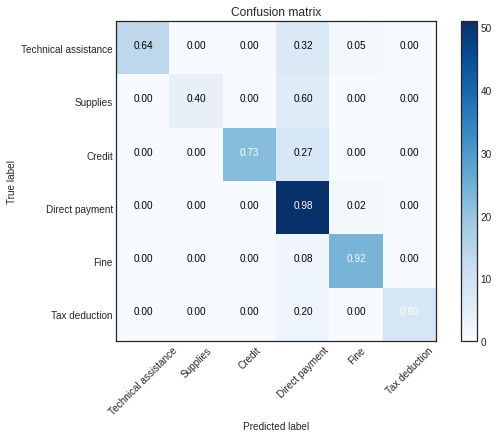

In [ ]:
gb_classifiers = [lgbm, gbm, xgb, ab] #cb
gb_names = [i.__class__.__name__ for i in gb_classifiers]

for clf, clf_name in zip(gb_classifiers, gb_names):
  print("Evaluating:", clf_name)
  print("Training...")
  clf.fit(np.vstack(train_sent_embs), train_labels)
  print("Predicting...")
  clf_preds = [clf.predict(sent_emb)[0] for sent_emb in test_sent_embs]
  print(classification_report(test_labels, clf_preds))
  numeric_preds = labels2numeric(clf_preds, label_names)
  numeric_test_labels = labels2numeric(test_labels, label_names)
  evaluator = ModelEvaluator(label_names, y_true=numeric_test_labels, y_pred=numeric_preds)
  evaluator.plot_confusion_matrix(color_map='Blues', exp_name=f"{saved_model_path}/{clf_name}")

### Building datasets

This piece of code below has been used to build the test splits and the datasets for the fine tuning. Don't execute it unless you kow what you want :)

In [ ]:
def labels_from_dataset(dataset, label):
    labels = []

    for sentence in dataset.values():
        labels.append(sentence[label])

    return labels

In [ ]:
rater = "Rater3"
set_of_labels = All
set_of_labels_string = "All"

dataset_fname = "/content/drive/MyDrive/Official Folder of WRI Latin America Project/WRI-LatinAmerica-Talent/Cristina_Policy_Files/Tagged_sentence_lists/{}_labeled.json".format(rater)
dataset = load_file(dataset_fname)
dataset_map = labeled_sentences_from_dataset(dataset) # Labels AND sentences
# dataset_map_target_labels =  select_labels(dataset_map, set_of_labels) # Adjust to the labels you want to use for your analysis. In the cell above you have three pre-defined sets.
# train_sents = sentences_from_dataset(dataset_map_target_labels) # Just sentences
# train_labels = labels_from_dataset(dataset_map_target_labels, "labels") # Just labels. 

train_sents = sentences_from_dataset(dataset_map) # Just sentences
train_labels = labels_from_dataset(dataset_map, "incentive") # Just labels.

In [ ]:
len(train_labels)

1526

In [ ]:
# # The rest:
label_names = unique_labels(train_labels)
numeric_labels = labels2numeric(train_labels, label_names)
label_names

['Supplies',
 'Technical assistance',
 'Direct payment',
 'Fine',
 'Tax deduction',
 'Credit']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_sents, train_labels, test_size=0.2, stratify=train_labels, random_state=69420)

In [ ]:
# import csv
path = "/content/drive/MyDrive/Official Folder of WRI Latin America Project/WRI-LatinAmerica-Talent/Cristina_Policy_Files/Tagged_sentence_lists/datasets/"

filename = "dataset_{}_incentive_sentences.csv".format(rater)
file = path + filename
with open(file, 'w') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow(X_train)

filename = "dataset_{}_incentive_labels.csv".format(rater)
file = path + filename
with open(file, 'w') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow(y_train)

filename = "testset_{}_incentive_sentences.csv".format(rater)
file = path + filename
with open(file, 'w') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow(X_test)

filename = "testset_{}_incentive_labels.csv".format(rater)
file = path + filename
with open(file, 'w') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow(y_test)


In [ ]:
# import csv
path = "/content/drive/MyDrive/Official Folder of WRI Latin America Project/WRI-LatinAmerica-Talent/Cristina_Policy_Files/Tagged_sentence_lists/datasets/"

filename = "dataset_{}_{}_sentences.csv".format(rater, set_of_labels_string)
file = path + filename
with open(file, 'w') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow(X_train)

filename = "dataset_{}_{}_labels.csv".format(rater, set_of_labels_string)
file = path + filename
with open(file, 'w') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow(y_train)

filename = "testset_{}_{}_sentences.csv".format(rater, set_of_labels_string)
file = path + filename
with open(file, 'w') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow(X_test)

filename = "testset_{}_{}_labels.csv".format(rater, set_of_labels_string)
file = path + filename
with open(file, 'w') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow(y_test)
